In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import os
import seaborn as sns
from glob import glob
import warnings
from autopreprocess_pipeline import *
from autopreprocessing import dataset as ds
import shutil 
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRFClassifier 
import cupy as cp
import xgboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler


In [2]:
X_train = np.load("nparrs/X_train_12000_4000.npy")
X_test = np.load("nparrs/X_test_12000_4000.npy")
X_val = np.load("nparrs/X_val_12000_4000.npy")
y_train = np.load("nparrs/y_train_12000_4000.npy")
y_test = np.load("nparrs/y_test_12000_4000.npy")
y_val = np.load("nparrs/y_val_12000_4000.npy")

In [3]:
def create_dataframe(data, channels, features):
    
    num_channels = len(channels)
    num_features = len(features)
    column_names = [f'{channel}_{feature}' for channel in channels for feature in features]
    df = pd.DataFrame(data, columns=column_names)
    return df

In [4]:
channels = [
    'Fp1','Fp2','F7','F3','Fz','F4','F8','FC3','FCz','FC4',
    'T7','C3','Cz','C4','T8','CP3','CPz','CP4','P7','P3',
    'Pz','P4','P8','O1','Oz','O2'
]

features = [
    "mean_val", "std_val", "rms_val", "kurtosis_val", "skewness_val",
    "activity", "mobility", "complexity", "shannon_entropy_val",
    "spectral_entropy_delta", "spectral_entropy_theta", "spectral_entropy_alpha", 
    "spectral_entropy_beta", "spectral_entropy_gamma",
    "delta_power", "theta_power", "alpha_power", "beta_power", "gamma_power",
    "wavelet_entropy_val", "theta_beta_ratio", "katz_fd_val", "petrosian_fd_val", "higuchi_fd_val"
]


In [5]:
training_df_initial = create_dataframe(X_train, channels, features)
testing_df = create_dataframe(X_test, channels, features)
validation_df = create_dataframe(X_val, channels, features)

In [6]:
training_df_initial['diagnosis'] = y_train
testing_df['diagnosis'] = y_test
validation_df['diagnosis'] = y_val

### Outlier detection and removal

The idea is to use PCA decomposition in order to detect outliers in a high-dimensional dataset. Since we will map our data into a two-dimensional space, we can detect outliers by removing the top 5% of points that are most distant to their PCA counterpart. This works because points that are distant from the PCA plane are likely to be outliers, since they will have a large 'reconstruction' error, I.E they were not representative of the patterns in the data in the first place.

In [7]:
def remove_outliers(df:pd.DataFrame) -> pd.DataFrame:

    # Standardize the data first
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # Perform PCA
    pca = PCA(n_components=2)  # Reduce to 2 components for visualization
    pca.fit(scaled_data)
    pca_components = pca.transform(scaled_data)

    # Calculate the reconstruction error (distance to PCA subspace)
    reconstructed_data = pca.inverse_transform(pca_components)
    errors = np.mean(np.abs(scaled_data - reconstructed_data), axis=1)

    # Set a threshold for error
    threshold = np.percentile(errors, 95)  # Top 5% as outliers

    # Remove outliers
    cleaned_df = df[errors < threshold]
    
    print(f"Original data shape: {df.shape}")
    print(f"Data shape after outlier removal: {cleaned_df.shape}")

    return cleaned_df


In [8]:
training_df = remove_outliers(training_df_initial)

Original data shape: (1612, 625)
Data shape after outlier removal: (1531, 625)


##### PCA visualization of training data (before outlier removal)

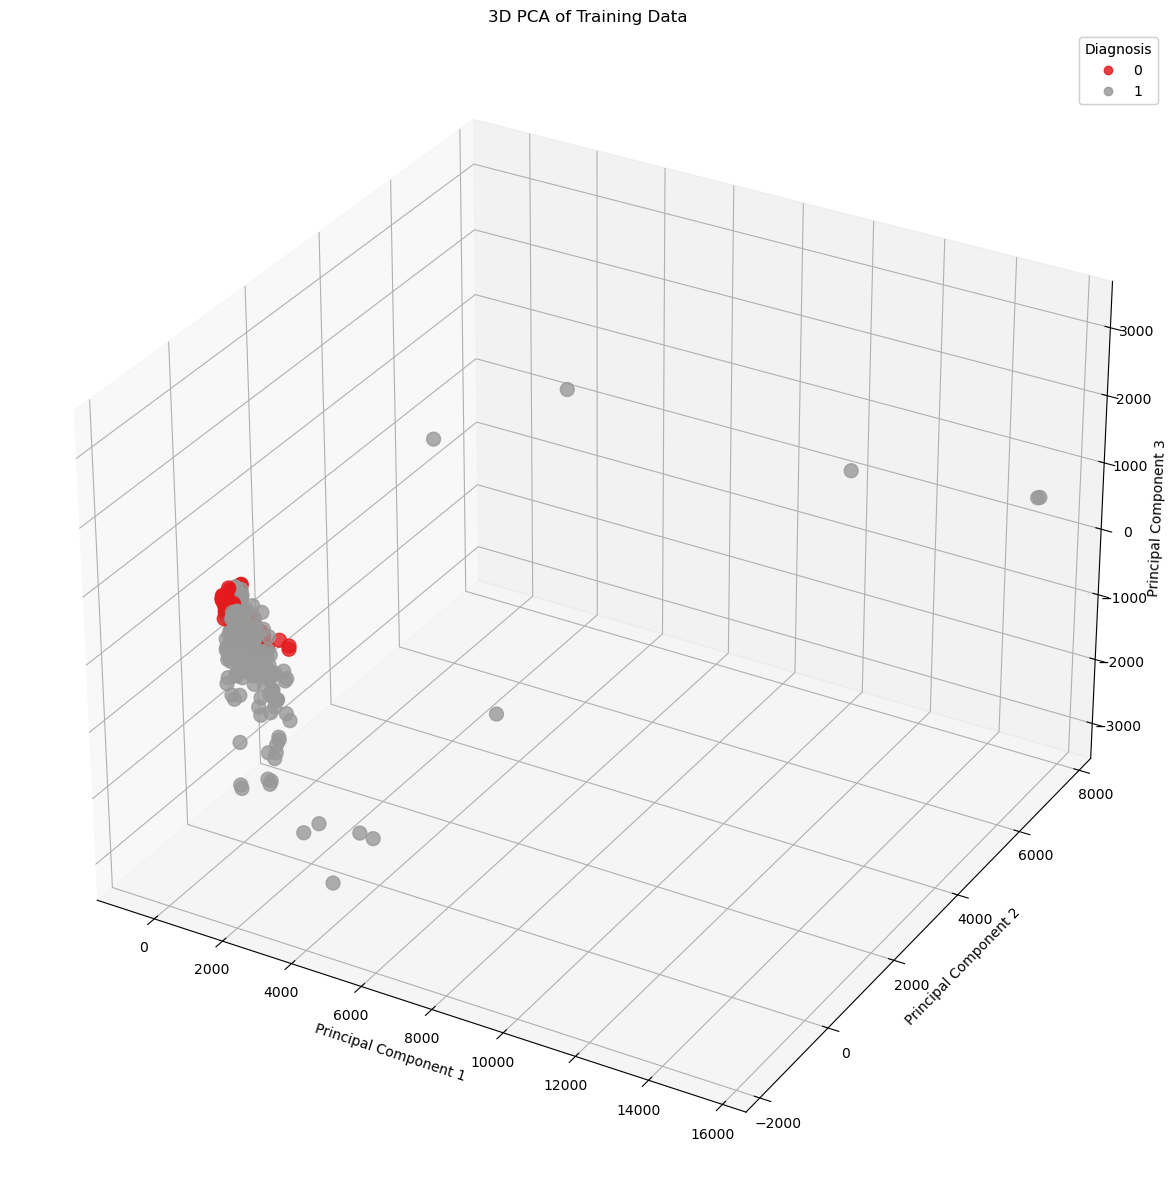

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Perform PCA with 3 components
pca = PCA(n_components=3)
pca_components_training = pca.fit_transform(training_df_initial)
# Create a DataFrame with the PCA components
pca_df_training = pd.DataFrame(data=pca_components_training, columns=['PC1', 'PC2', 'PC3'])
pca_df_training['diagnosis'] = training_df_initial['diagnosis']

# 3D scatter plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(pca_df_training['PC1'], pca_df_training['PC2'], pca_df_training['PC3'],
                     c=pca_df_training['diagnosis'], cmap='Set1', s=100, alpha=0.8)

# Add labels
ax.set_title('3D PCA of Training Data')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Diagnosis")
ax.add_artist(legend1)

# Show grid
plt.grid(True)
plt.show()


### PCA visualization of training data (after outlier removal)

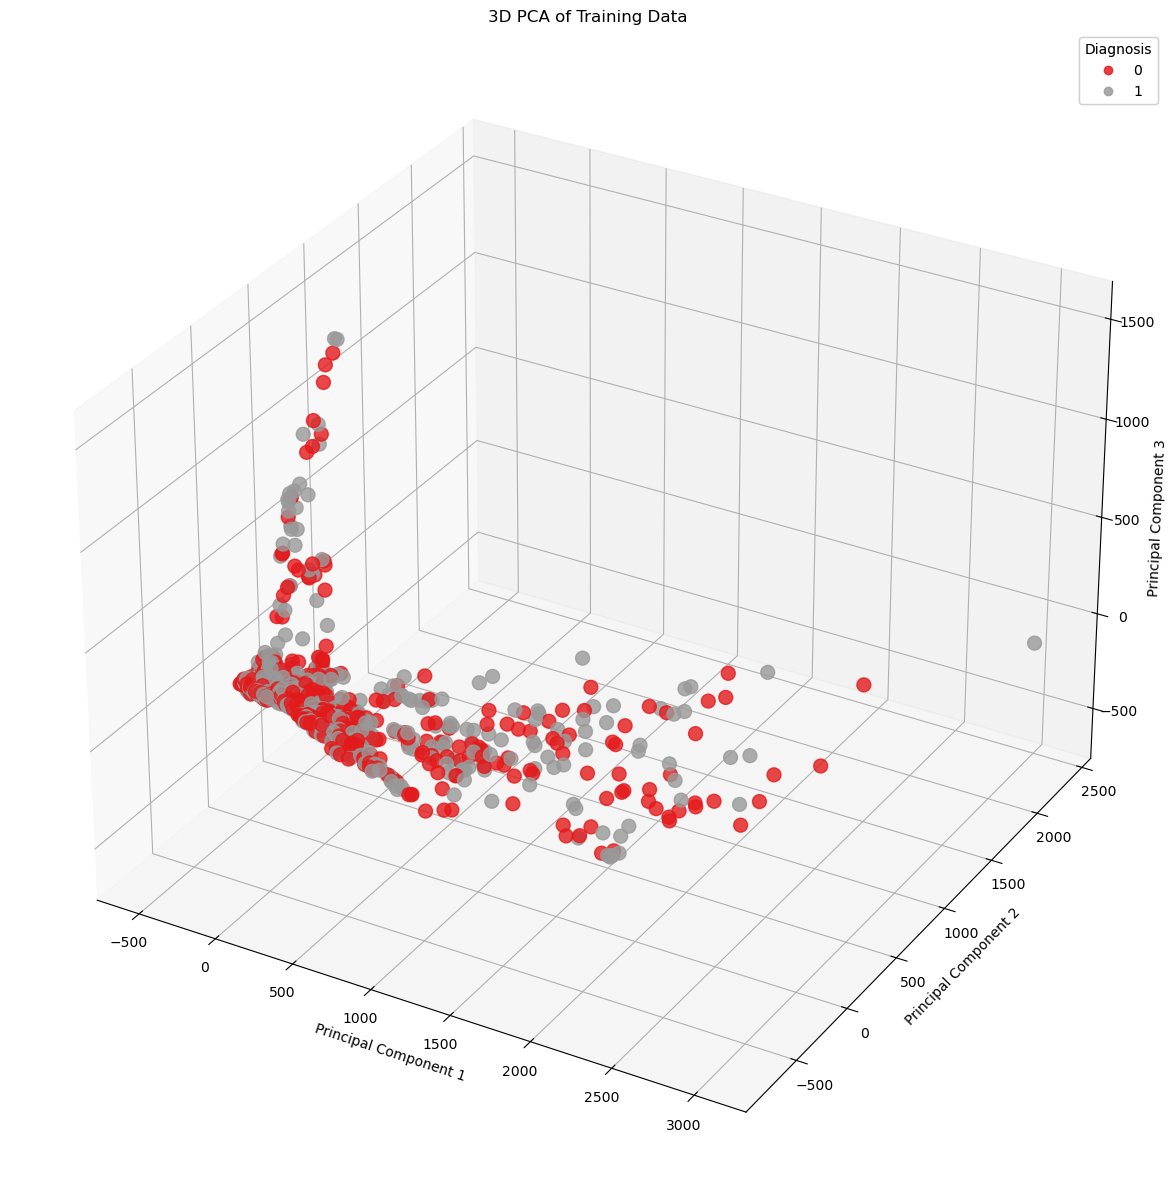

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Perform PCA with 3 components
pca = PCA(n_components=3)
pca_components_training = pca.fit_transform(training_df)
# Create a DataFrame with the PCA components
pca_df_training = pd.DataFrame(data=pca_components_training, columns=['PC1', 'PC2', 'PC3'])
pca_df_training['diagnosis'] = training_df['diagnosis']

# 3D scatter plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(pca_df_training['PC1'], pca_df_training['PC2'], pca_df_training['PC3'],
                     c=pca_df_training['diagnosis'], cmap='Set1', s=100, alpha=0.8)

# Add labels
ax.set_title('3D PCA of Training Data')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Diagnosis")
ax.add_artist(legend1)

# Show grid
plt.grid(True)
plt.show()

### Exploratory data analysis

This part visualizes previously researched differences in EEG signals between people with ADHD and healthy people. 

1. Differences in theta and alpha actvitiy, as well as theta-beta ratio. [INSERT CITATION]

In [11]:
abt = training_df.filter(regex='theta_power|alpha_power|theta_beta_ratio|diagnosis')

In [12]:
alpha_powers = abt.filter(regex='alpha_power|diagnosis')
theta_powers = abt.filter(regex='theta_power|diagnosis')
theta_beta_ratios = abt.filter(regex='theta_beta_ratio|diagnosis')

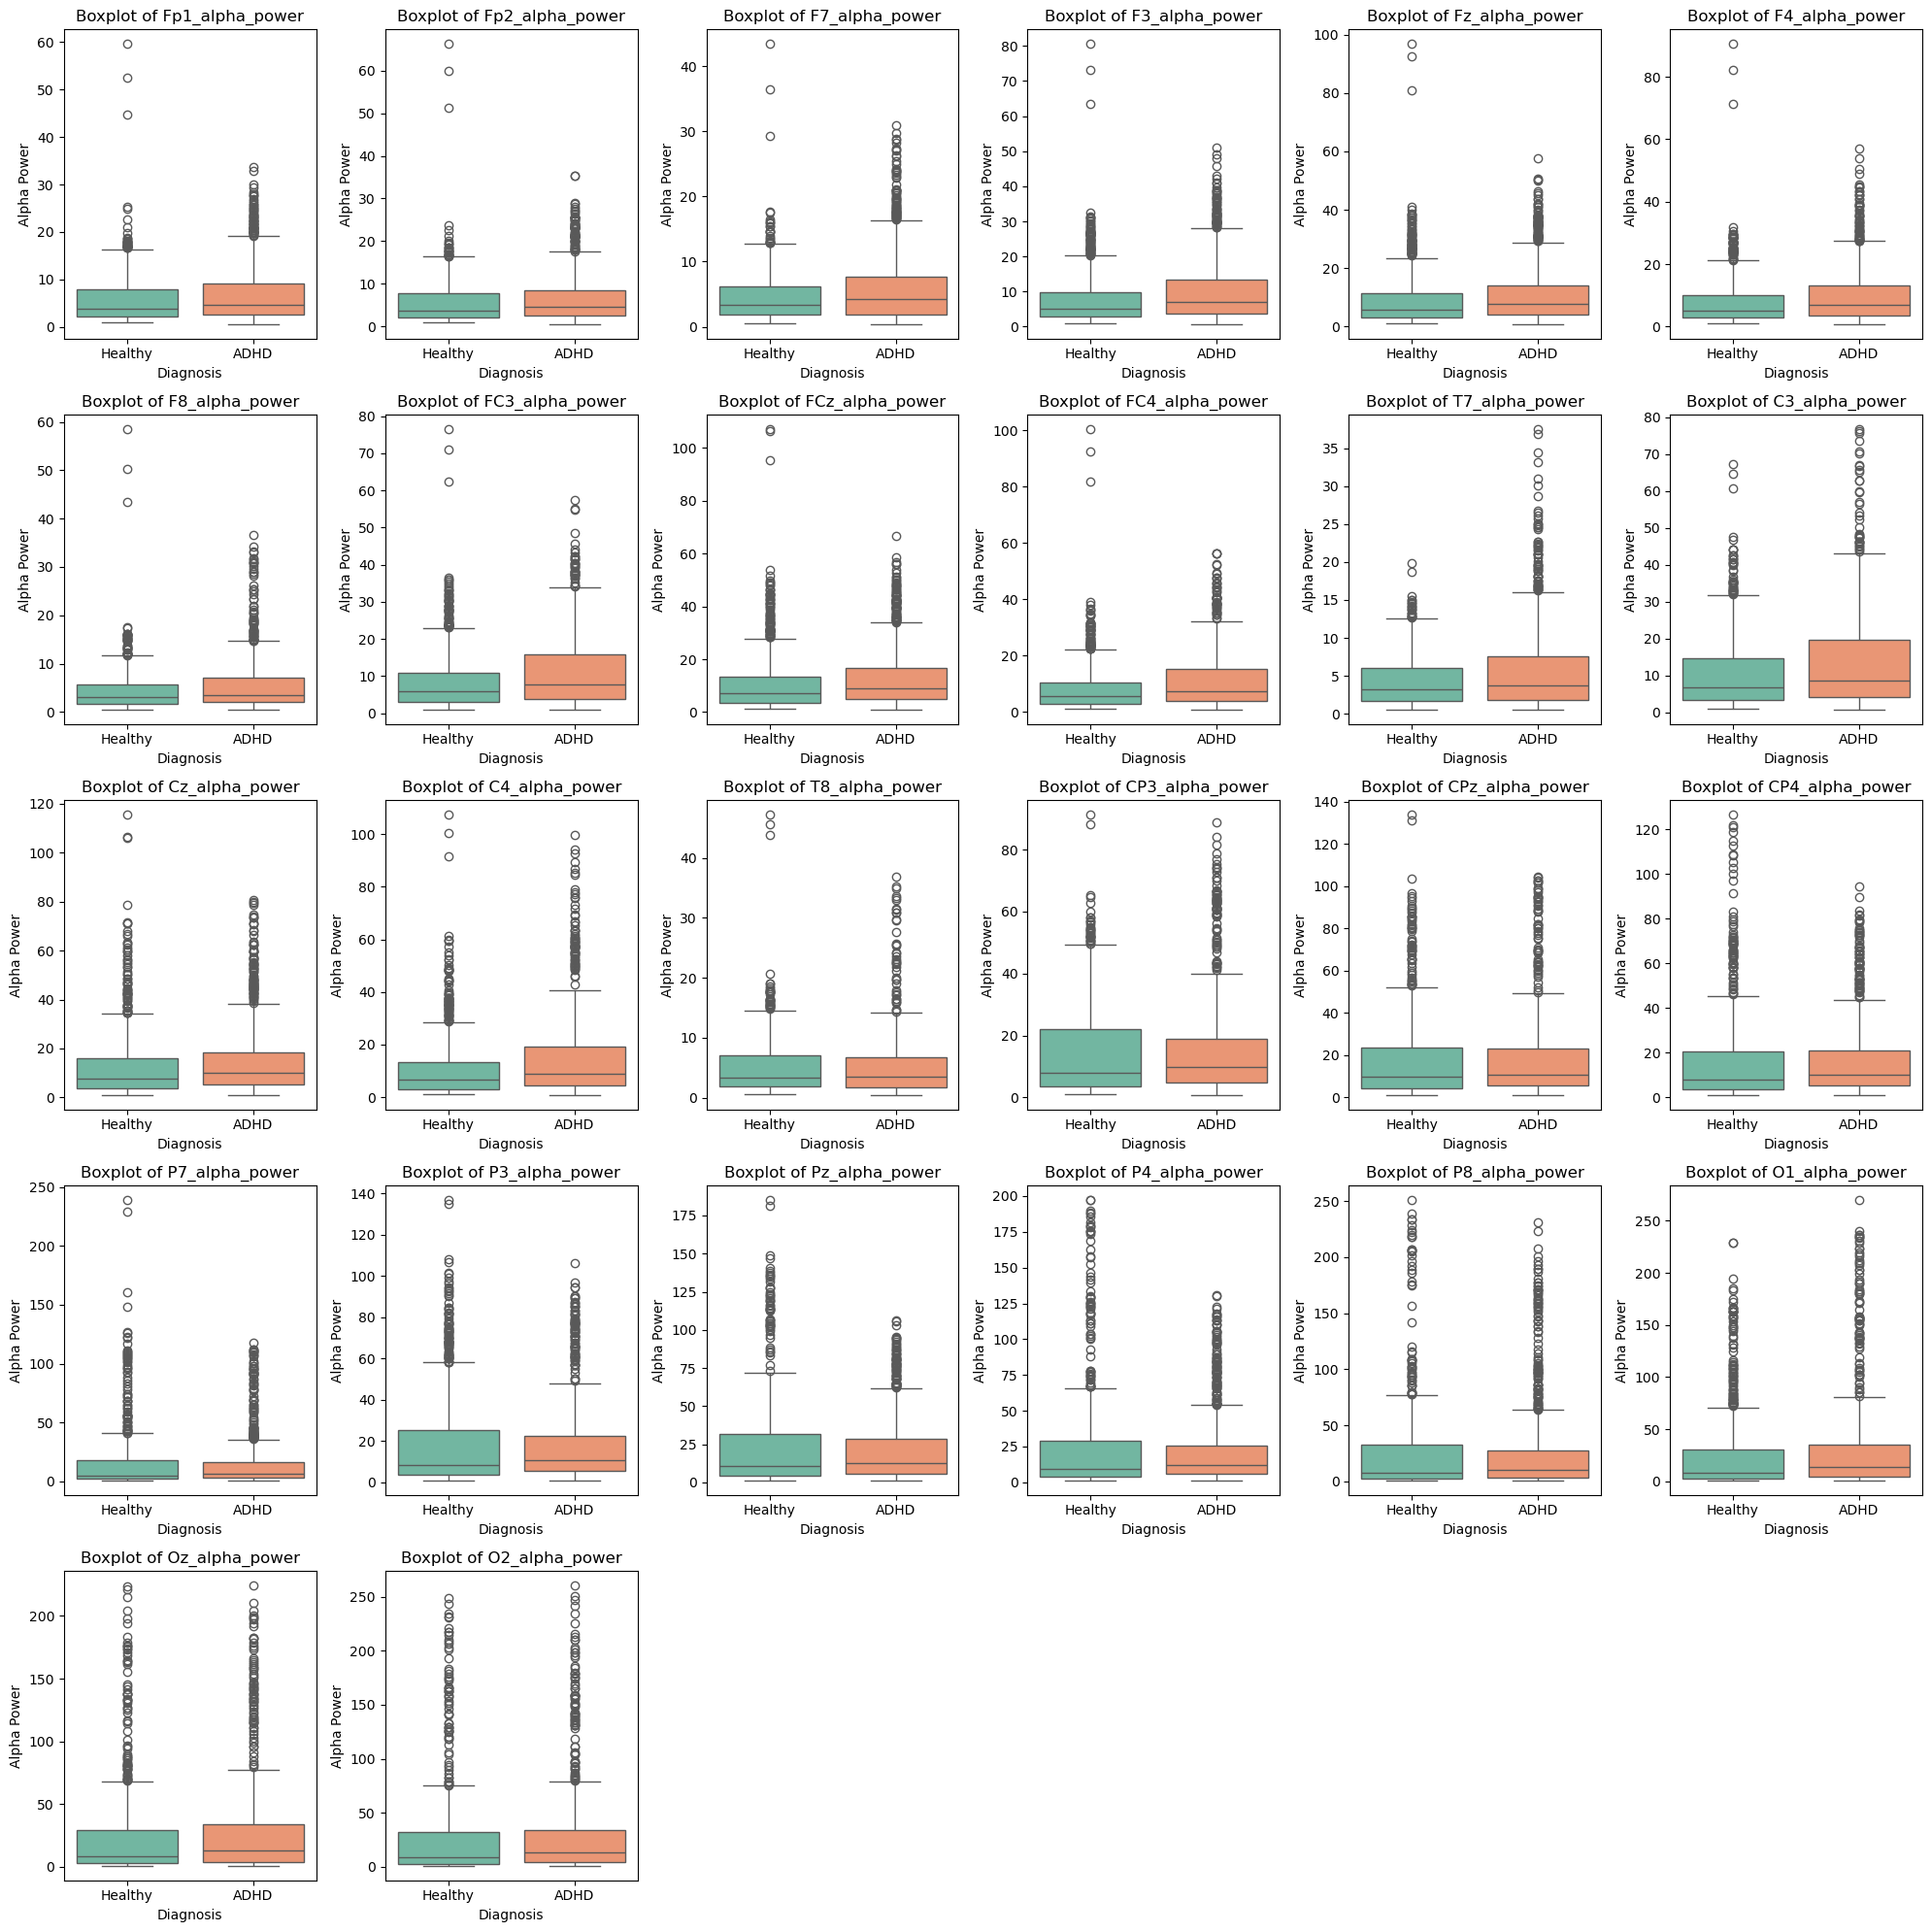

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


alpha_columns = alpha_powers.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(alpha_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=alpha_powers, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Alpha Power')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()


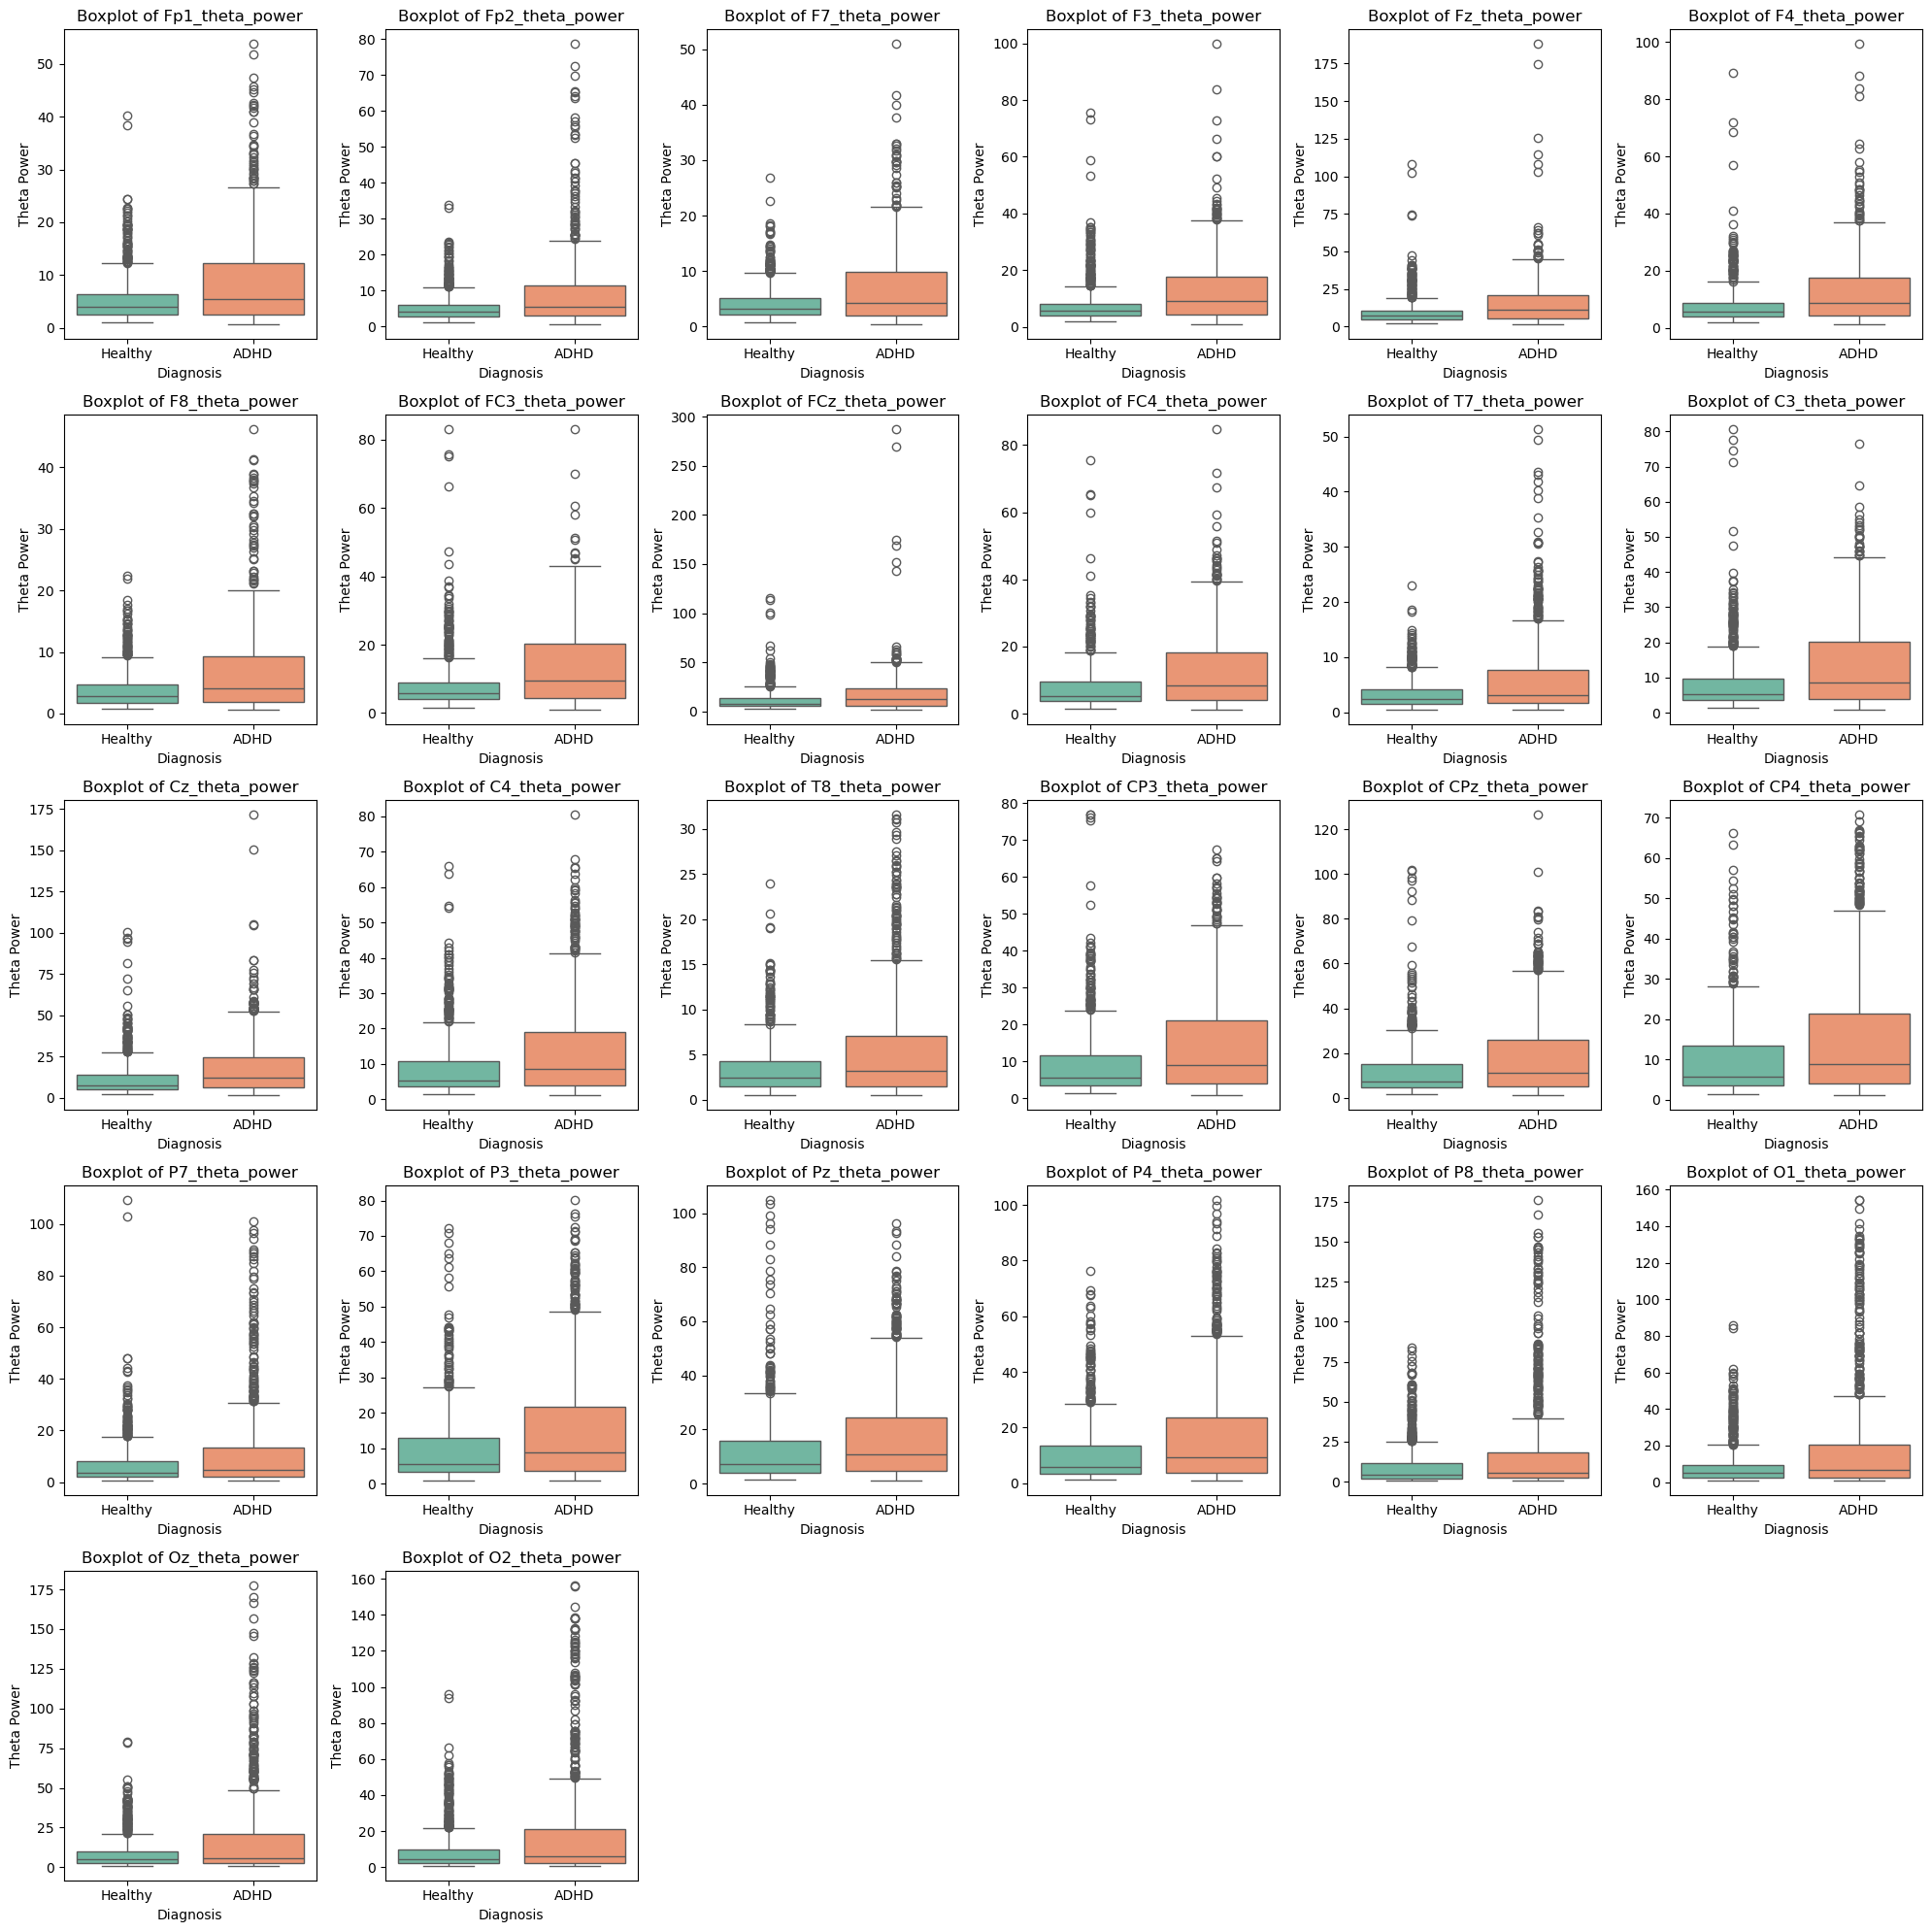

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


theta_columns = theta_powers.columns[:-1]  


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(theta_columns, 1):
    plt.subplot(5, 6, i) 
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=theta_powers, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Theta Power')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

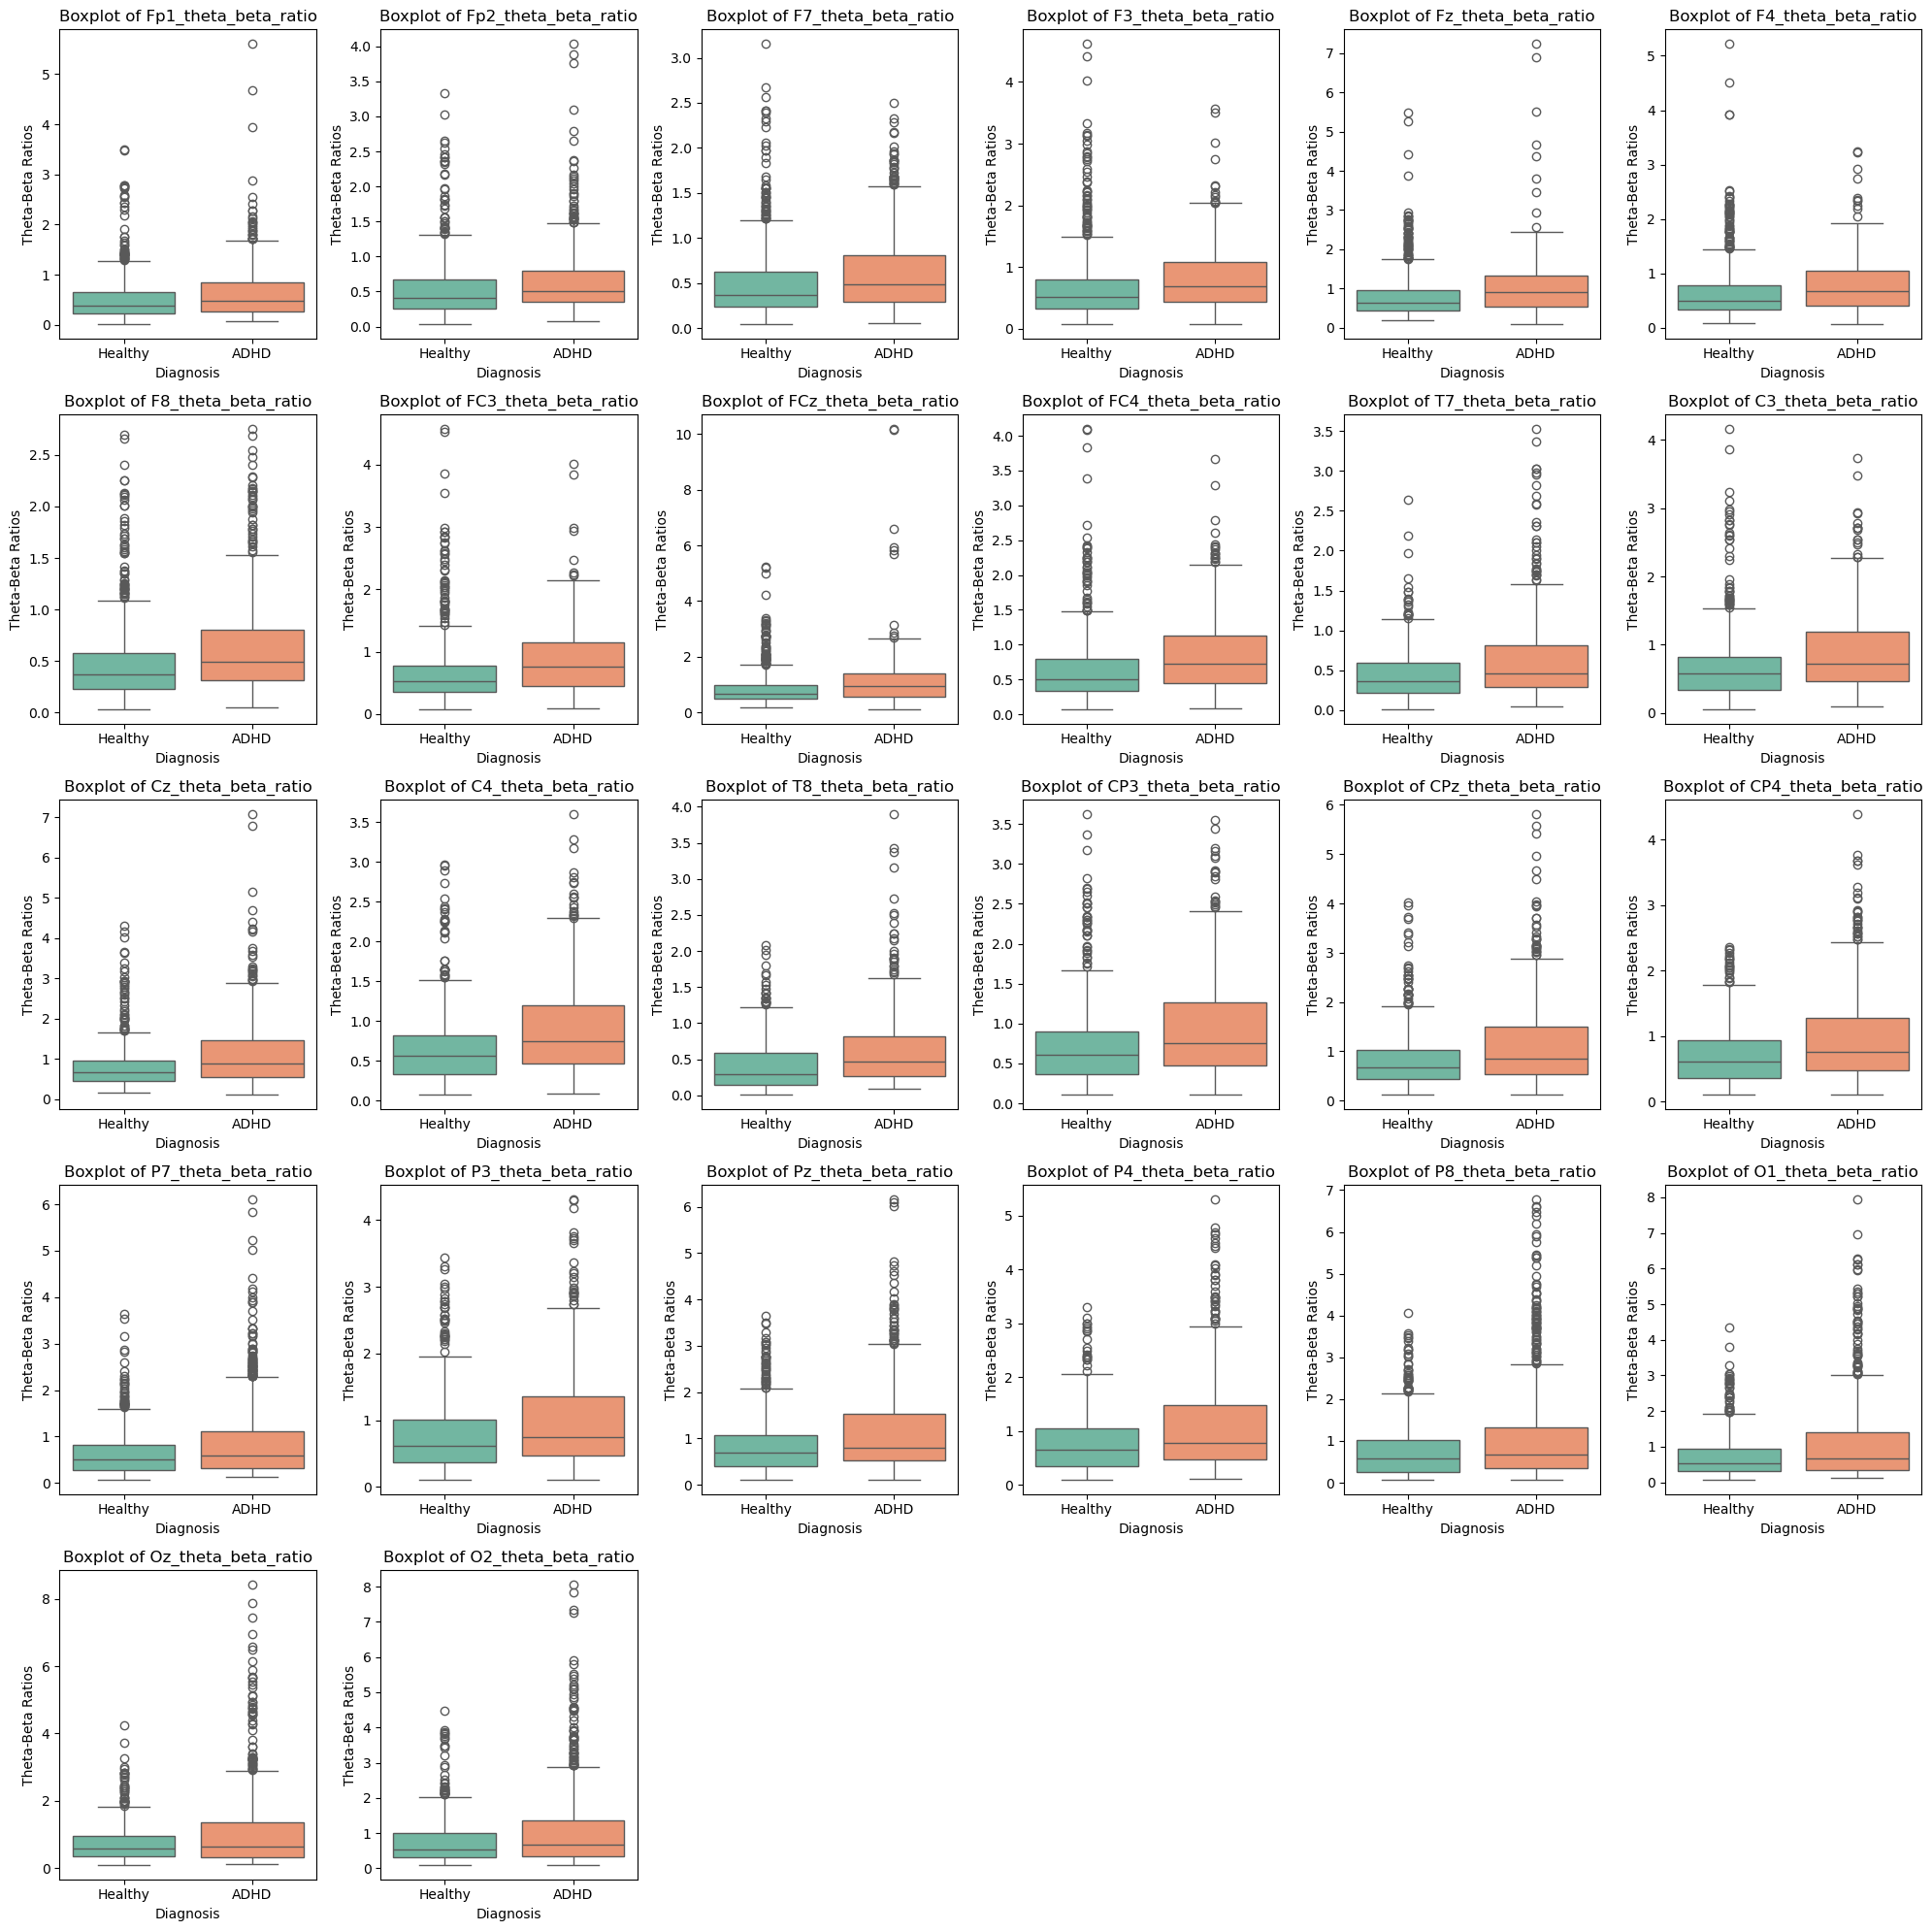

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

theta_beta_columns = theta_beta_ratios.columns[:-1] 

plt.figure(figsize=(20, 20)) 

for i, col in enumerate(theta_beta_columns, 1):
    plt.subplot(5, 6, i)
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=theta_beta_ratios, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Theta-Beta Ratios')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout() 
plt.show()


2. Differences in entropy, standard deviation, skewness, and kurtosis in signals between healthy patients and those with ADHD. 

In [16]:
selected_data = training_df.filter(regex='std_val|kurtosis_val|skewness_val|shannon_entropy_val|spectral_entropy_delta|spectral_entropy_alpha|spectral_entropy_theta|spectral_entropy_beta|spectral_entropy_gamma|wavelet_entropy_val|diagnosis')

In [17]:
std_vals = selected_data.filter(regex="std_val|diagnosis")
kurtosis_vals = selected_data.filter(regex="kurtosis_val|diagnosis")
skewness_vals = selected_data.filter(regex="skewness_val|diagnosis")
shannon_entropy_vals = selected_data.filter(regex="shannon_entropy_val|diagnosis")
spectral_entropy_delta_vals = selected_data.filter(regex="spectral_entropy_delta|diagnosis")
spectral_entropy_alpha_vals = selected_data.filter(regex="spectral_entropy_alpha|diagnosis")
spectral_entropy_theta_vals = selected_data.filter(regex="spectral_entropy_theta|diagnosis")
spectral_entropy_gamma_vals = selected_data.filter(regex="spectral_entropy_gamma|diagnosis")
wavelet_entropy_vals = selected_data.filter(regex="wavelet_entropy_val|diagnosis")

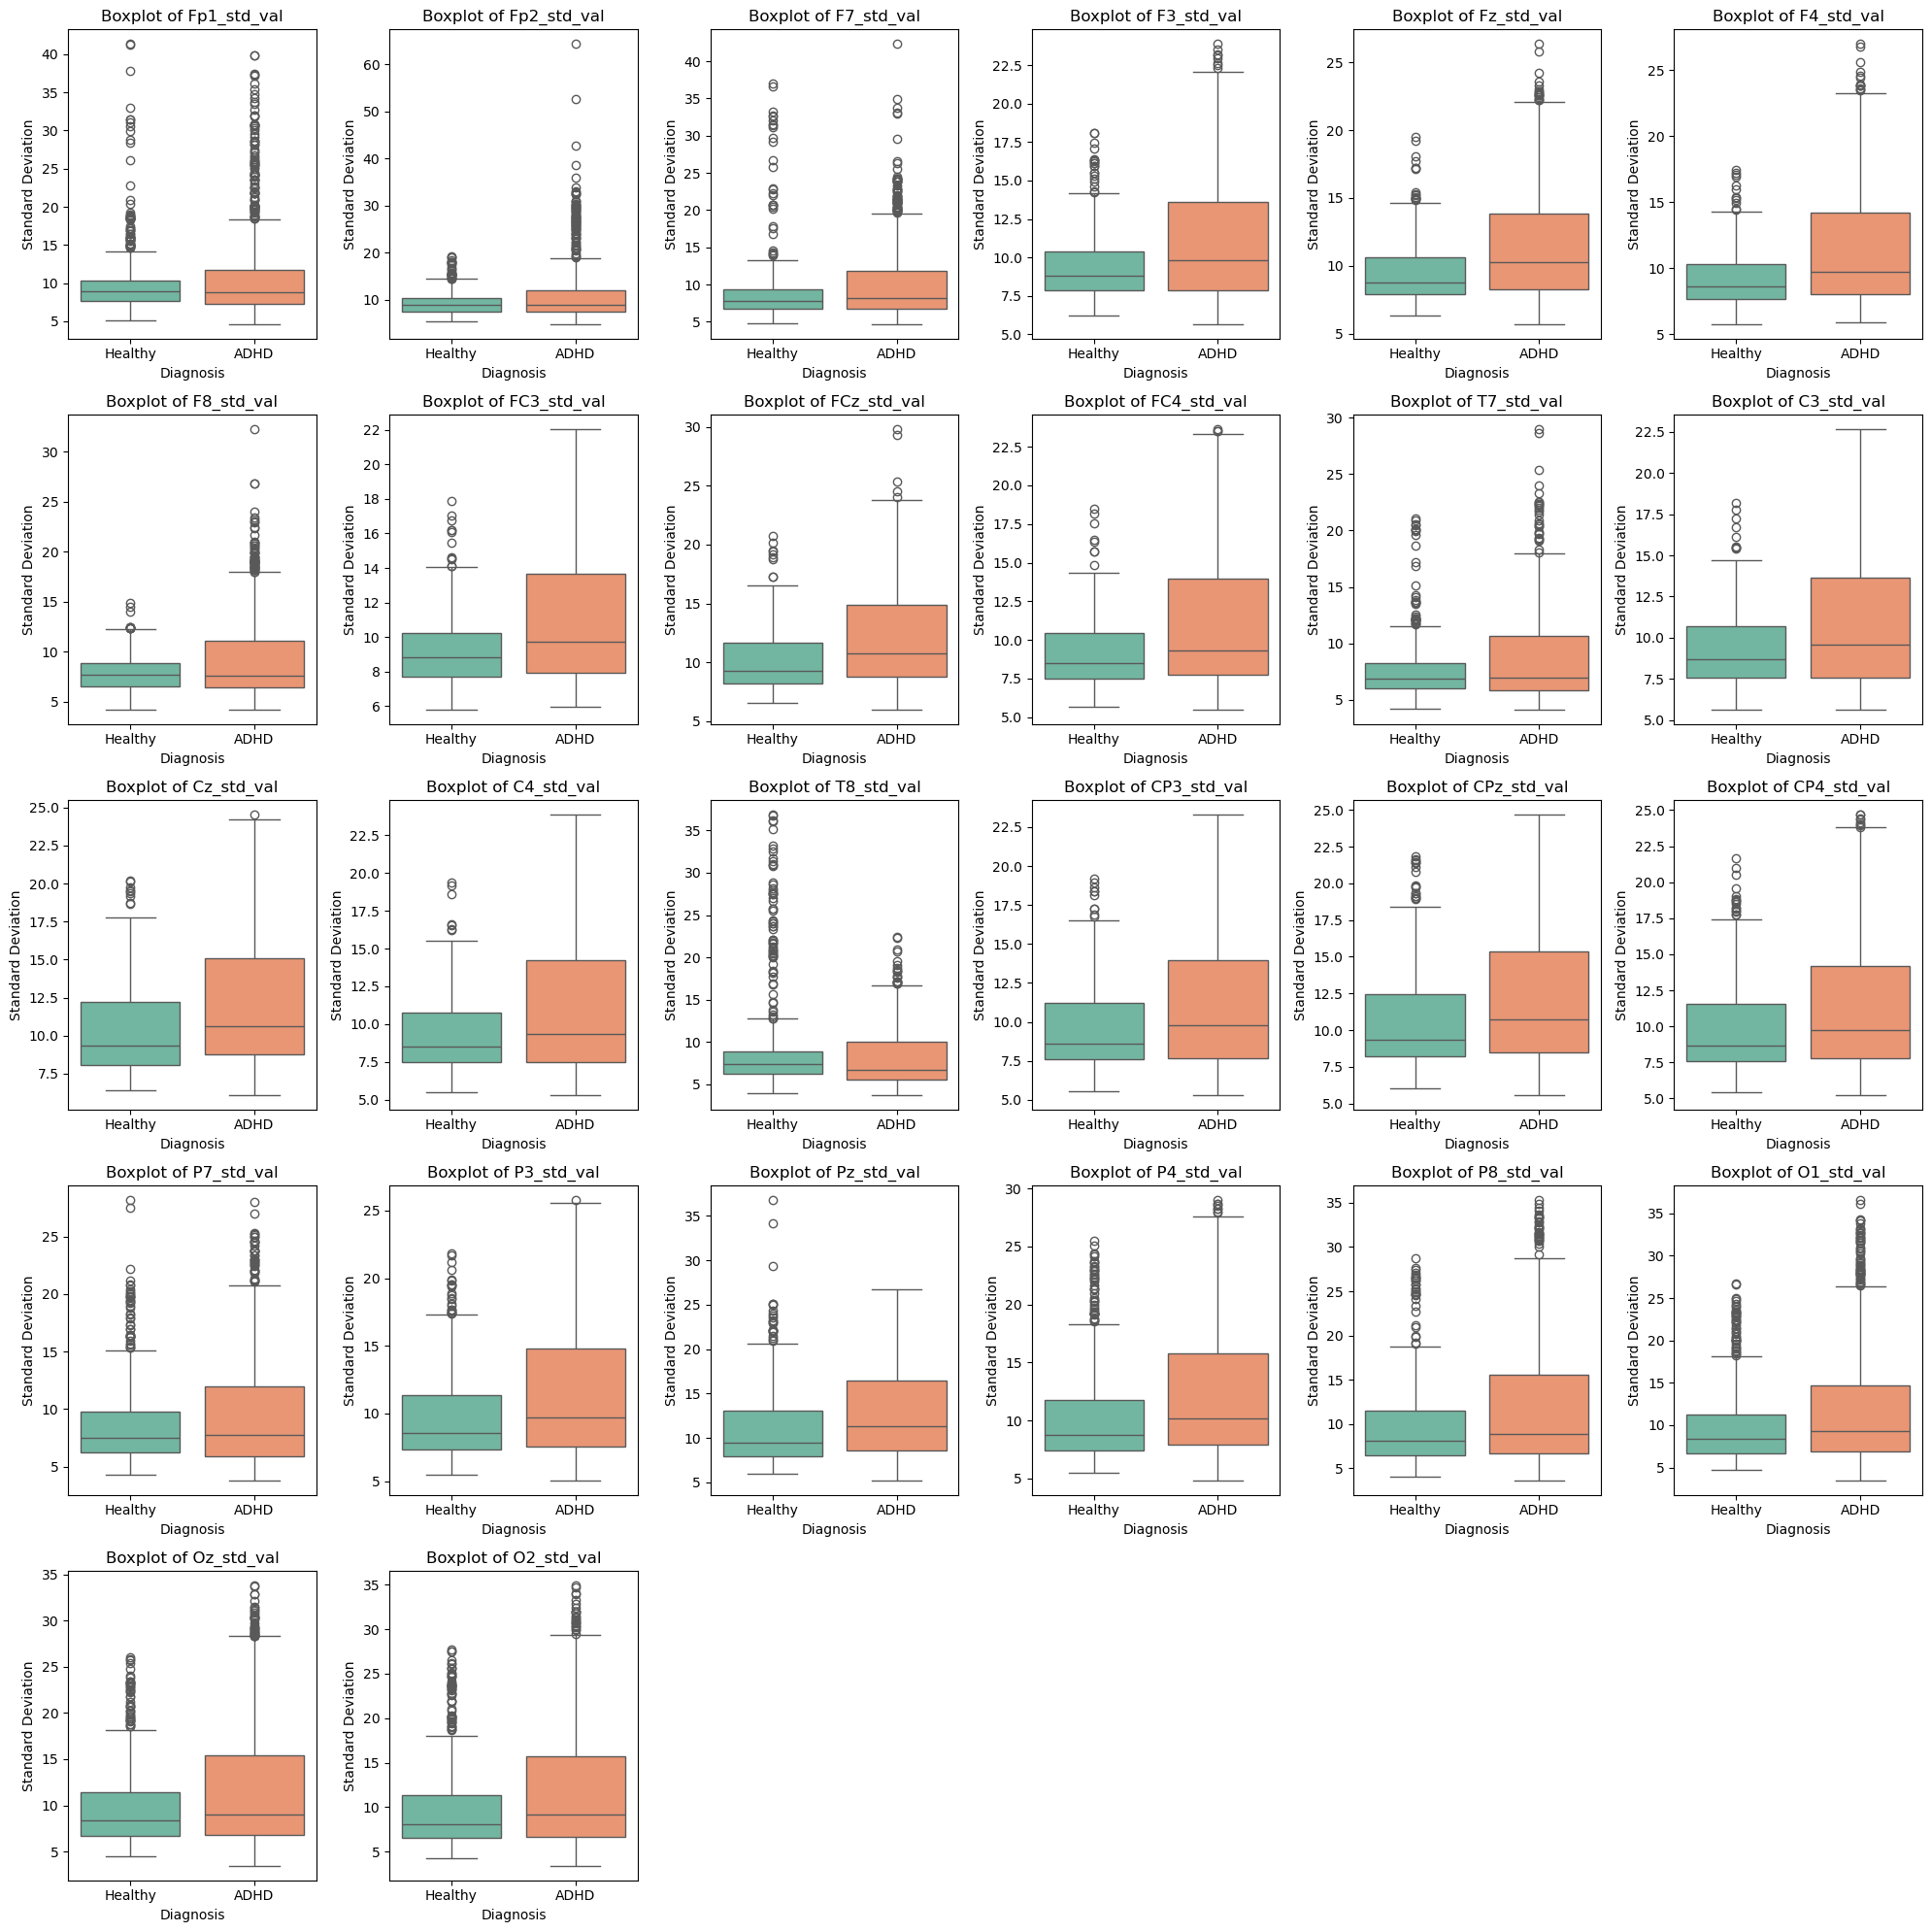

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


std_columns = std_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(std_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=std_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Standard Deviation')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()


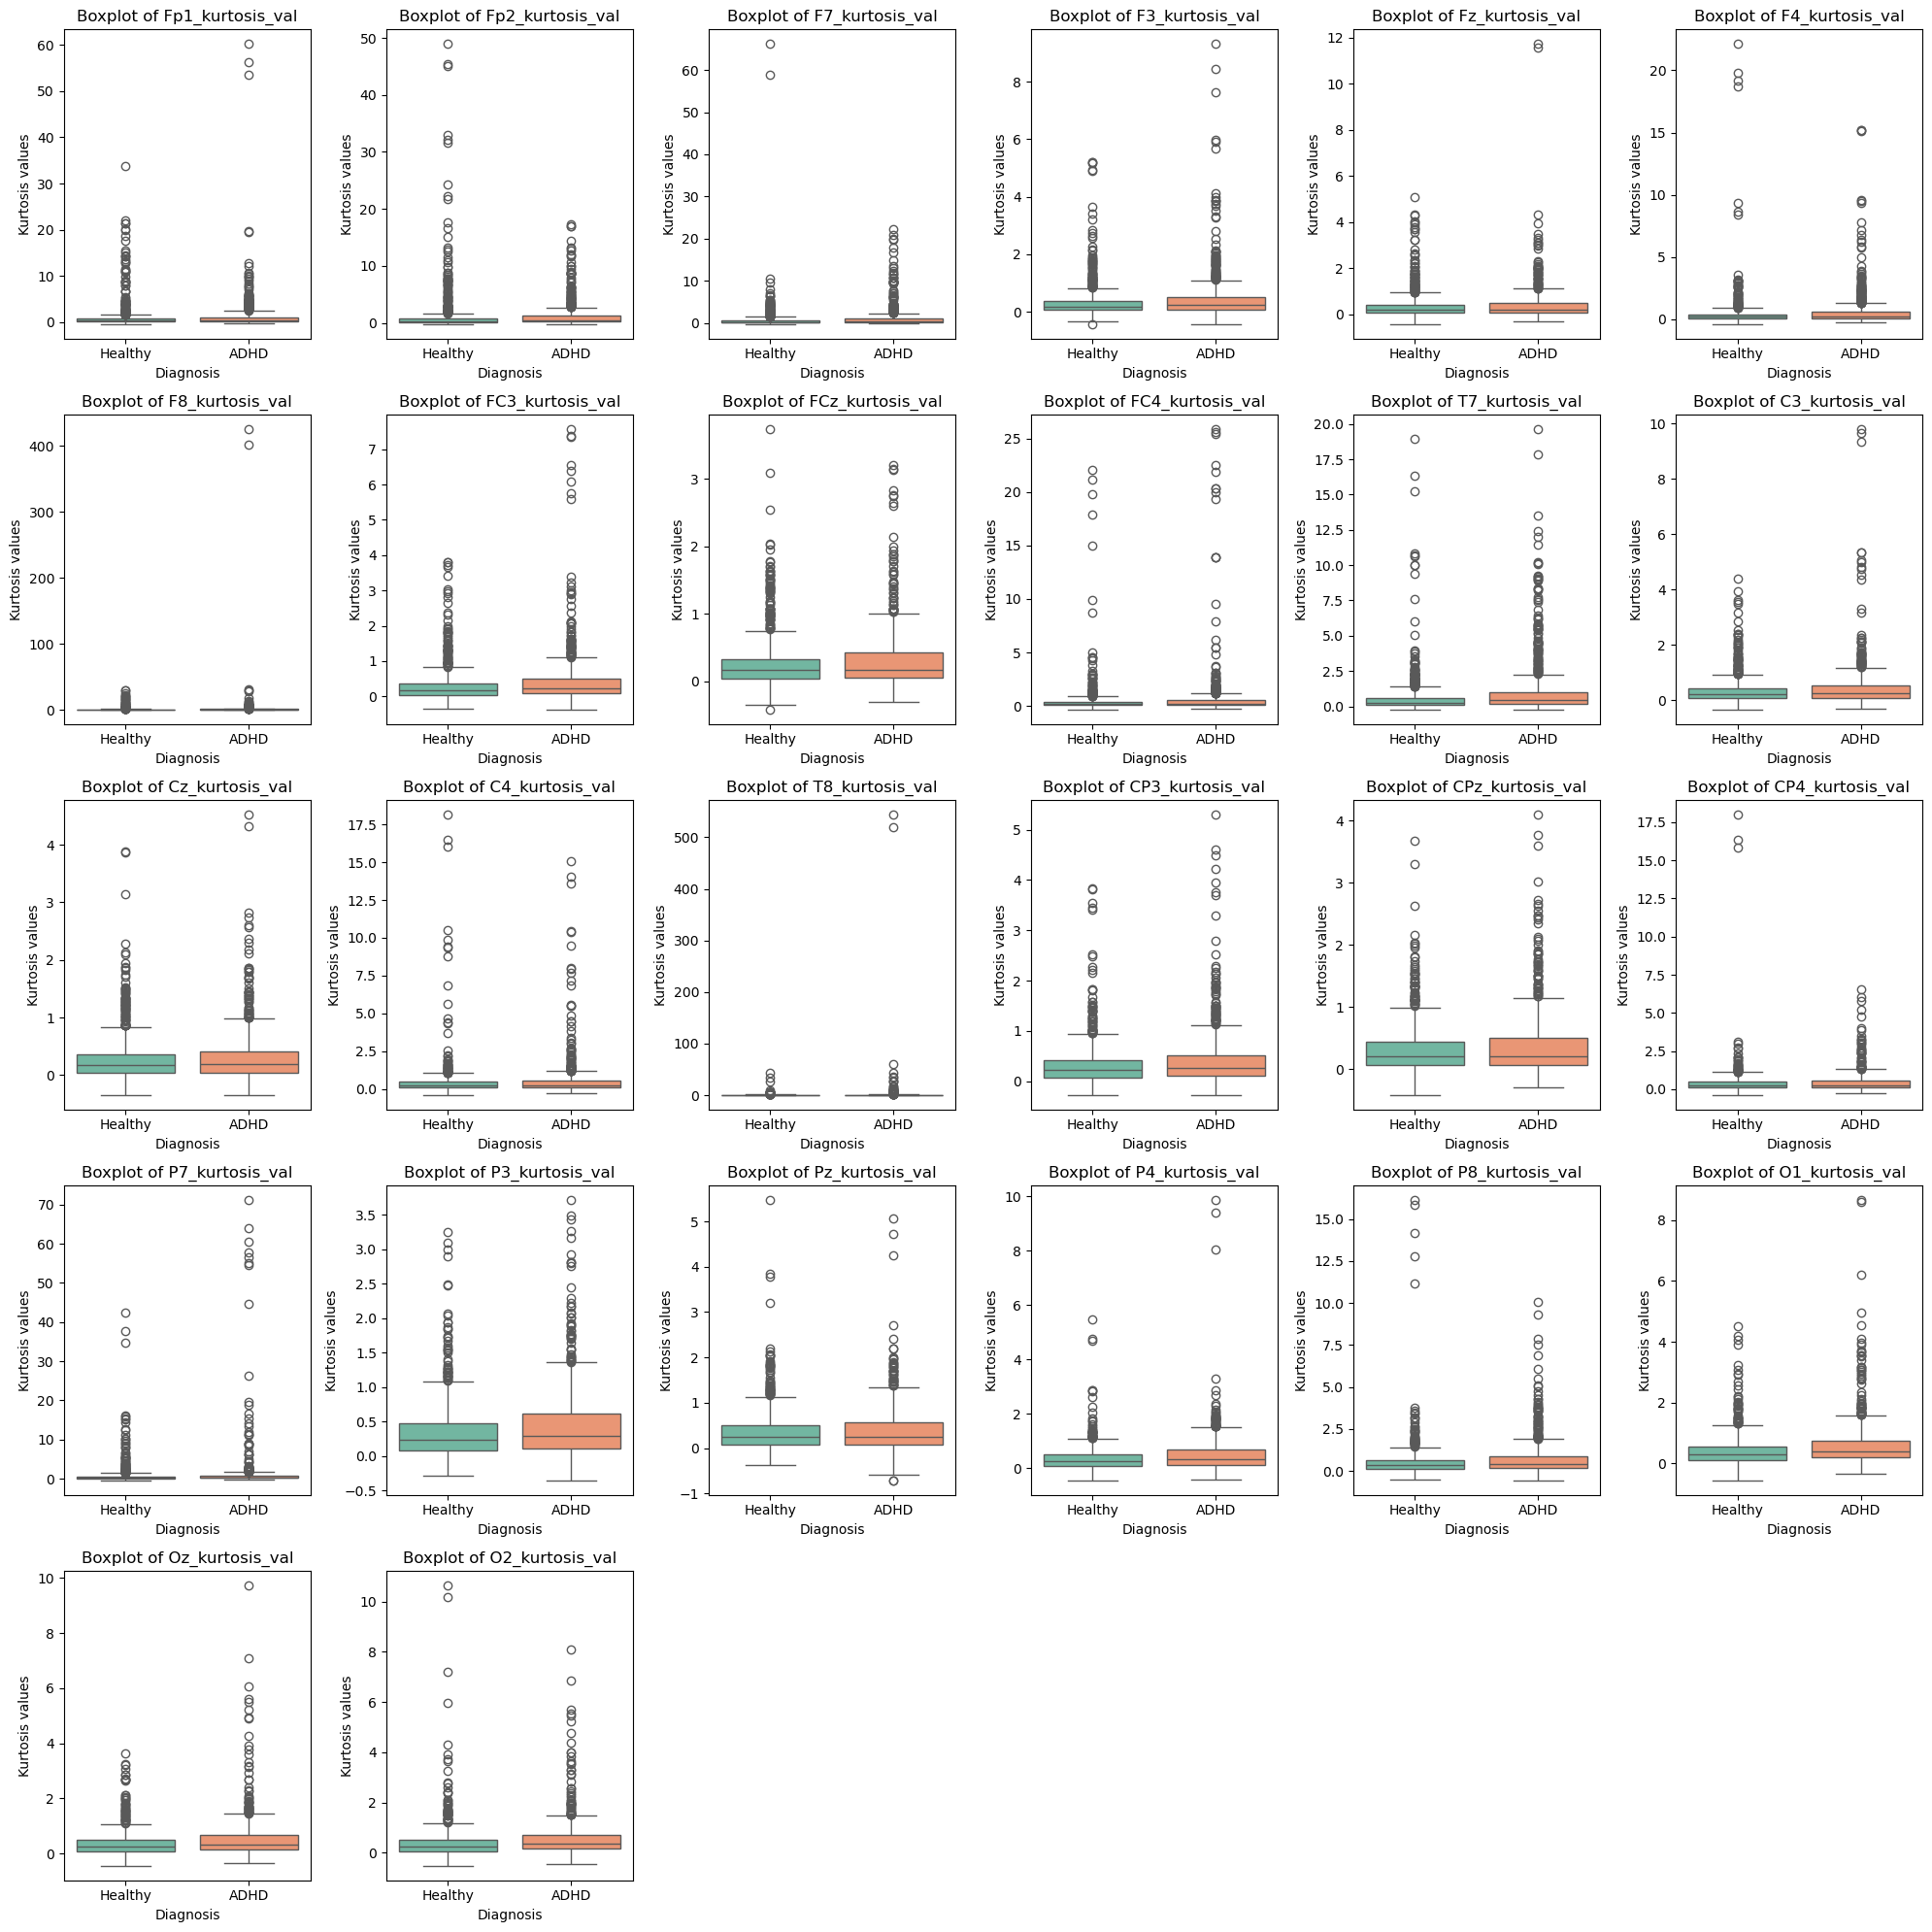

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


kurtosis_columns = kurtosis_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(kurtosis_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=kurtosis_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Kurtosis values')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()


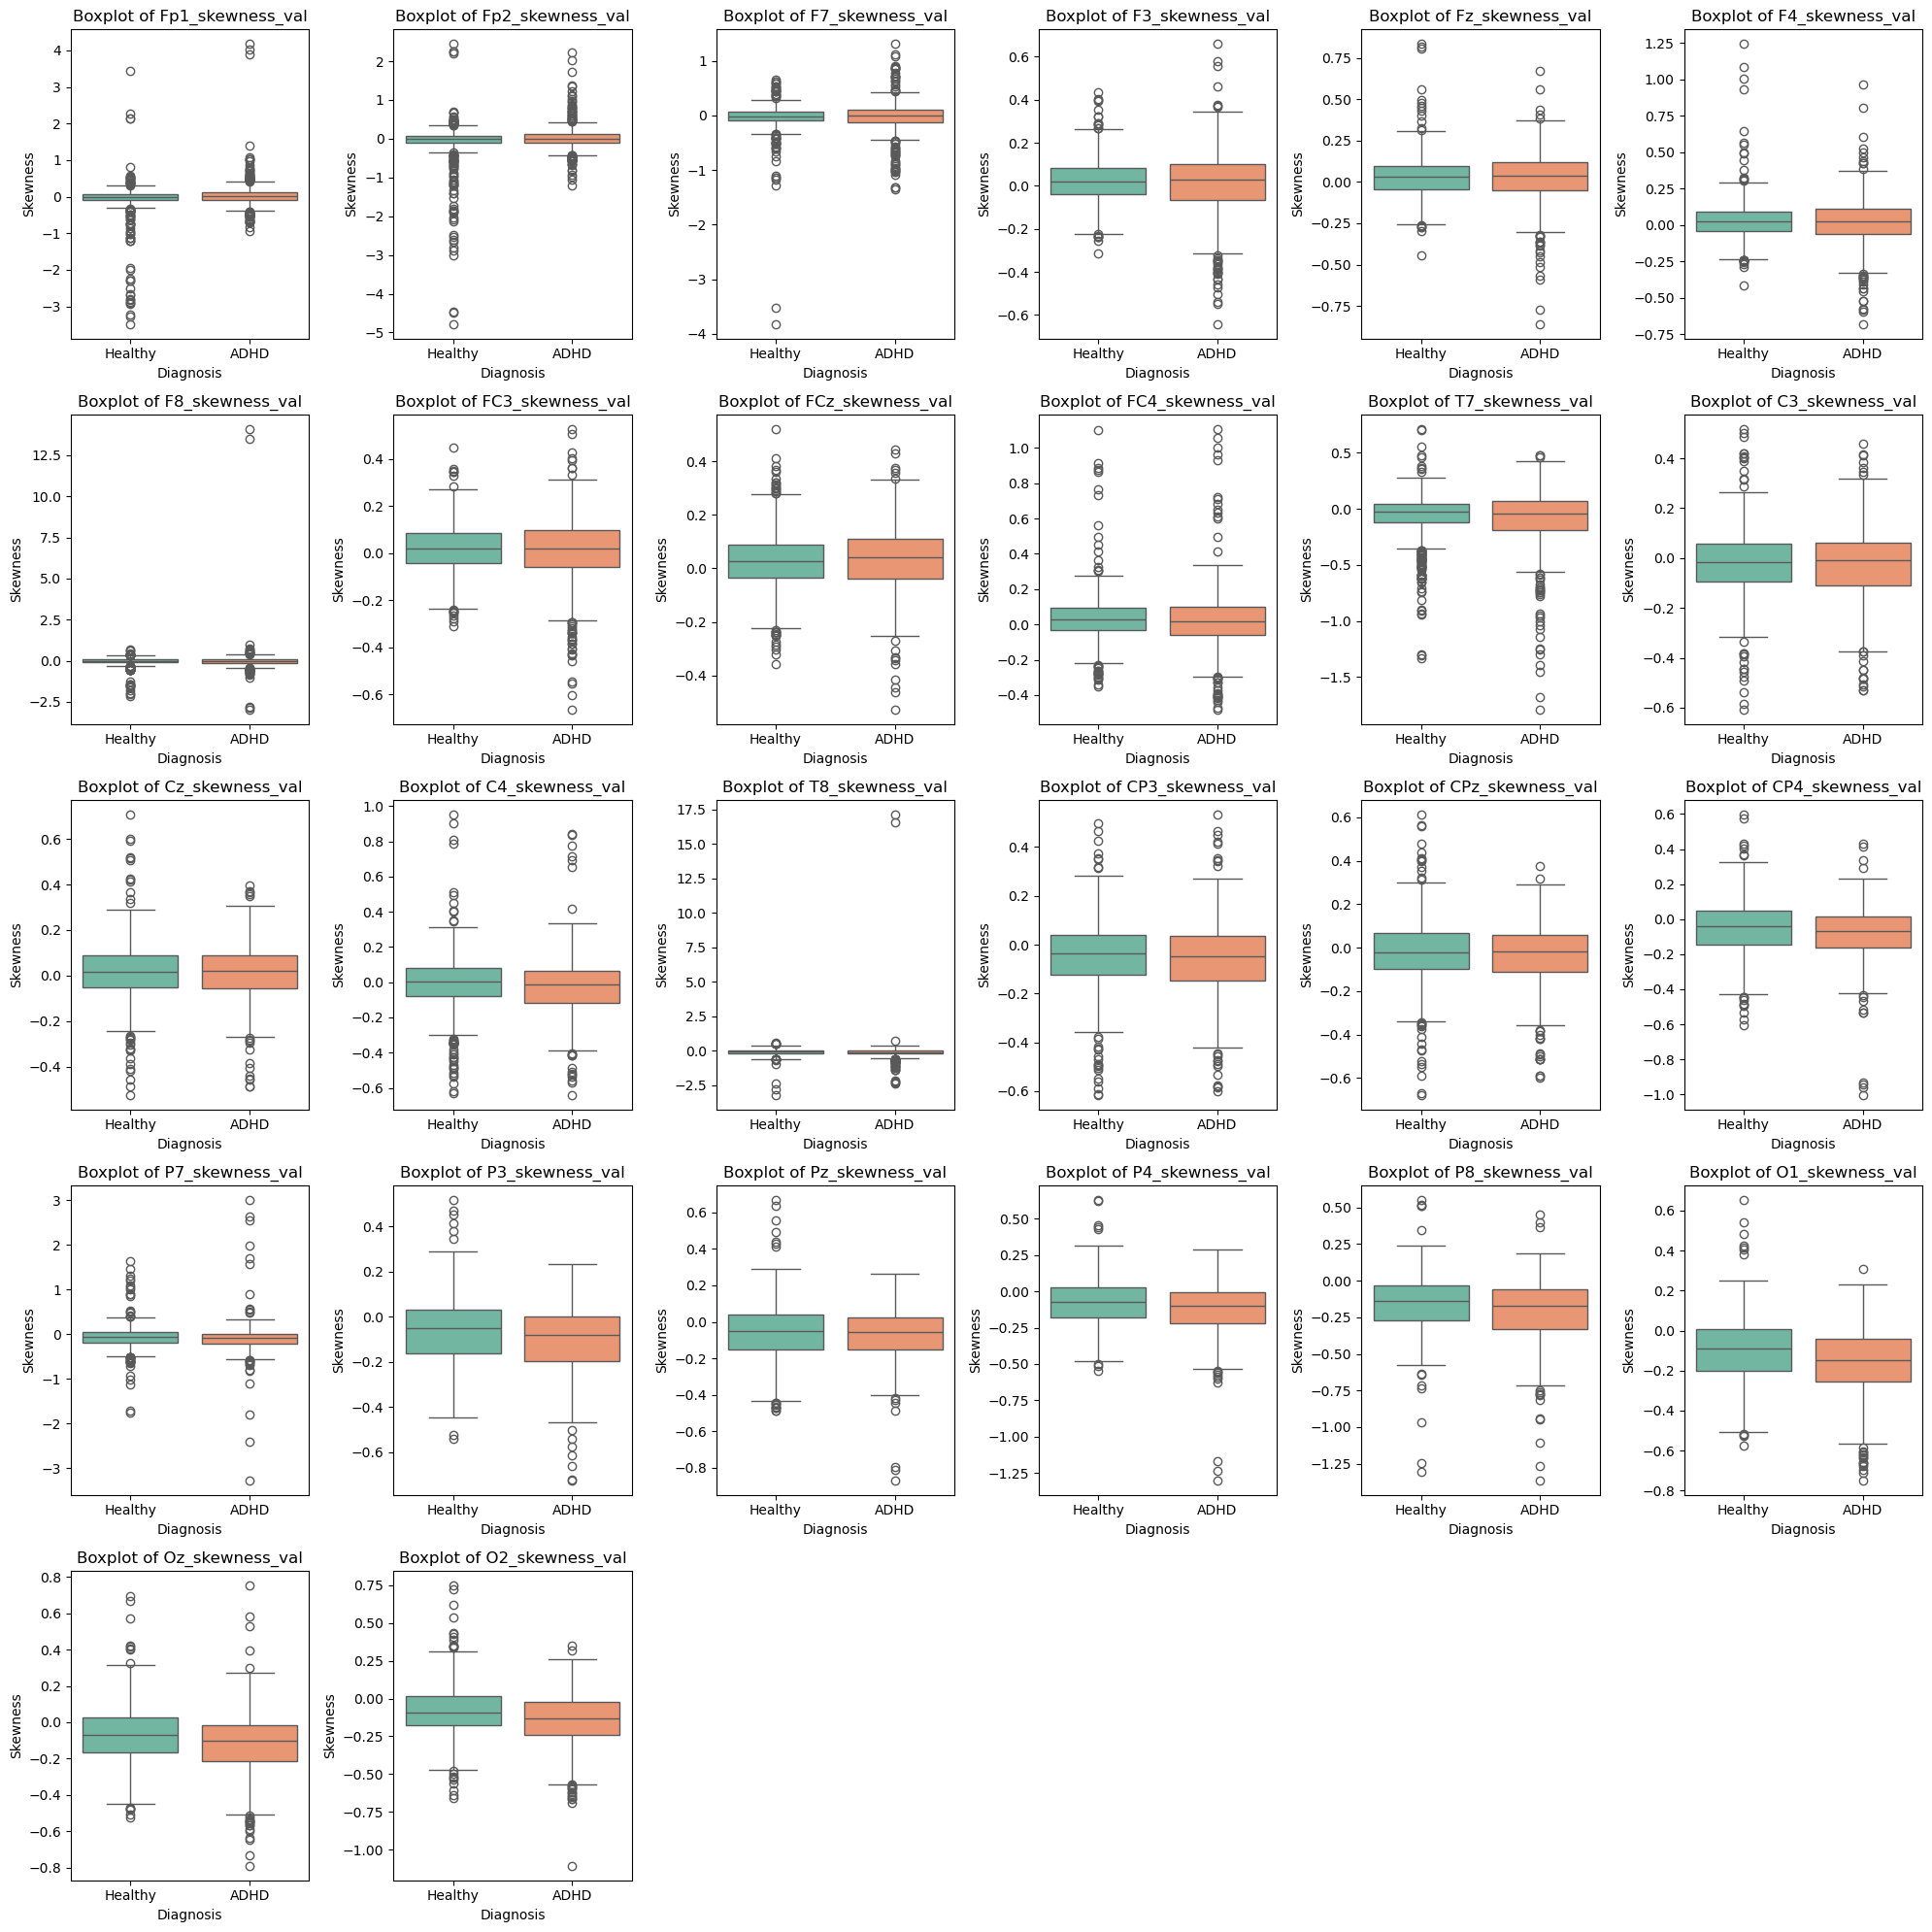

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


skewness_columns = skewness_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(skewness_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=skewness_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Skewness')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()


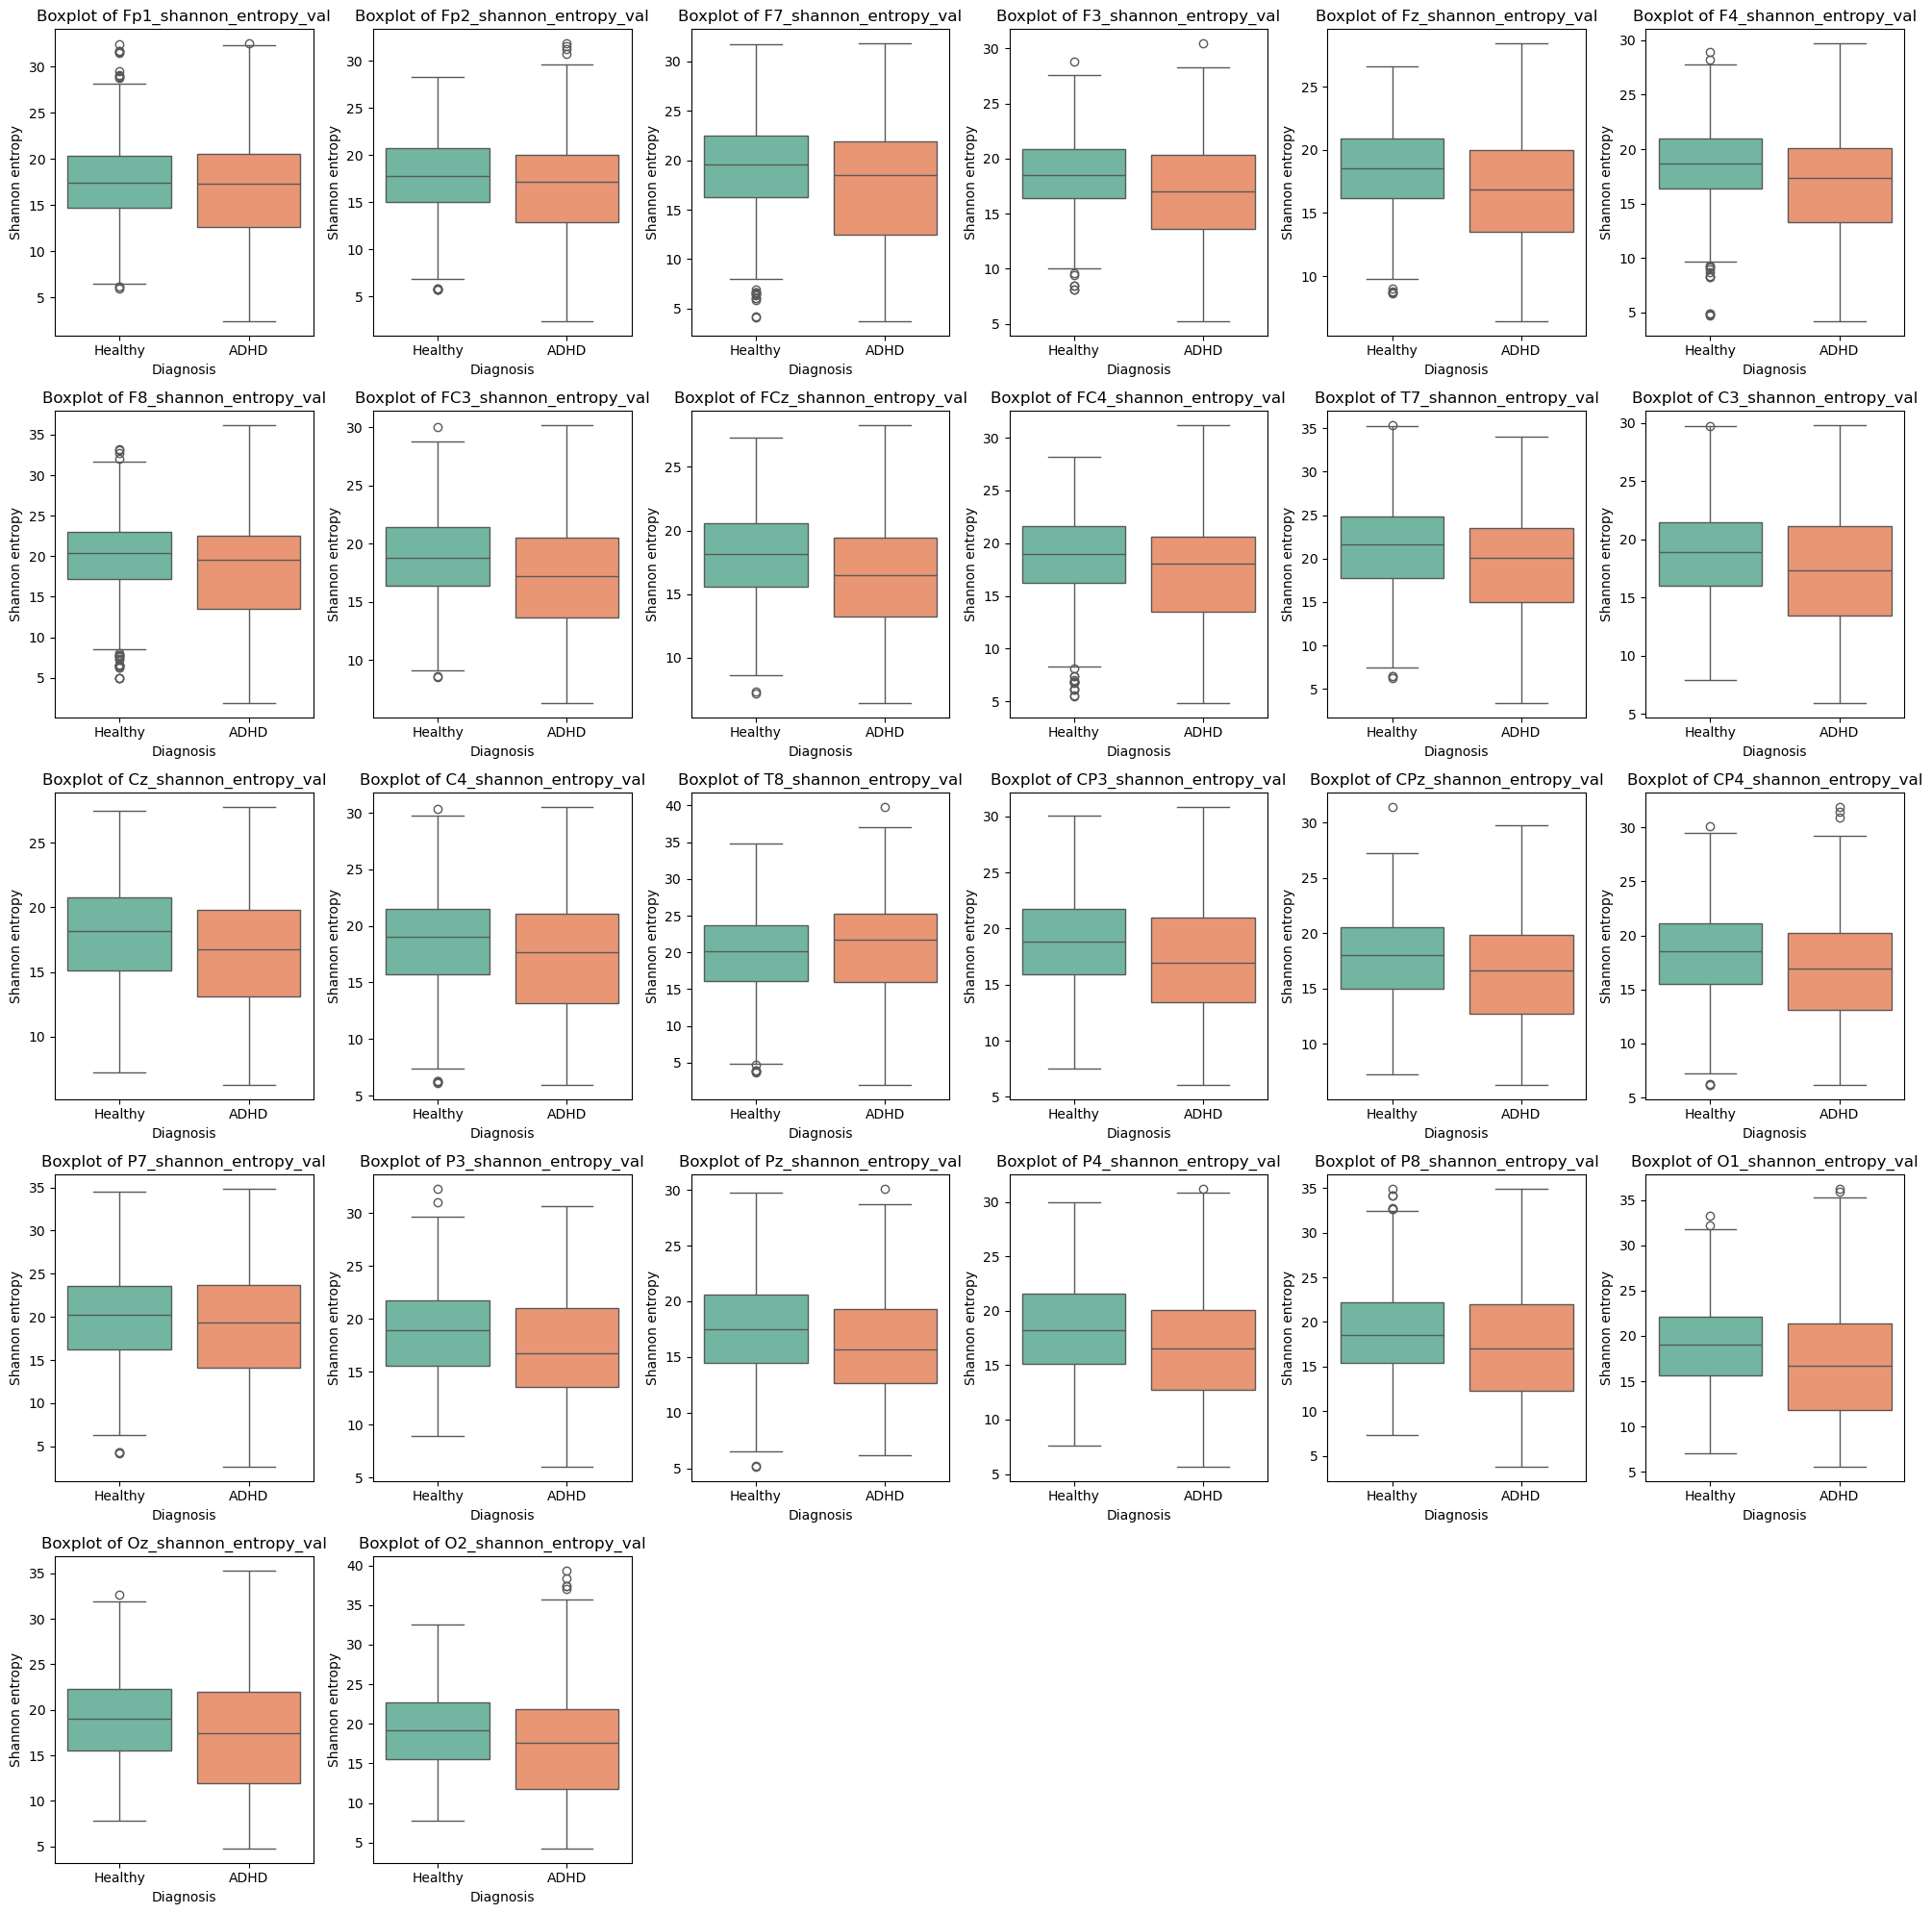

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


shannon_entropy_val_columns = shannon_entropy_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(shannon_entropy_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=shannon_entropy_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Shannon entropy')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

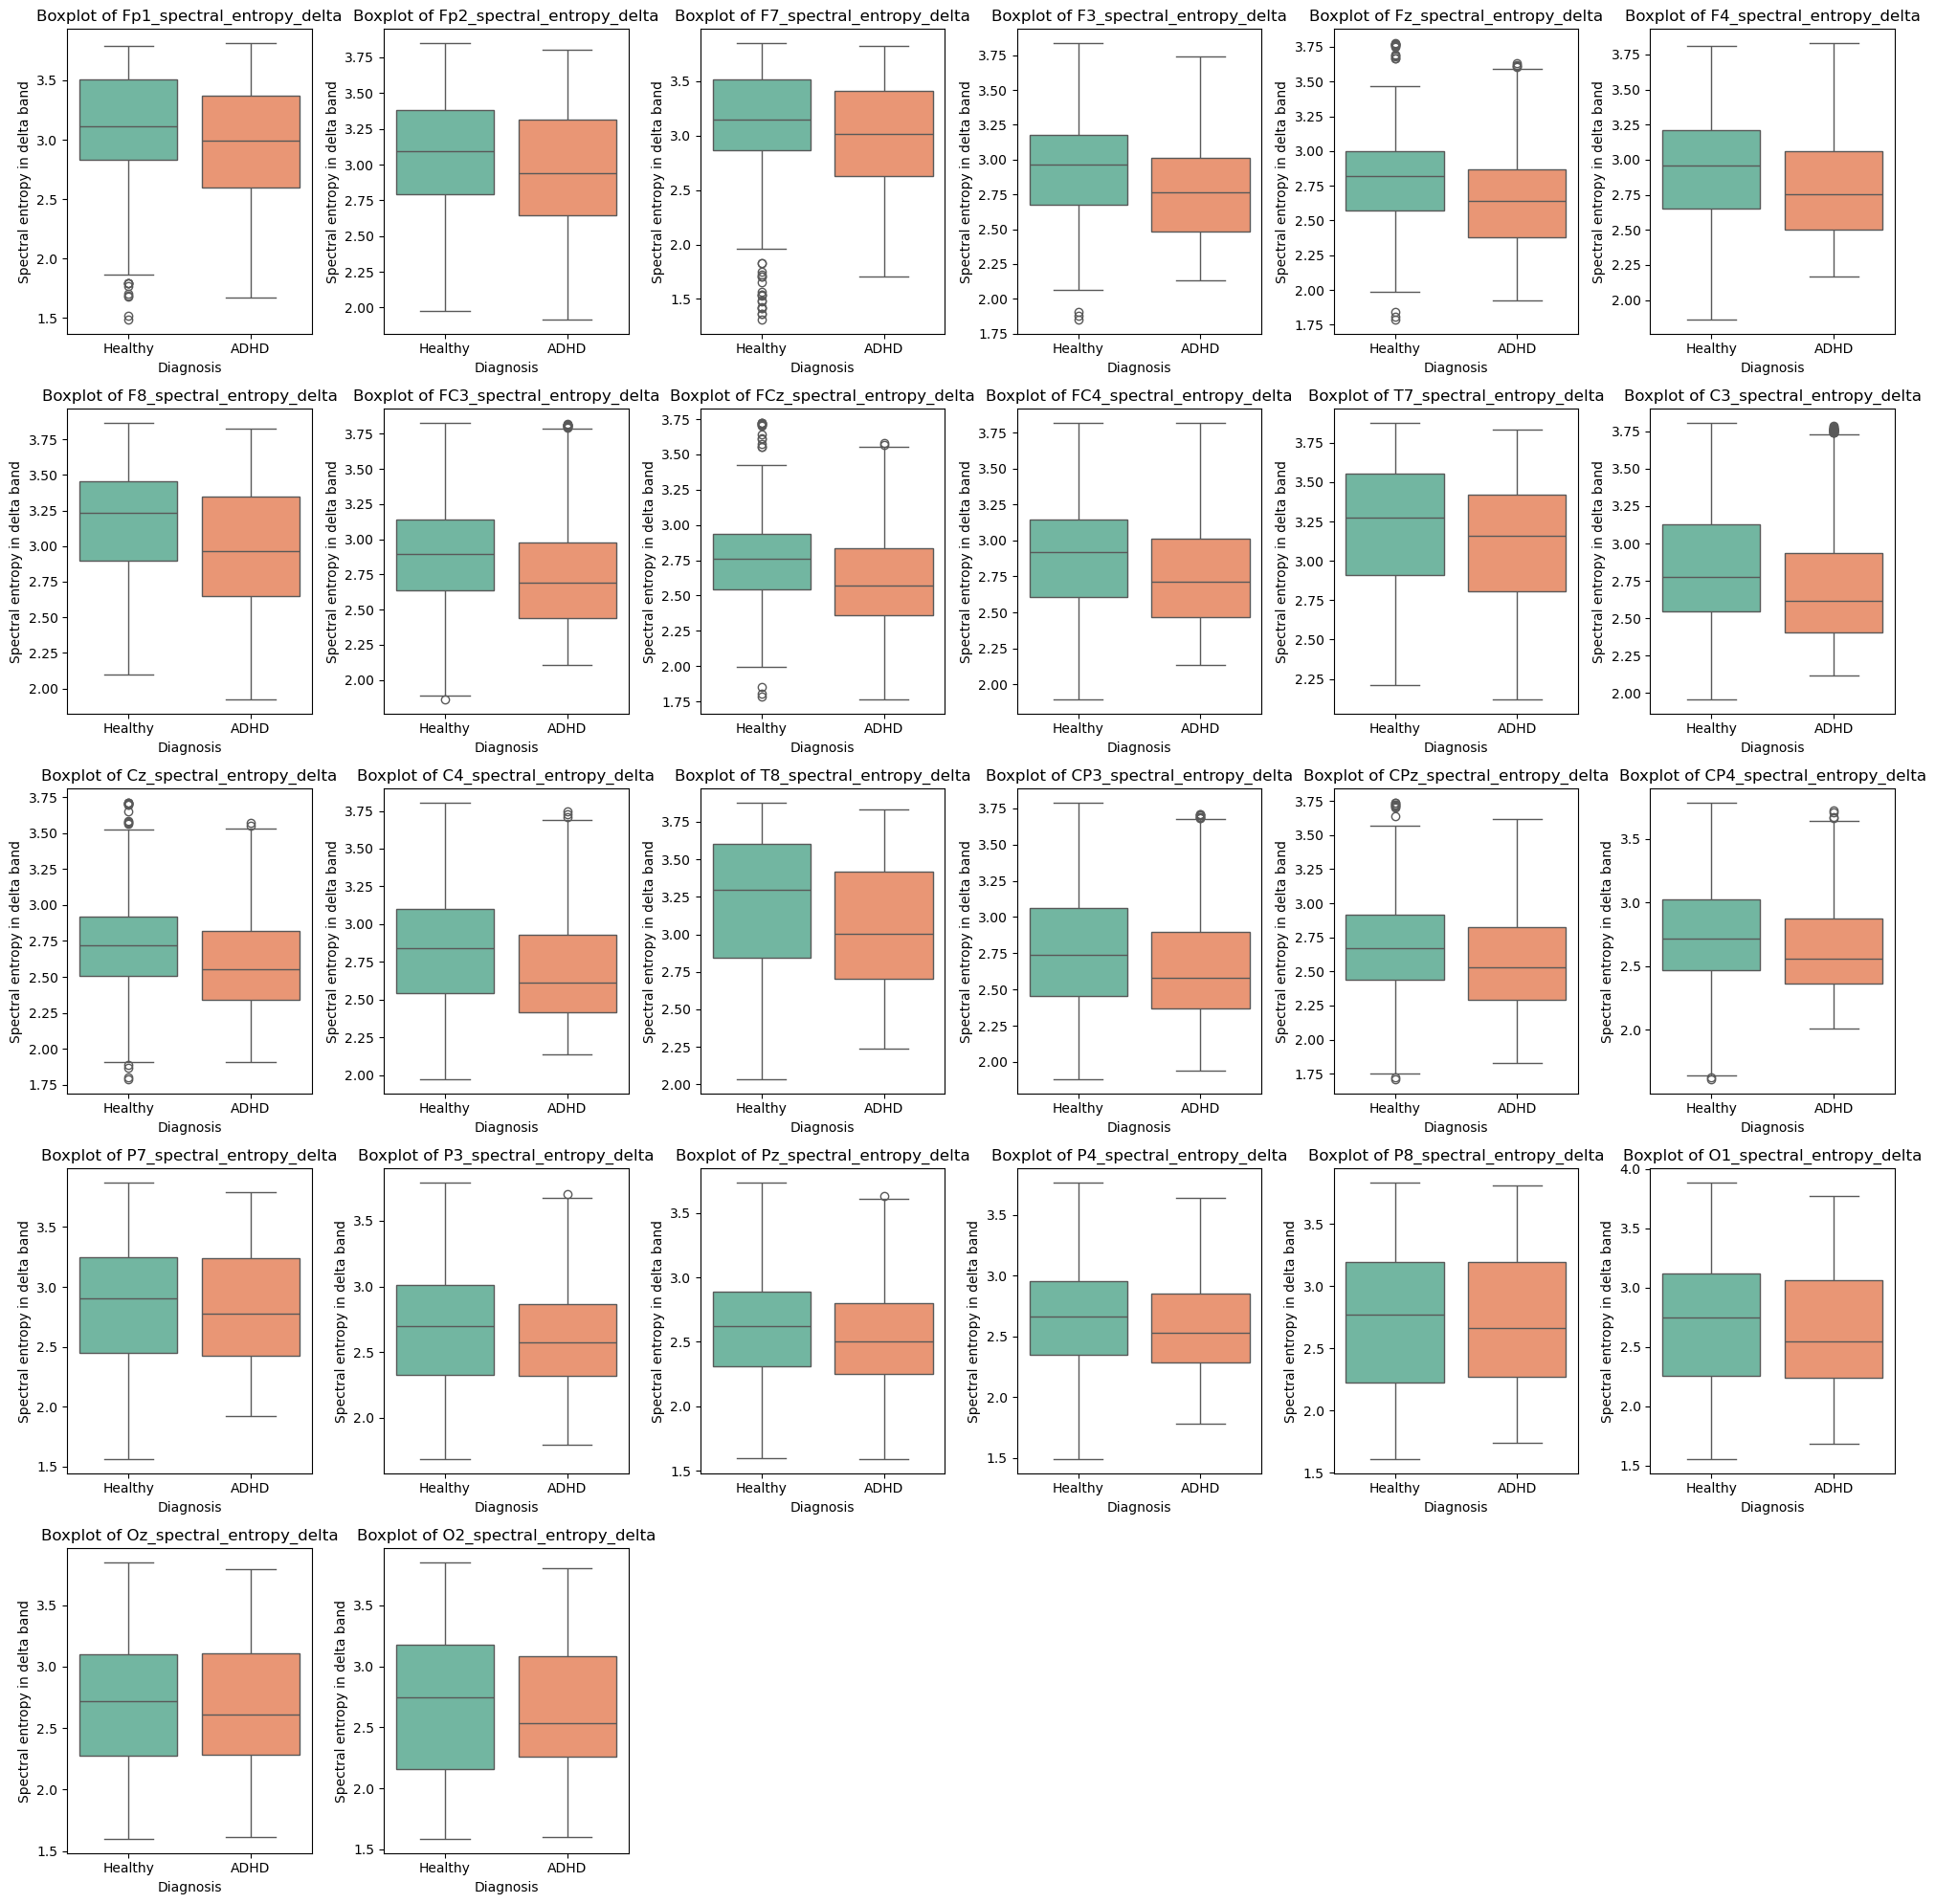

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


spectral_entropy_delta_val_columns = spectral_entropy_delta_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(spectral_entropy_delta_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=spectral_entropy_delta_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Spectral entropy in delta band')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

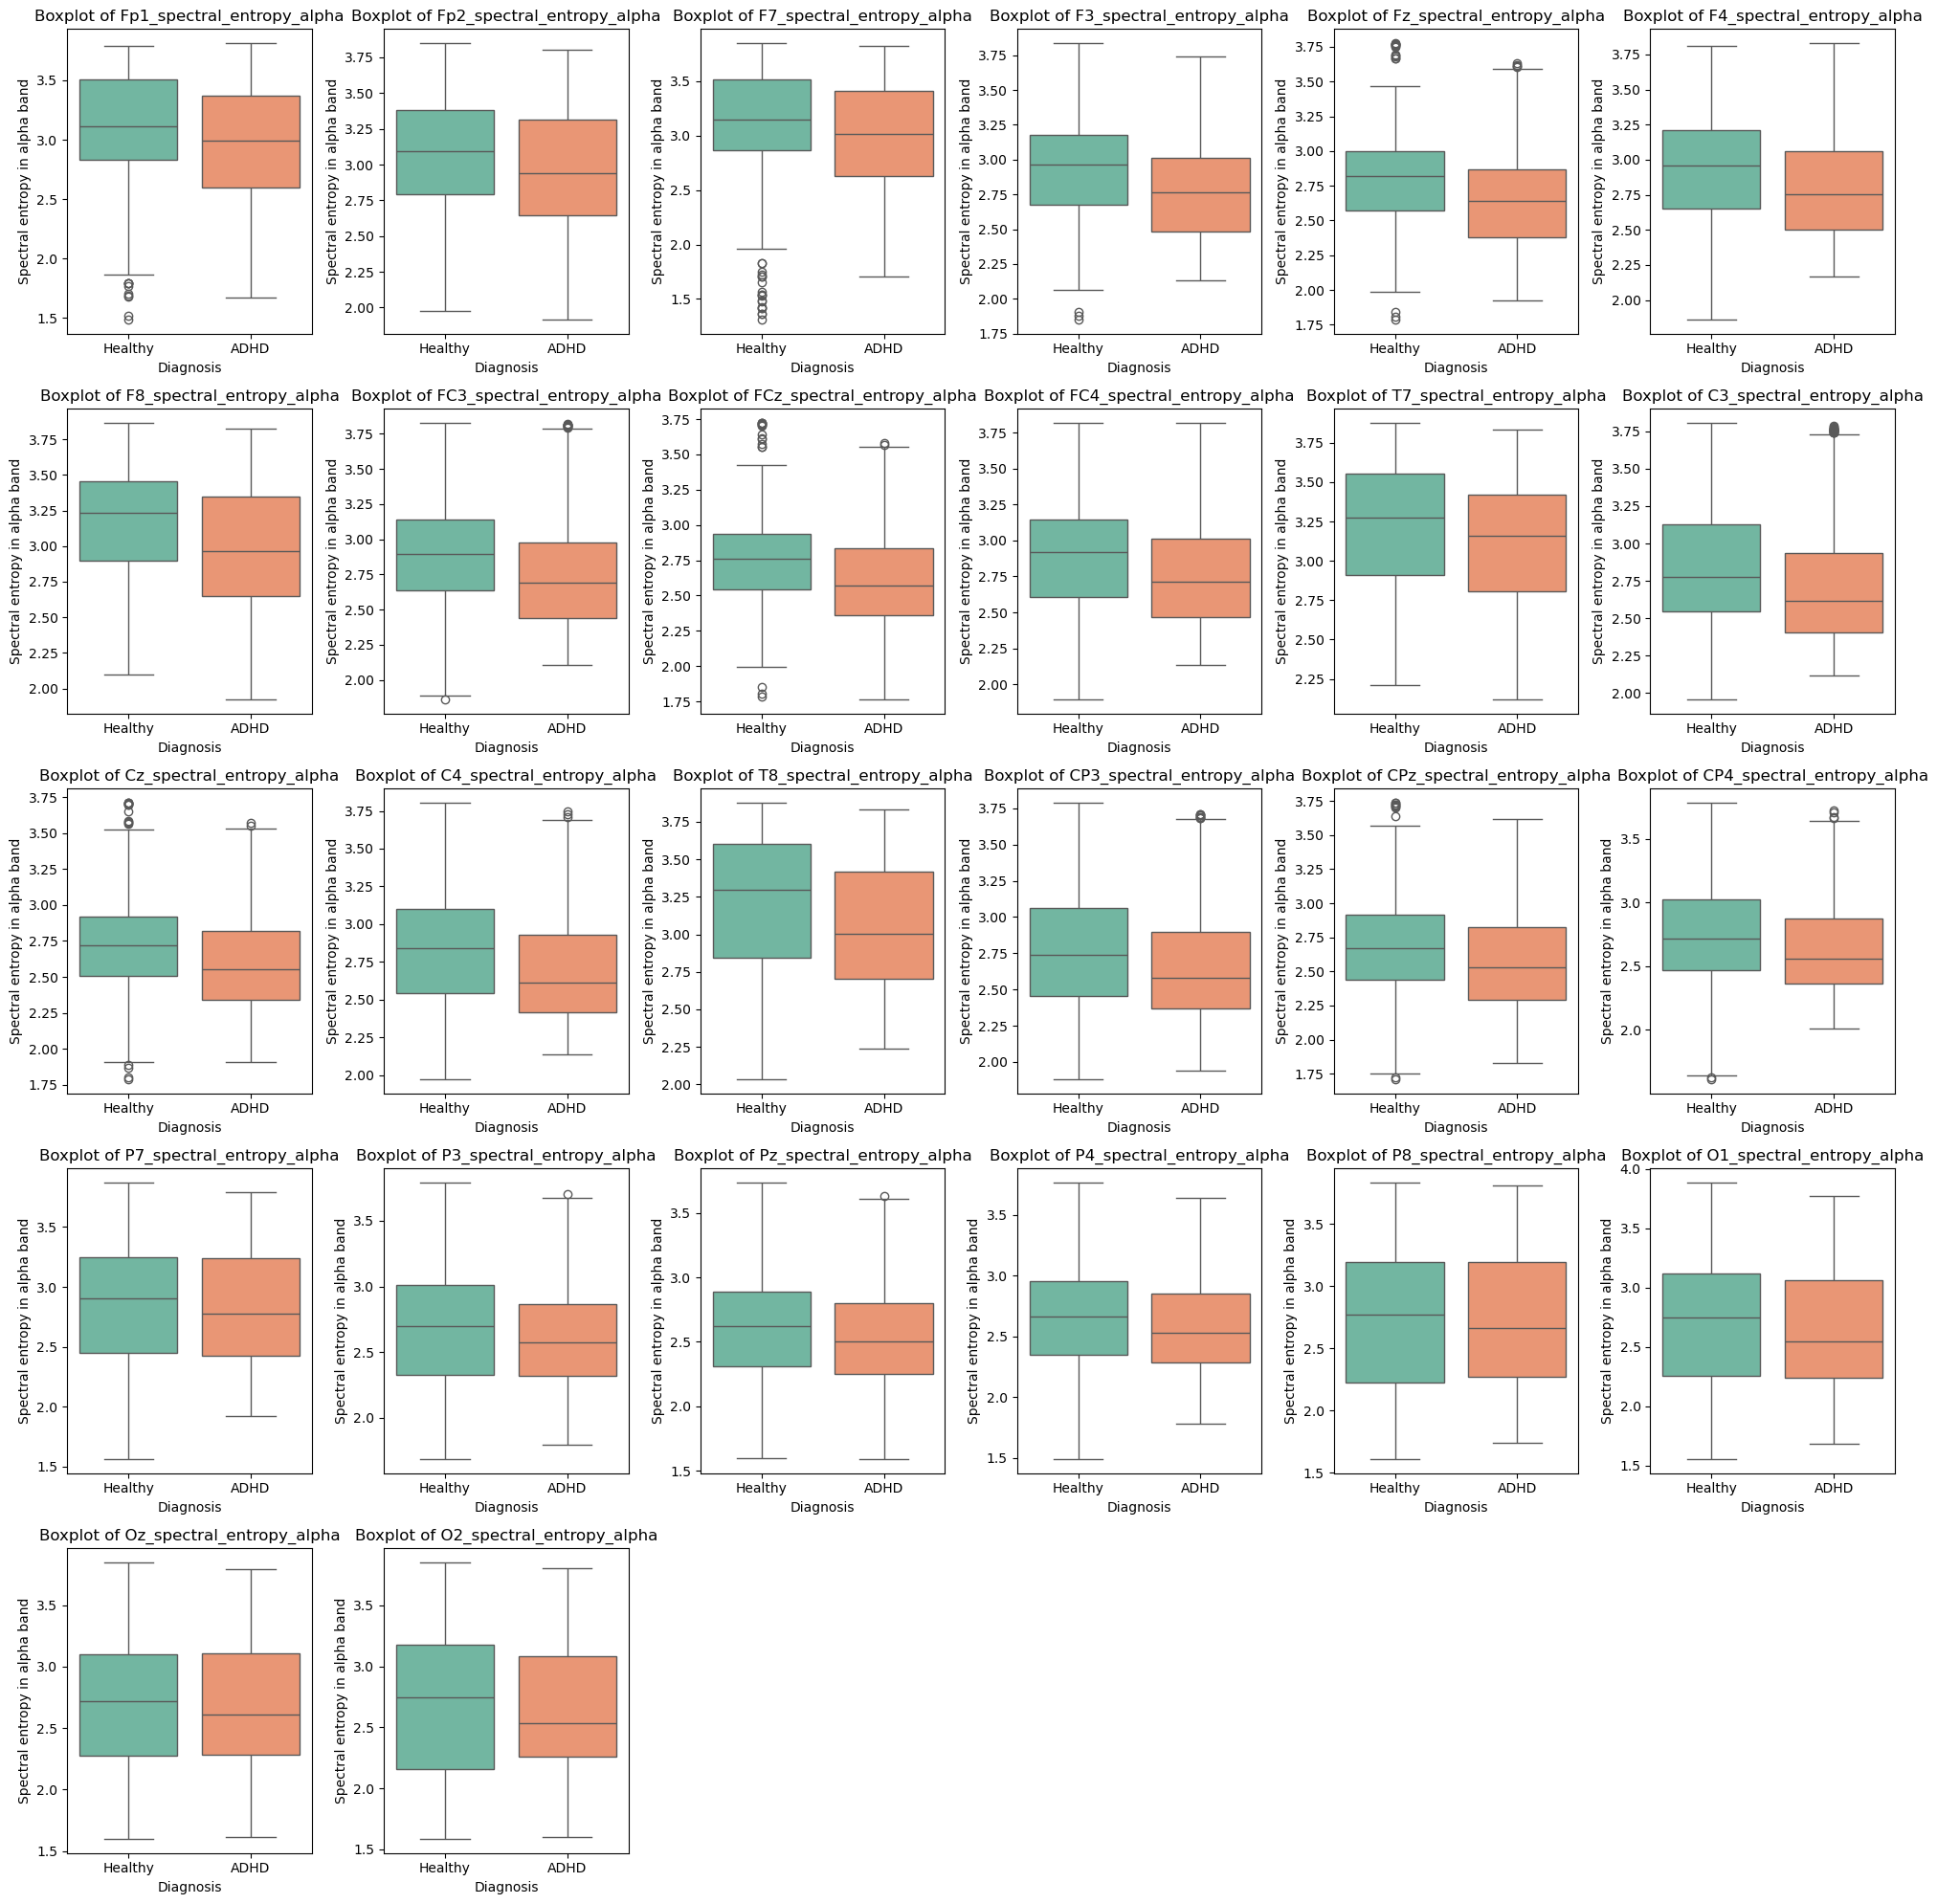

In [23]:

import matplotlib.pyplot as plt
import seaborn as sns


spectral_entropy_alpha_val_columns = spectral_entropy_alpha_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(spectral_entropy_alpha_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=spectral_entropy_alpha_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Spectral entropy in alpha band')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

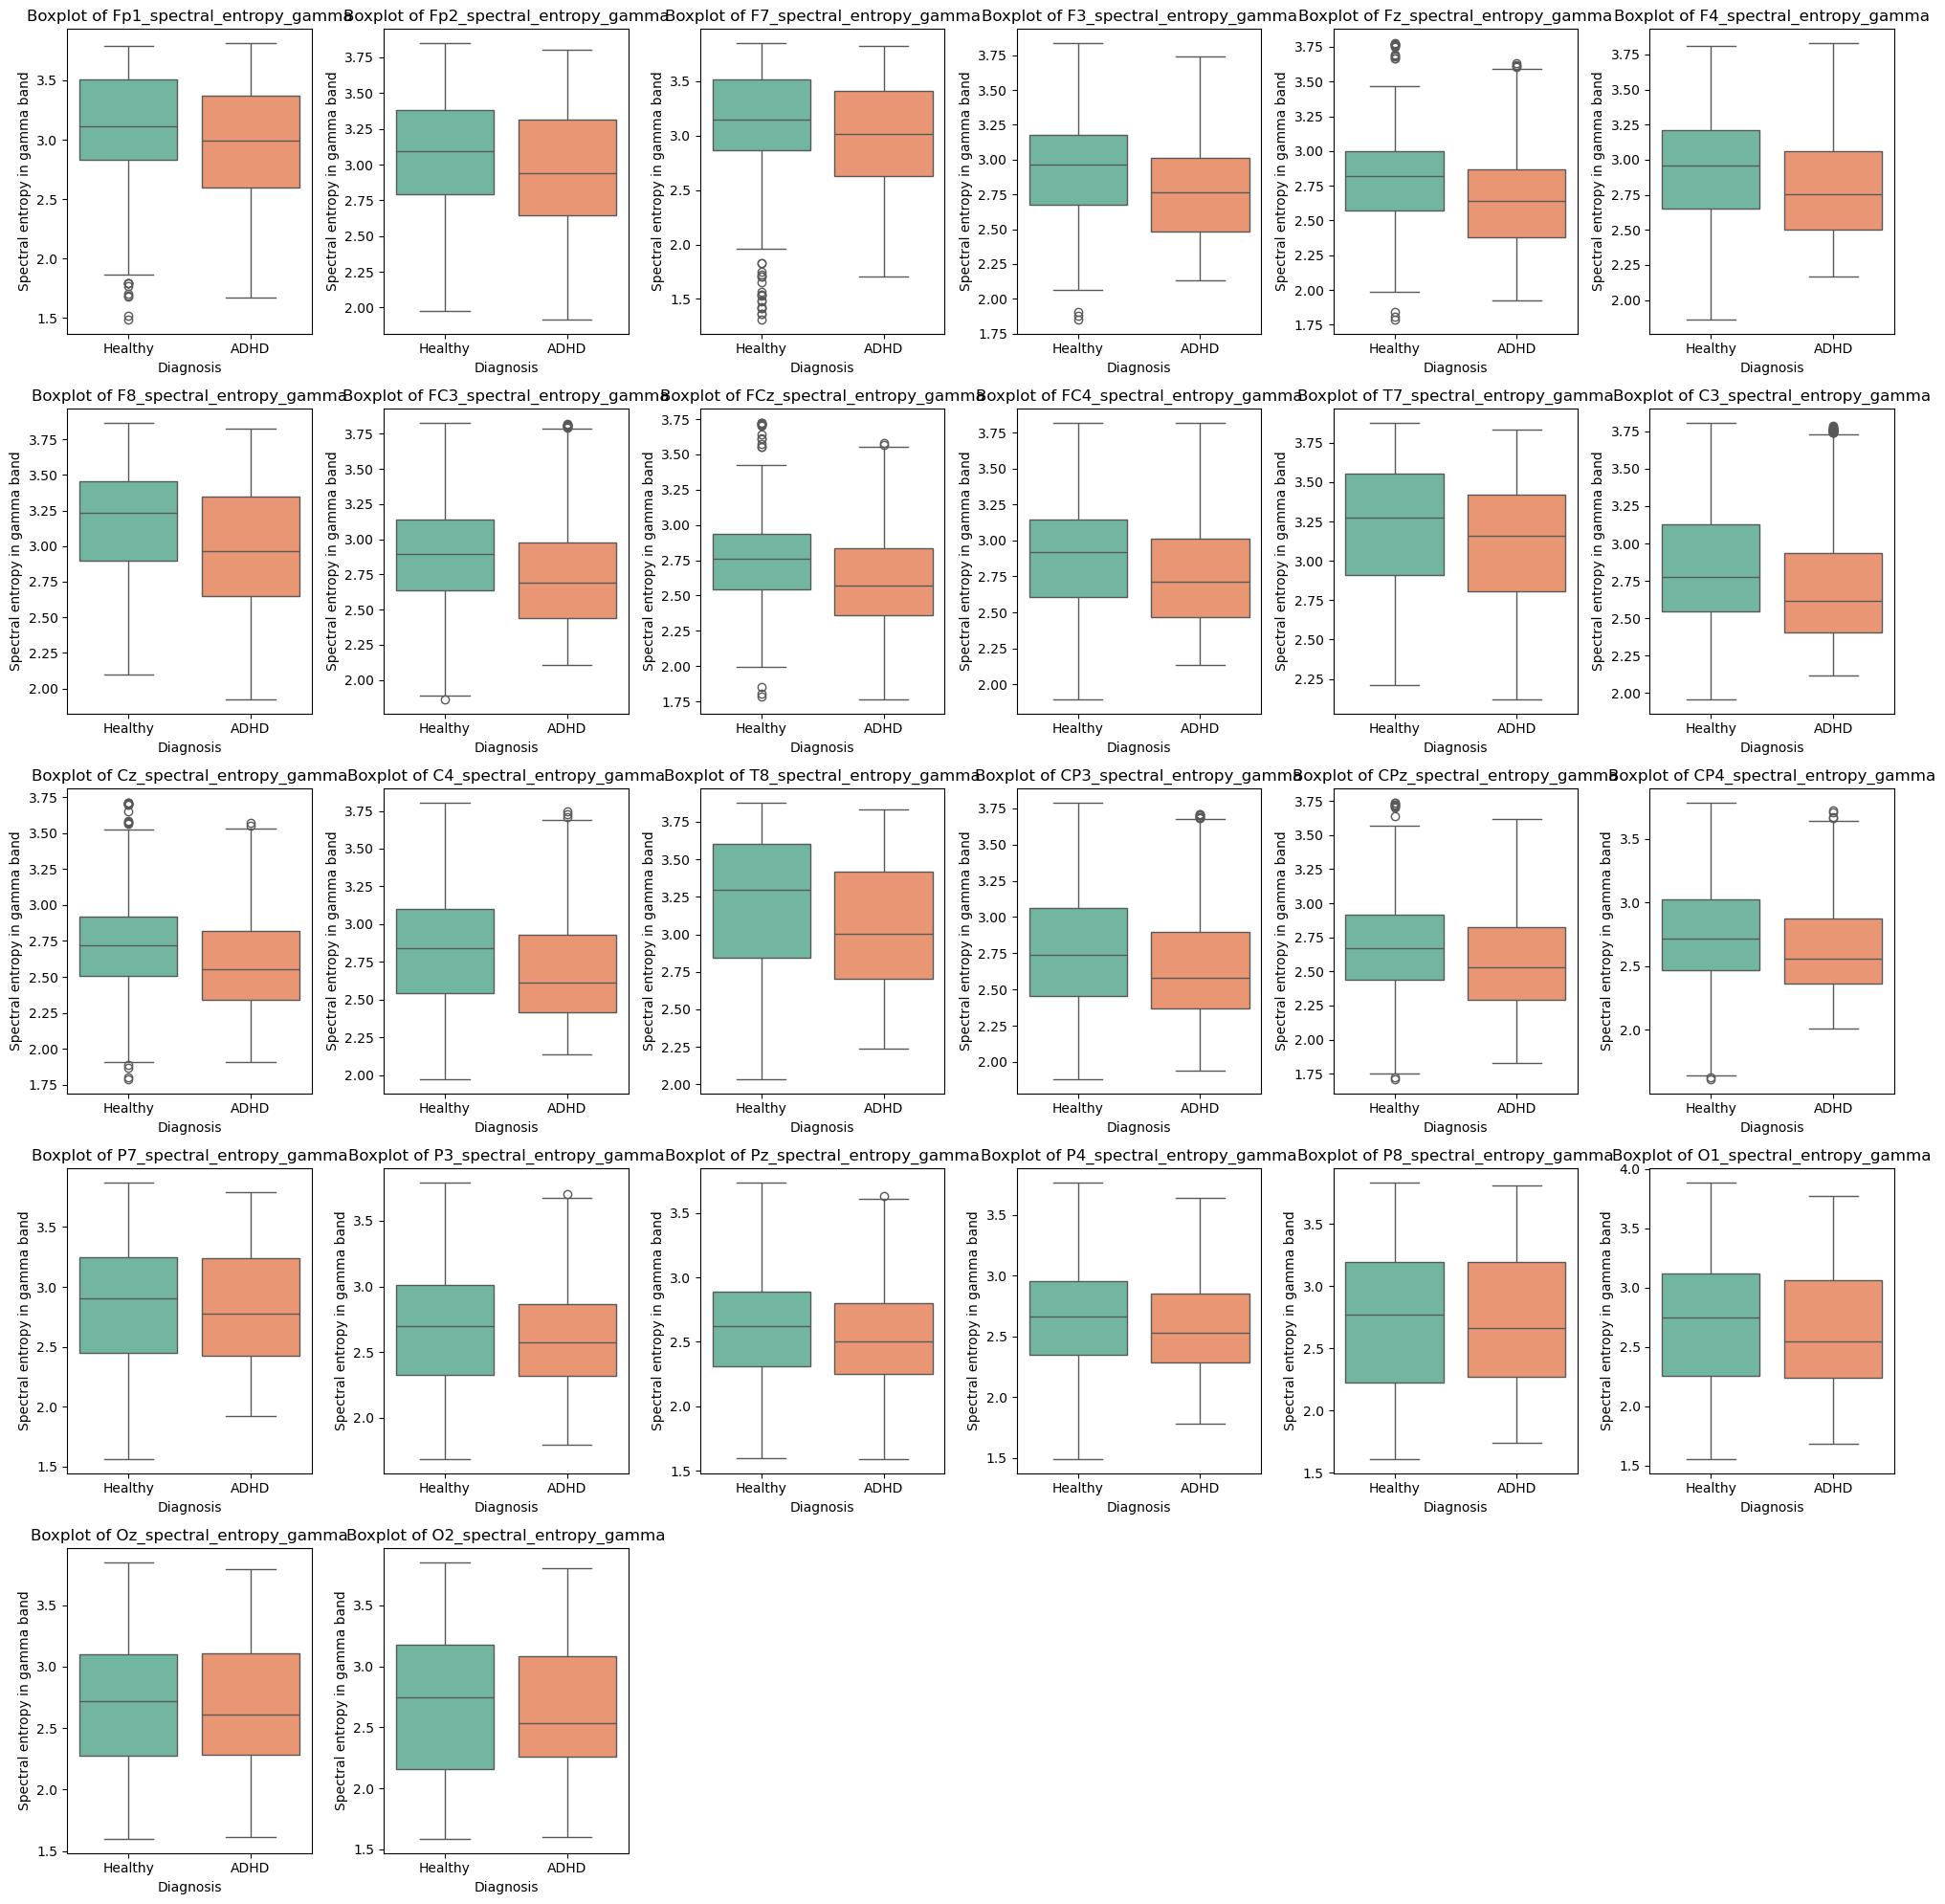

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


spectral_entropy_gamma_val_columns = spectral_entropy_gamma_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(spectral_entropy_gamma_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=spectral_entropy_gamma_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Spectral entropy in gamma band')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

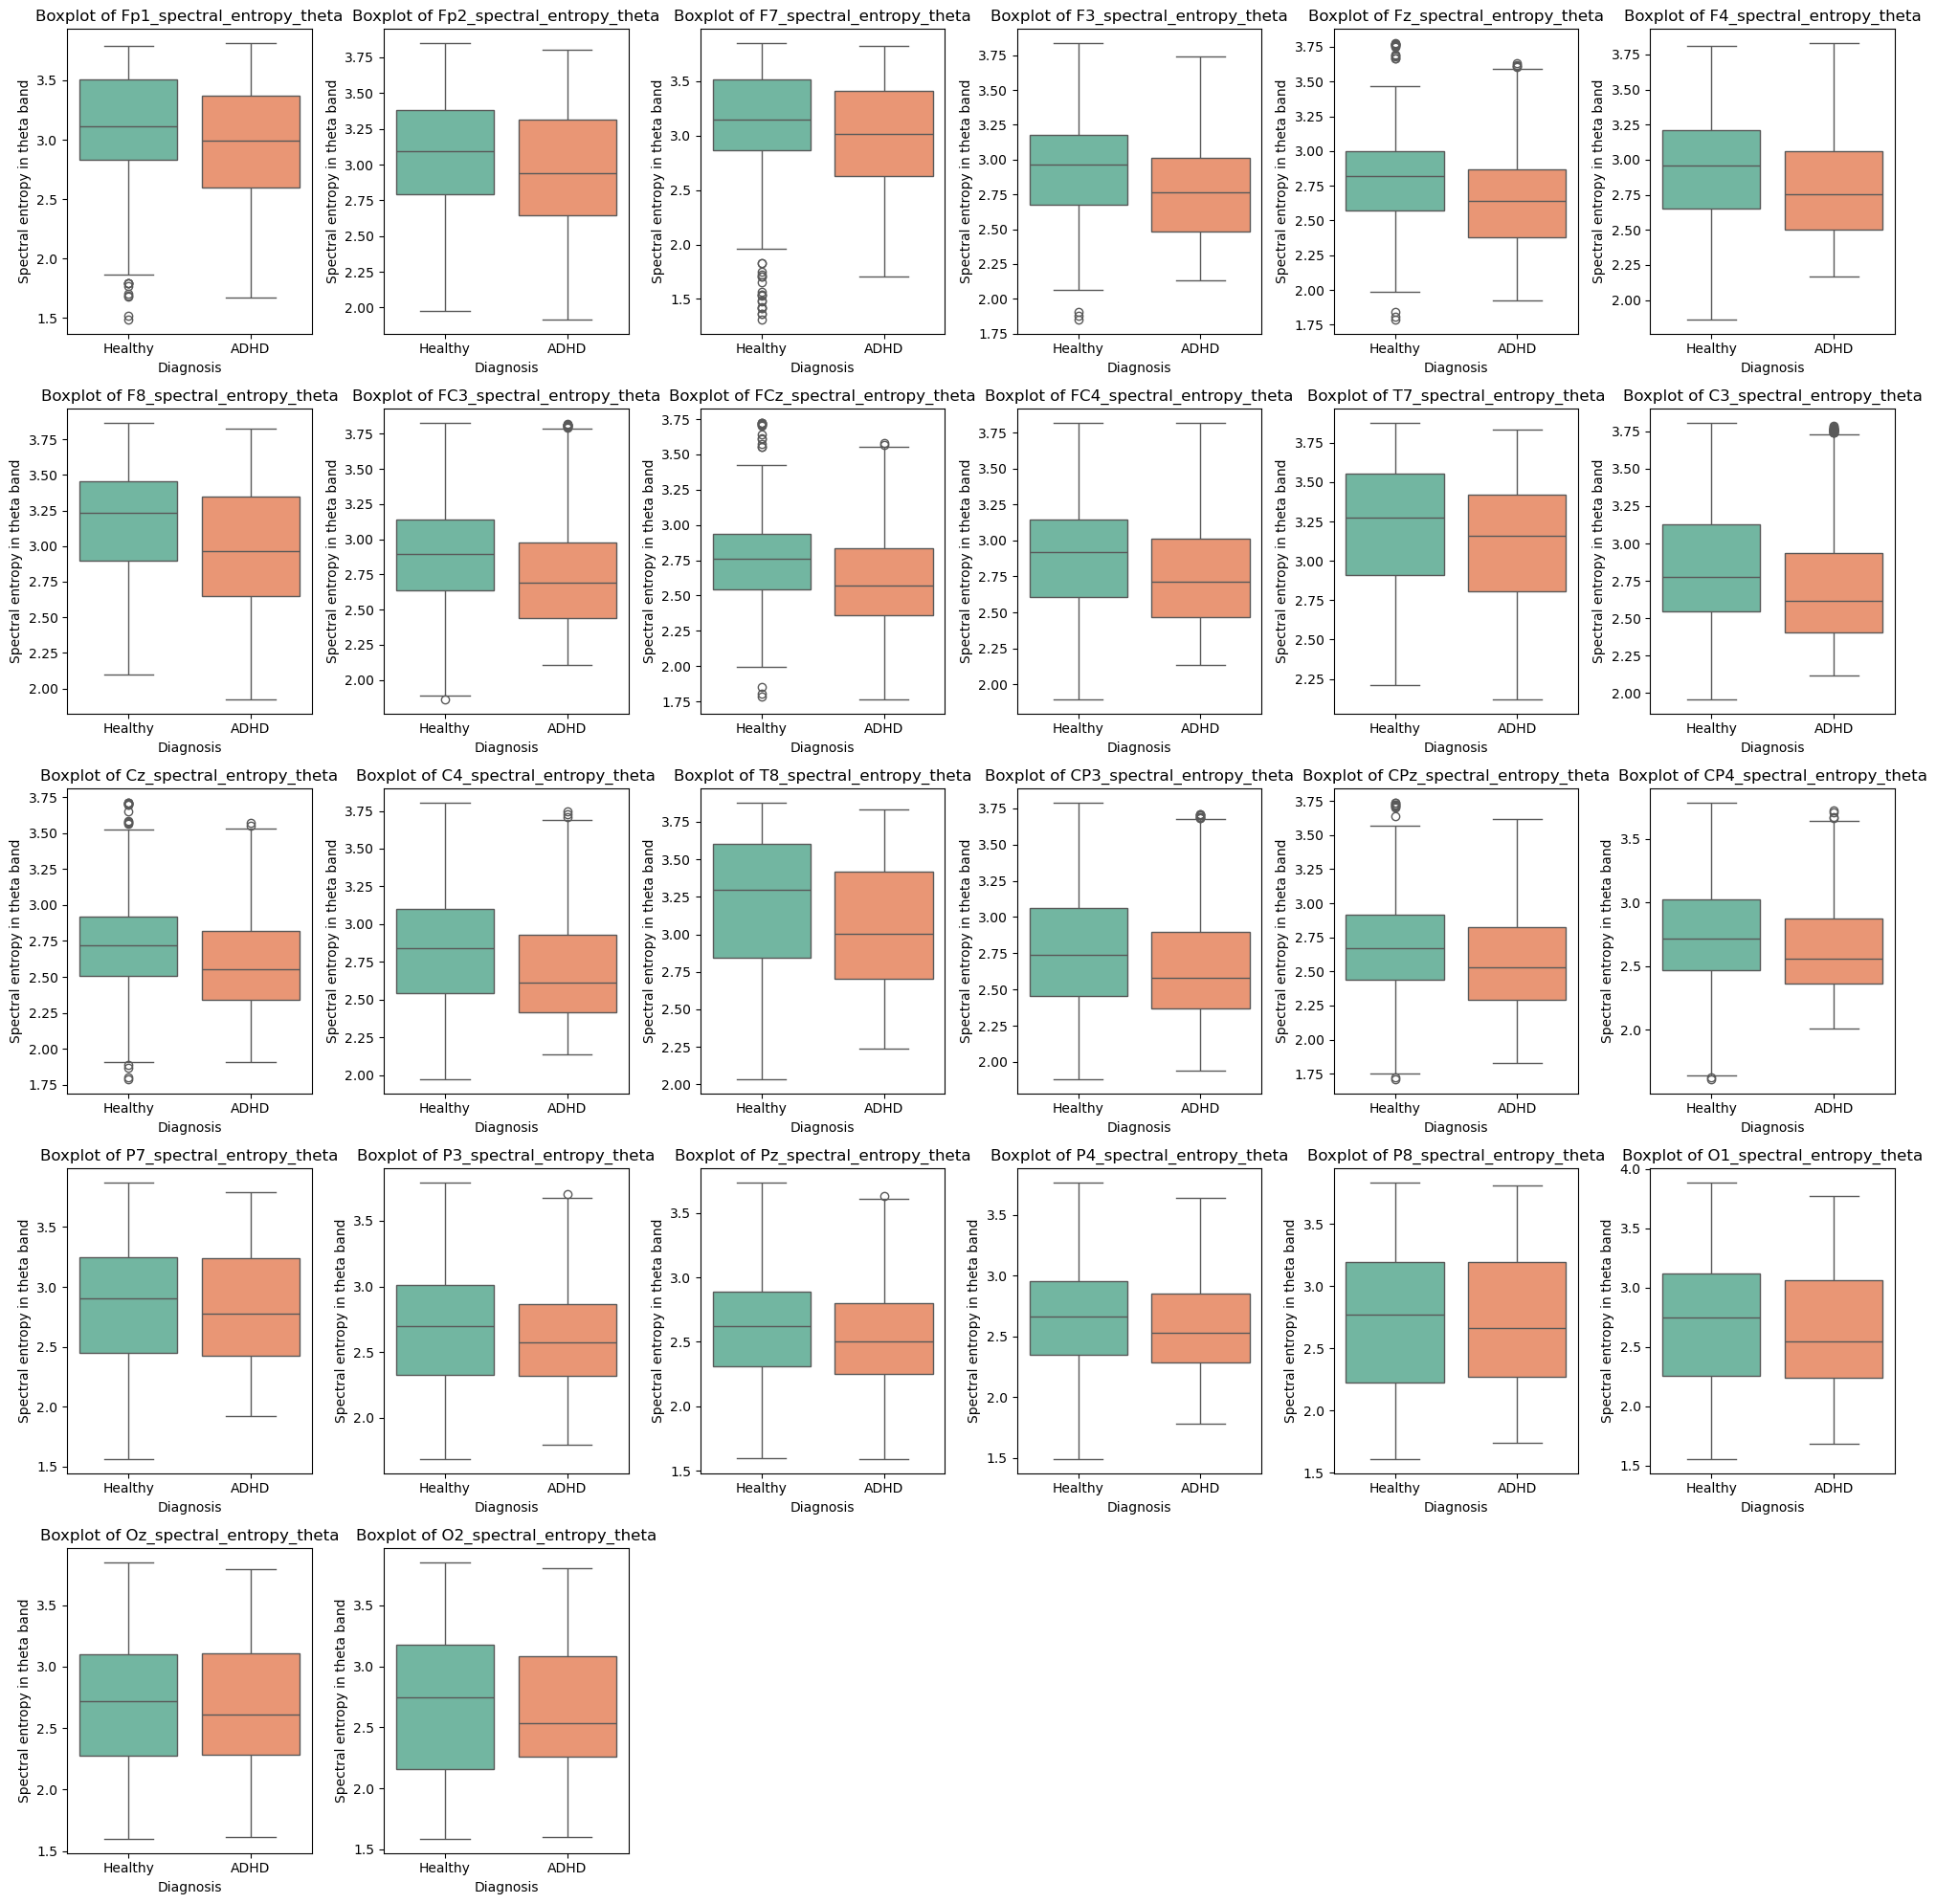

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


spectral_entropy_theta_val_columns = spectral_entropy_theta_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(spectral_entropy_theta_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=spectral_entropy_theta_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Spectral entropy in theta band')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

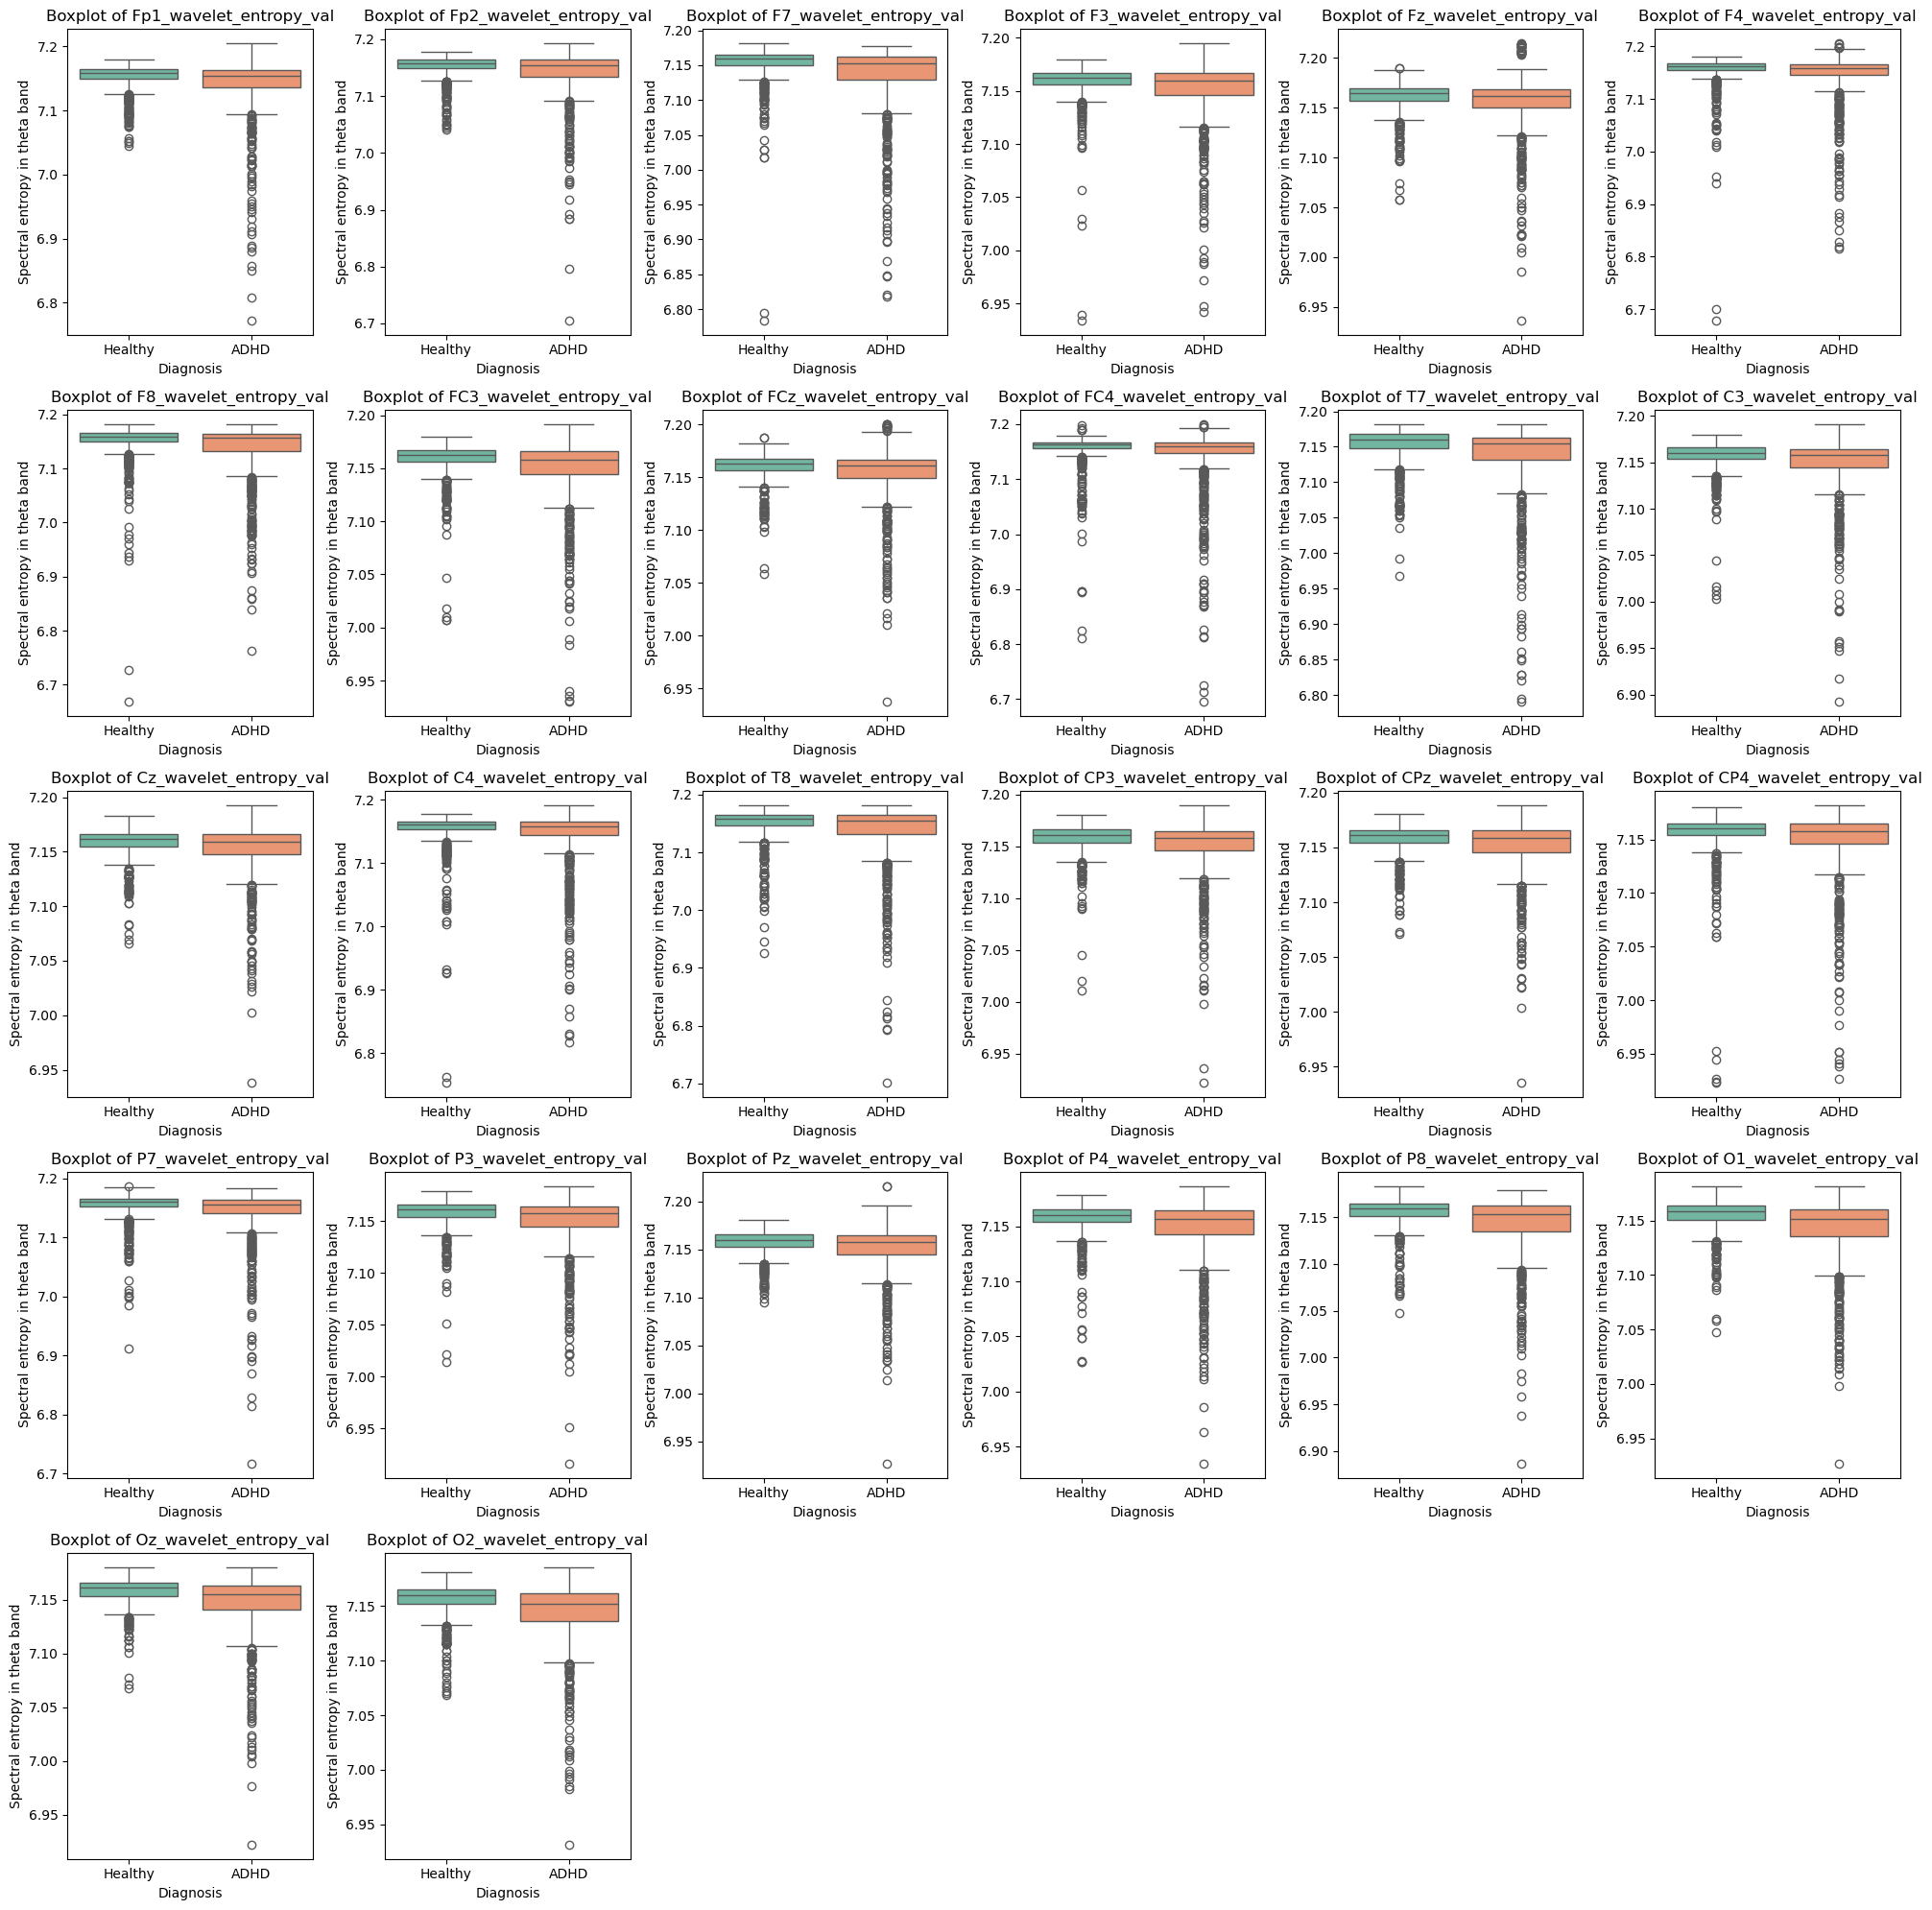

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


wavelet_entropy_val_columns = wavelet_entropy_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(wavelet_entropy_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=wavelet_entropy_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Spectral entropy in theta band')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

### 3. Petrosian, Katz and Higuchi fractal dimension values.

In [27]:
katz_fd_vals = training_df.filter(regex='katz_fd_val|diagnosis')
petrosian_fd_vals = training_df.filter(regex='petrosian_fd_val|diagnosis')
higuchi_fd_vals = training_df.filter(regex='higuchi_fd_val|diagnosis')

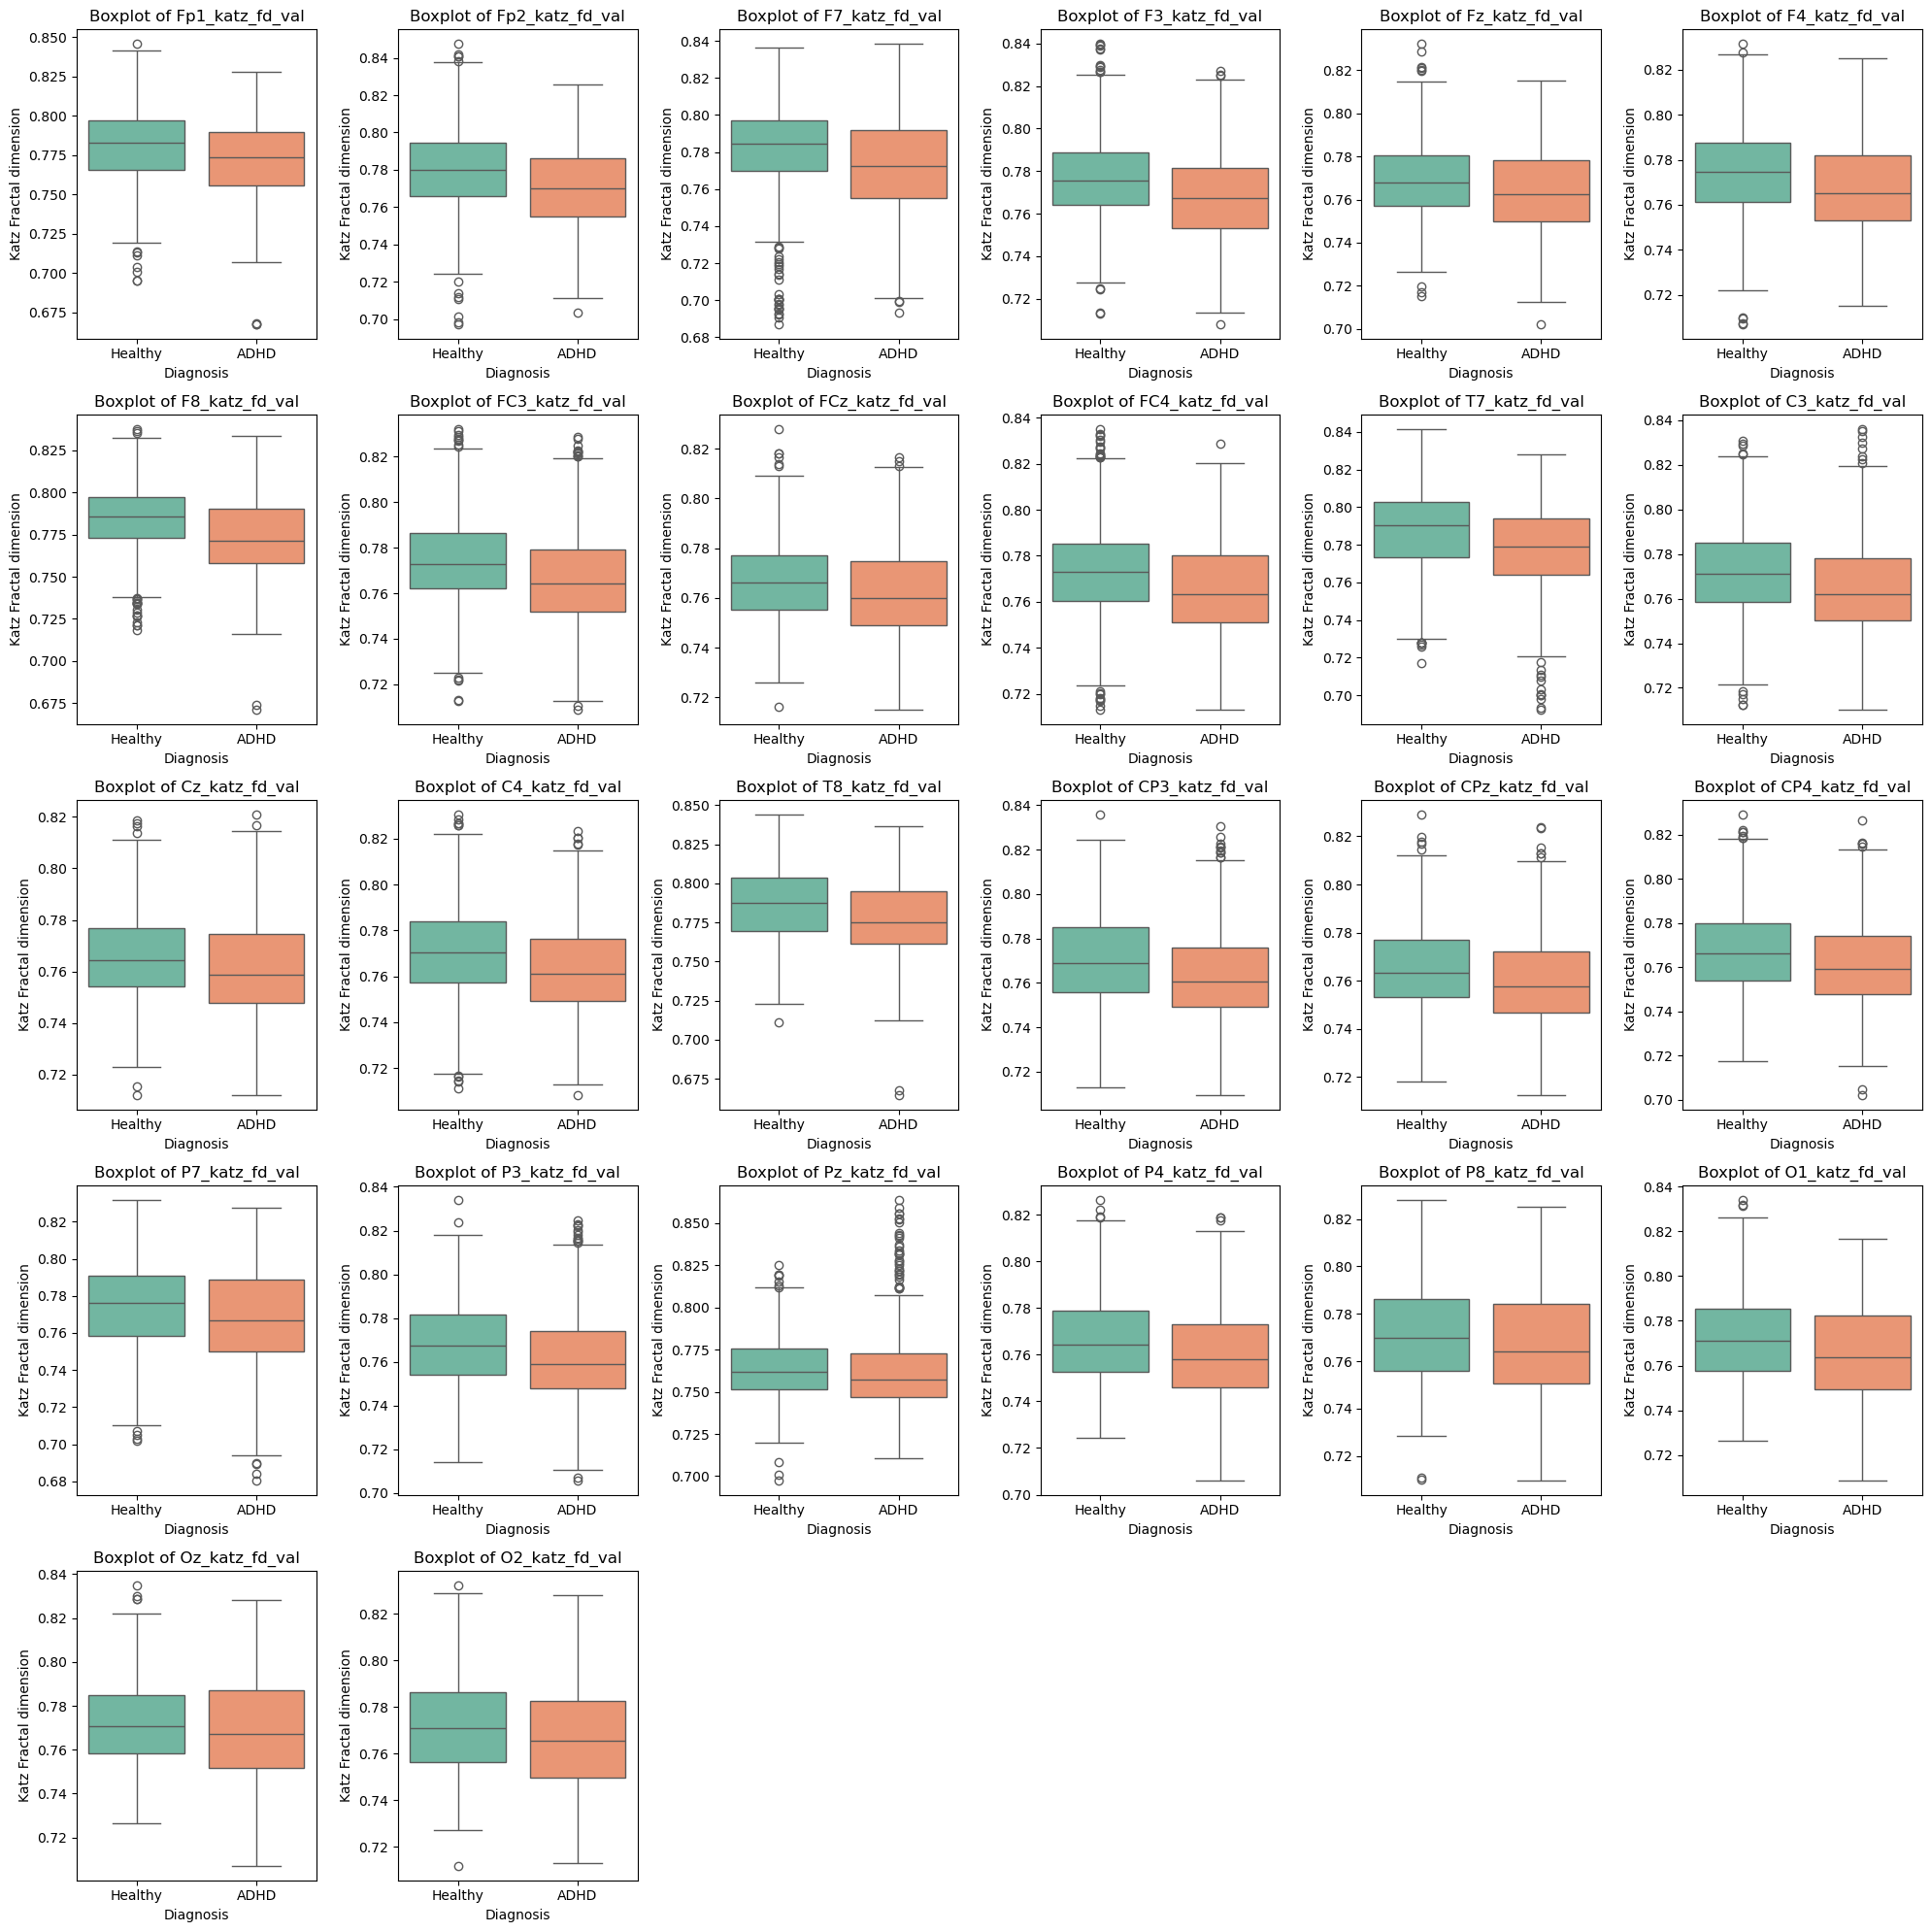

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns


katz_fd_val_columns = katz_fd_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(katz_fd_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=katz_fd_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Katz Fractal dimension')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

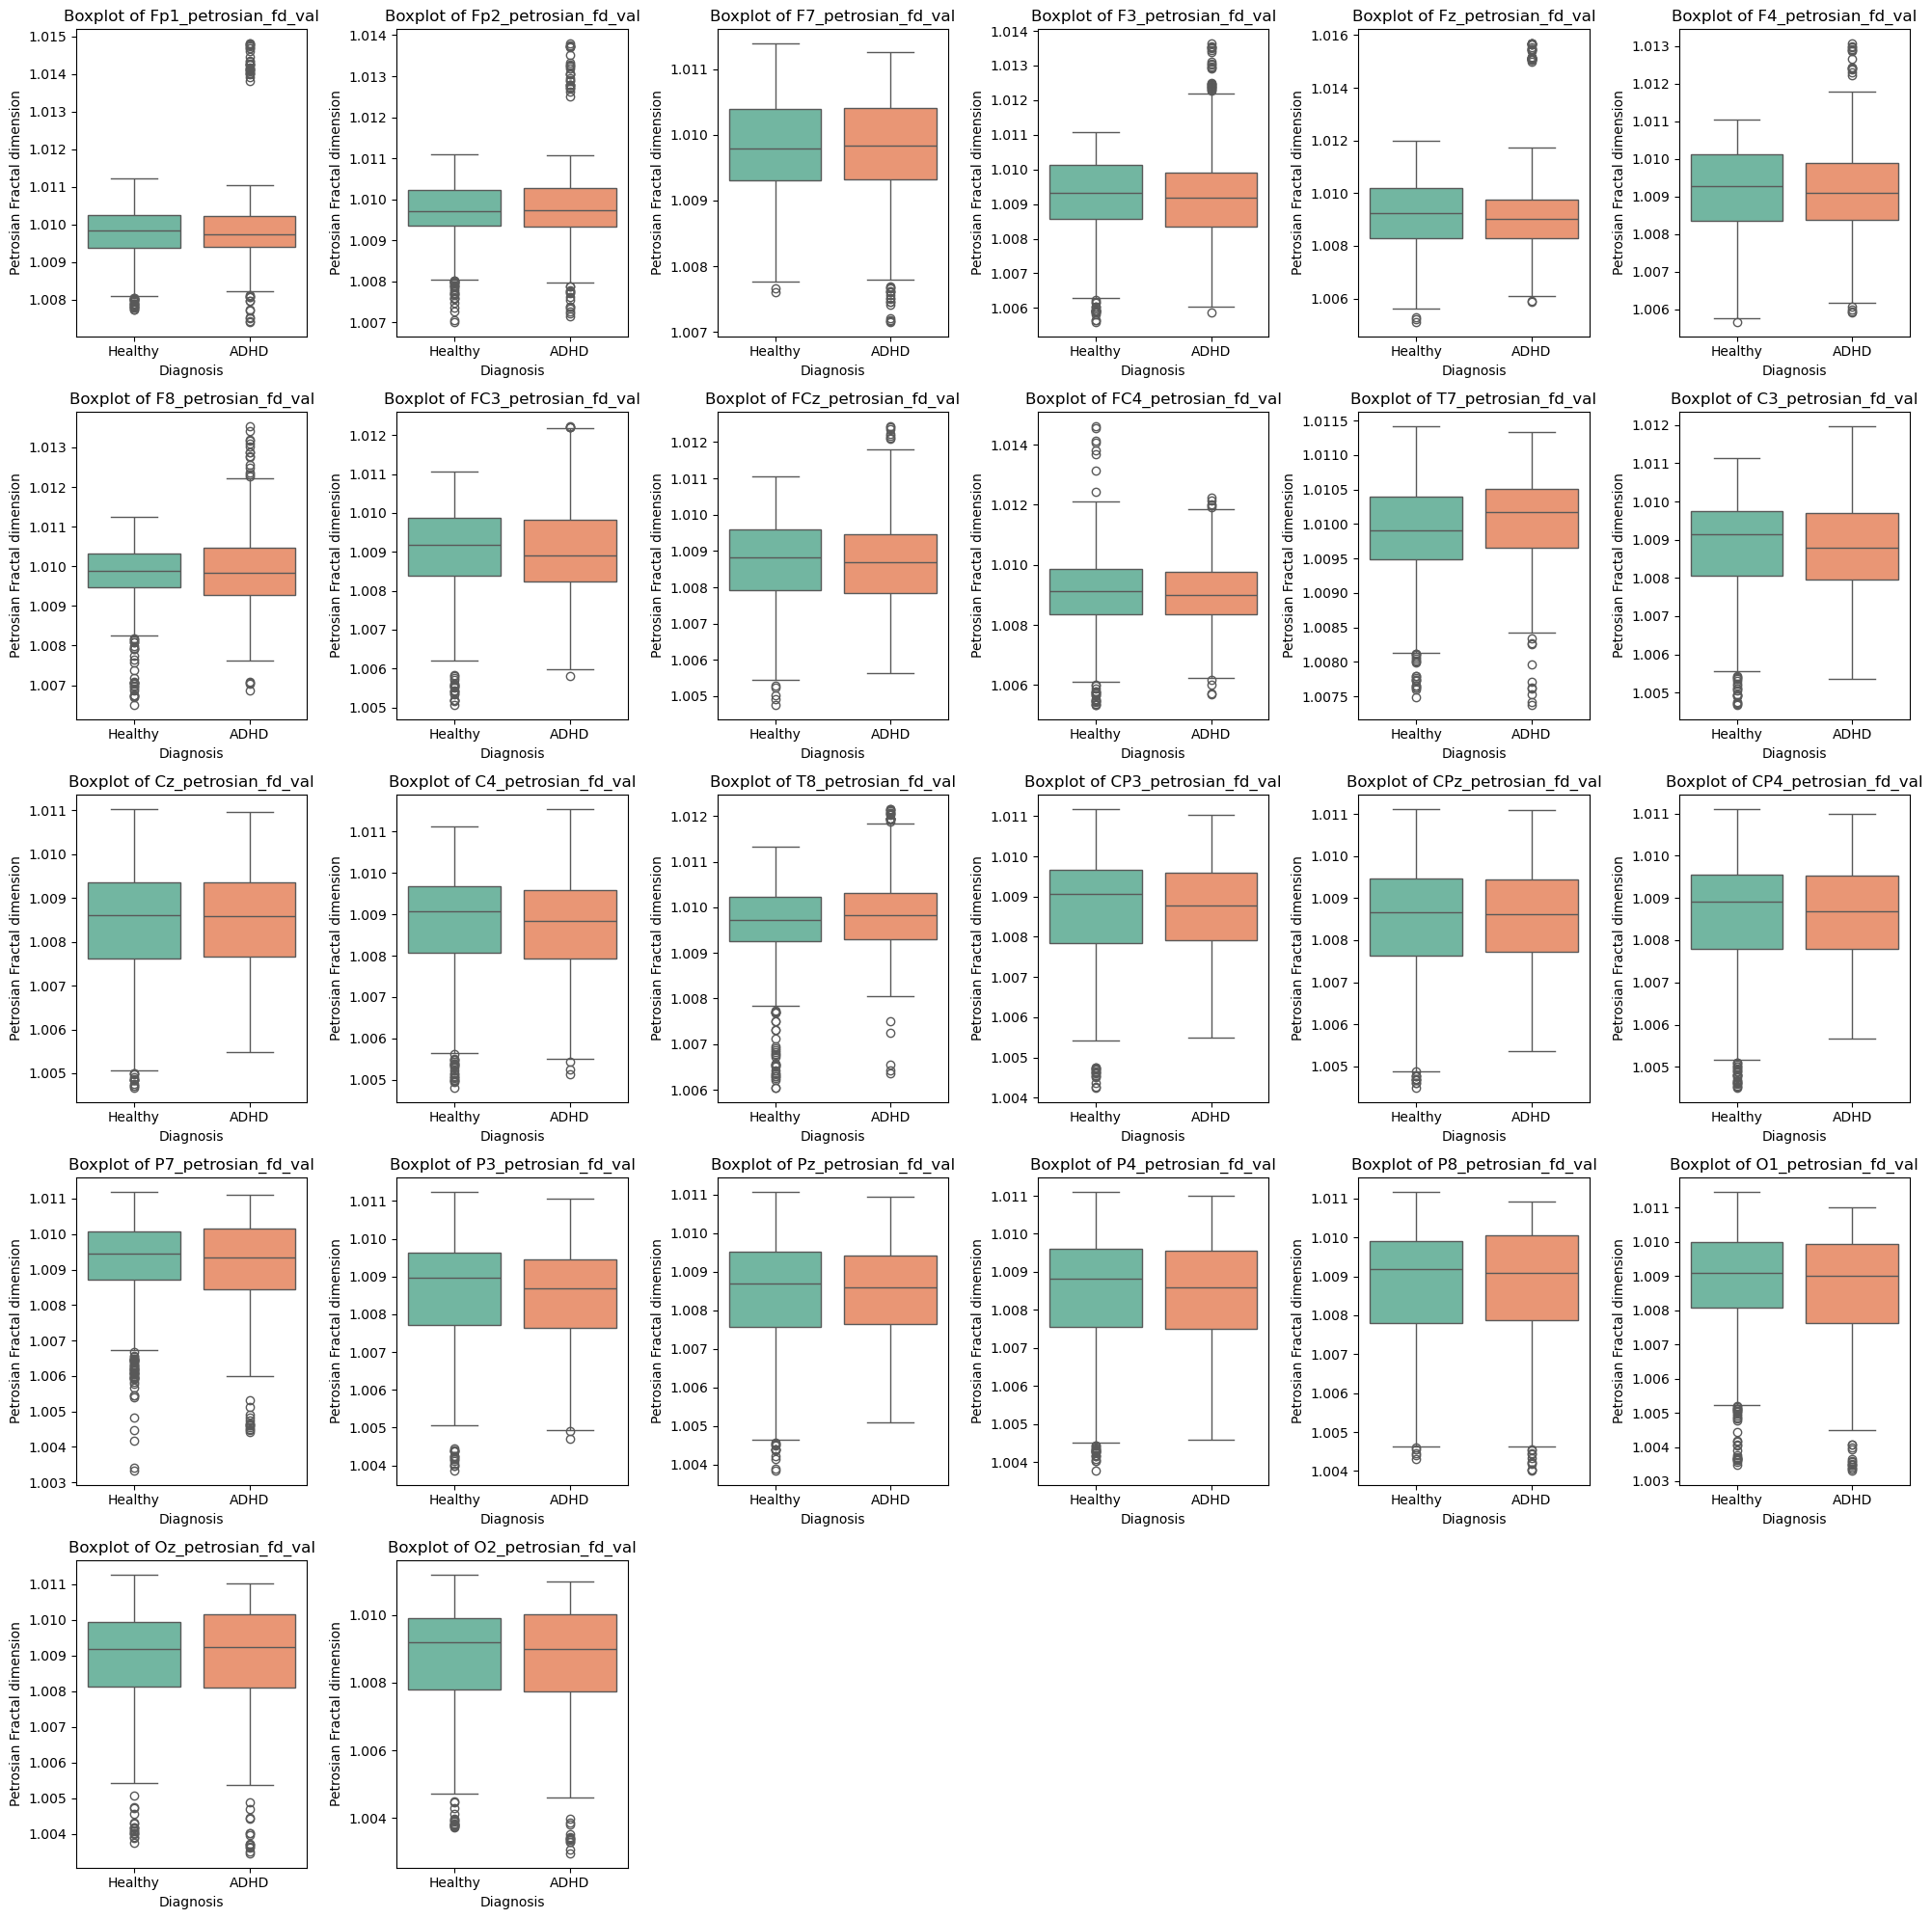

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


petrosian_fd_val_columns = petrosian_fd_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(petrosian_fd_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=petrosian_fd_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Petrosian Fractal dimension')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

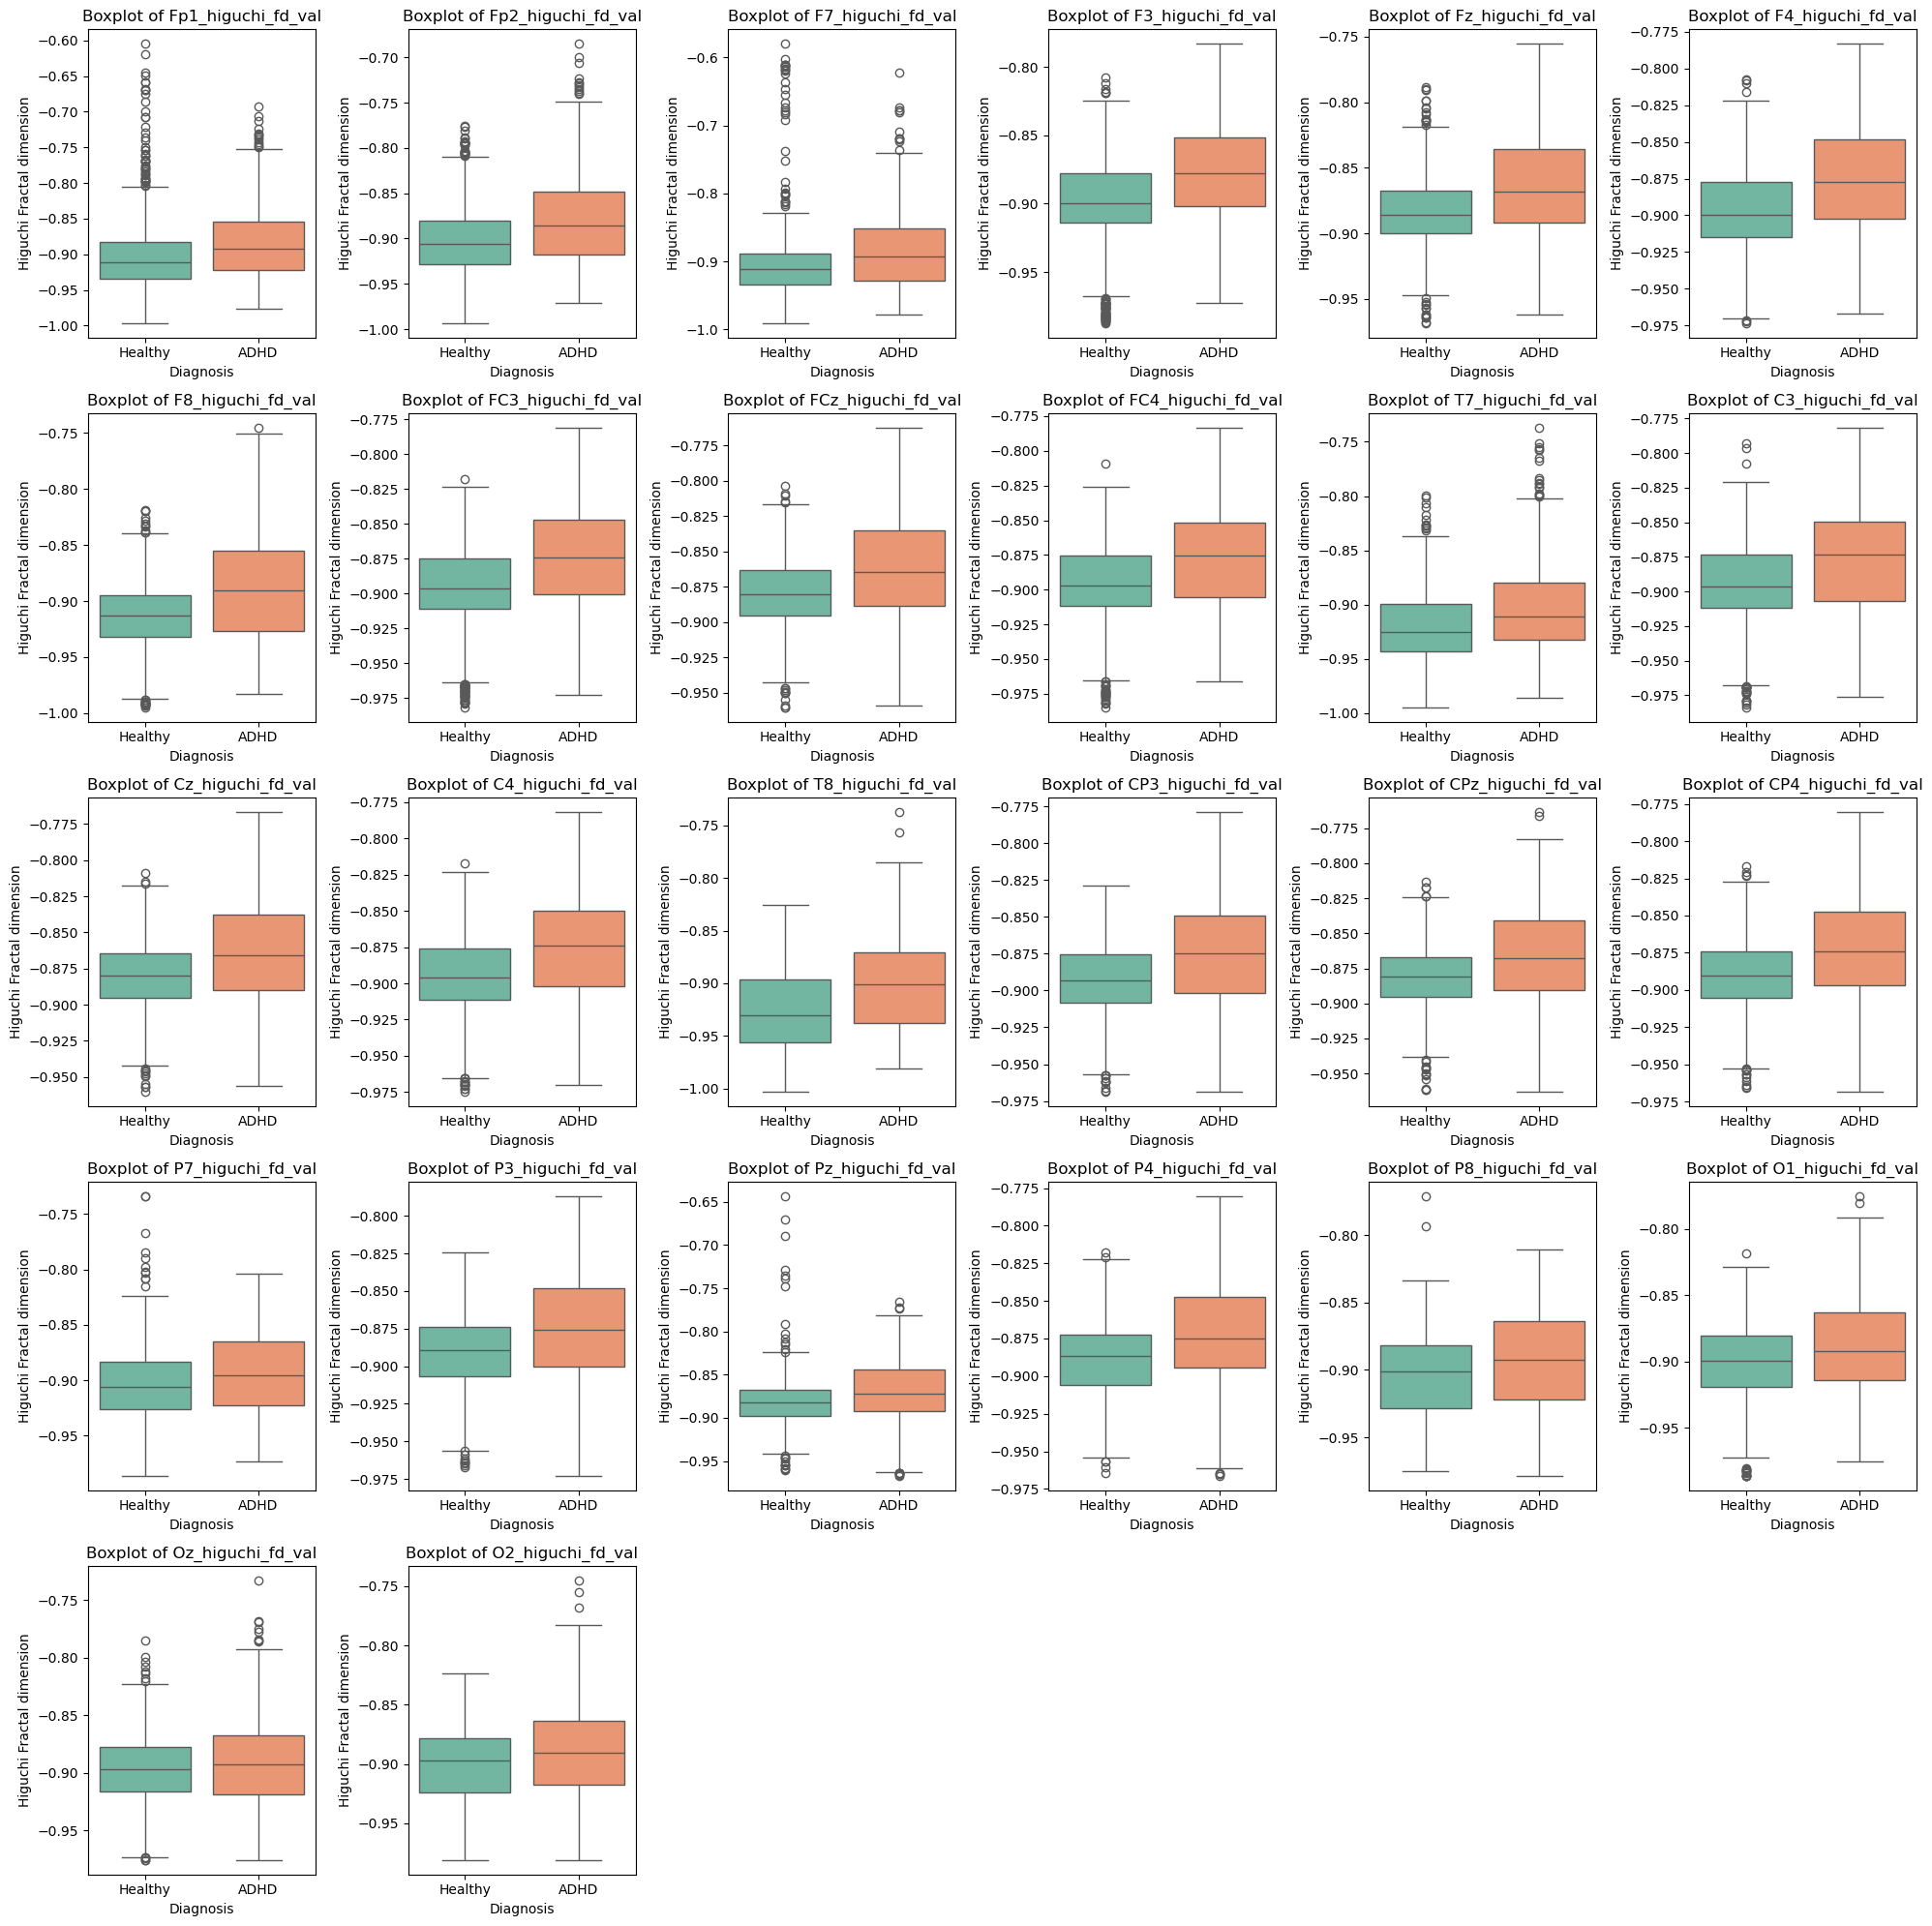

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns


higuchi_fd_val_columns = higuchi_fd_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(higuchi_fd_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=higuchi_fd_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Higuchi Fractal dimension')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

### 4. Hjorth parameters

In [31]:
activity_vals = training_df.filter(regex='activity|diagnosis')
mobility_vals = training_df.filter(regex='mobility|diagnosis')
complexity_vals = training_df.filter(regex='complexity|diagnosis')

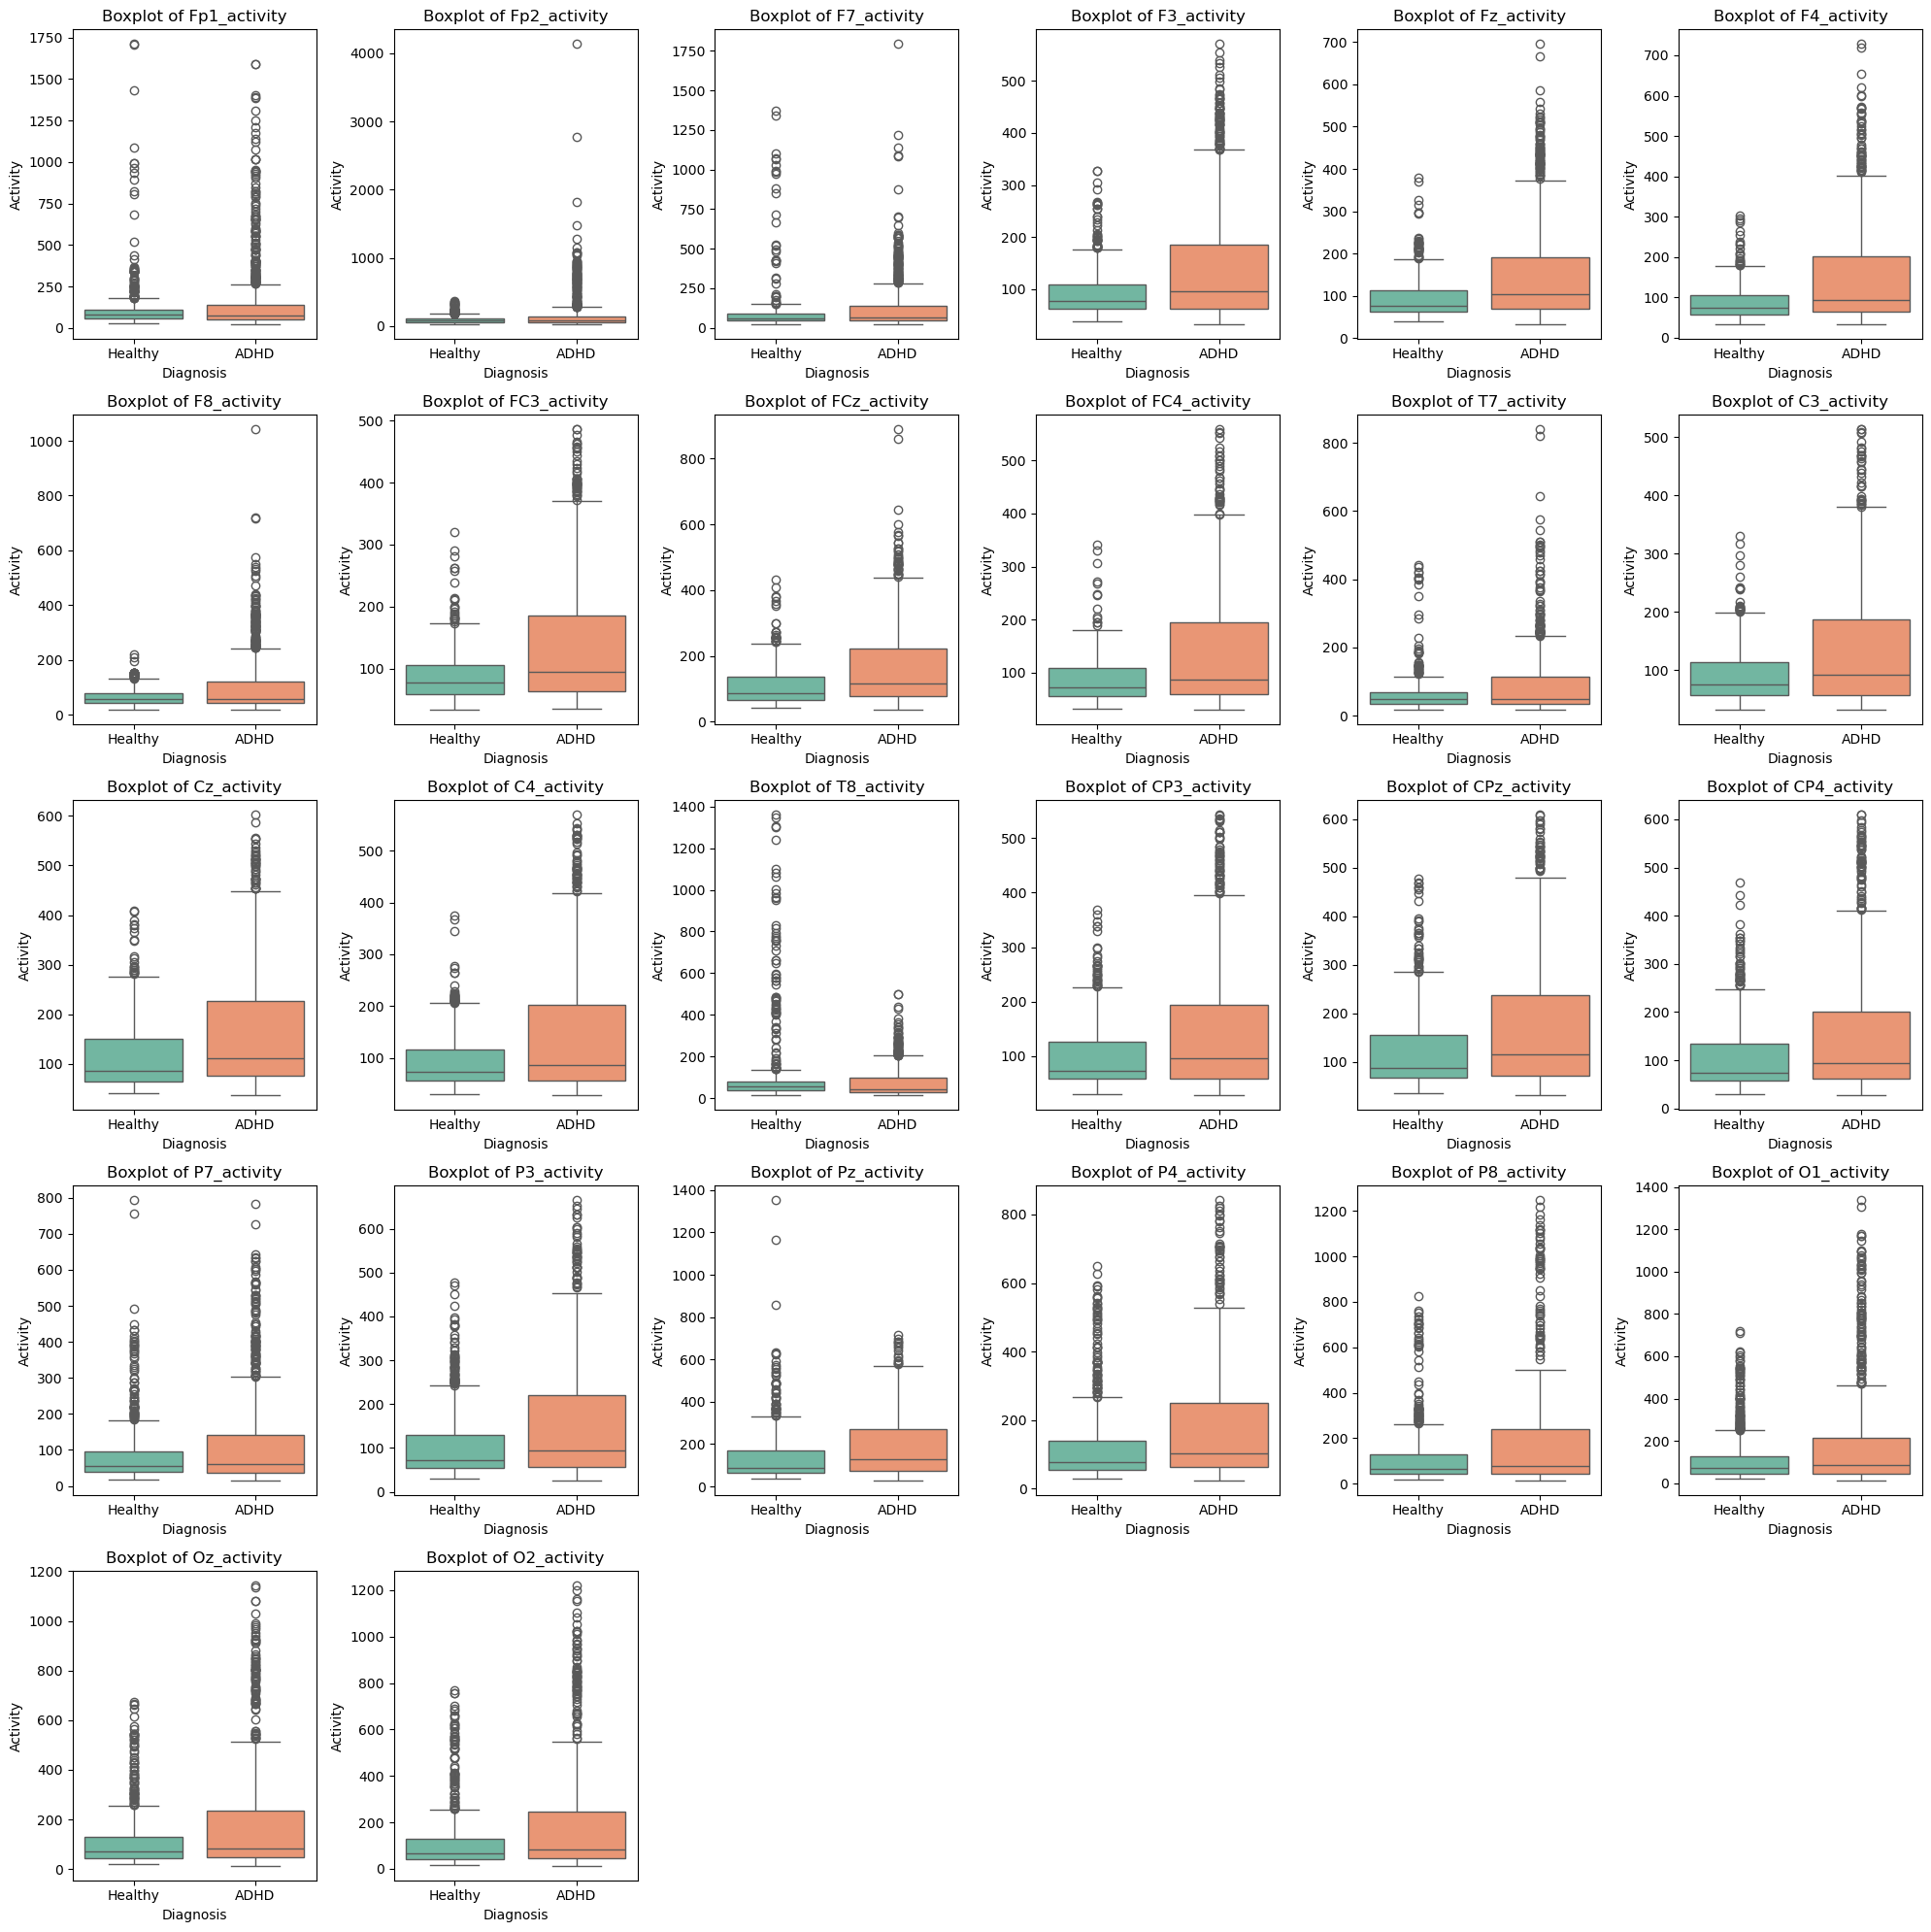

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns


activity_val_columns = activity_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(activity_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=activity_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Activity')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

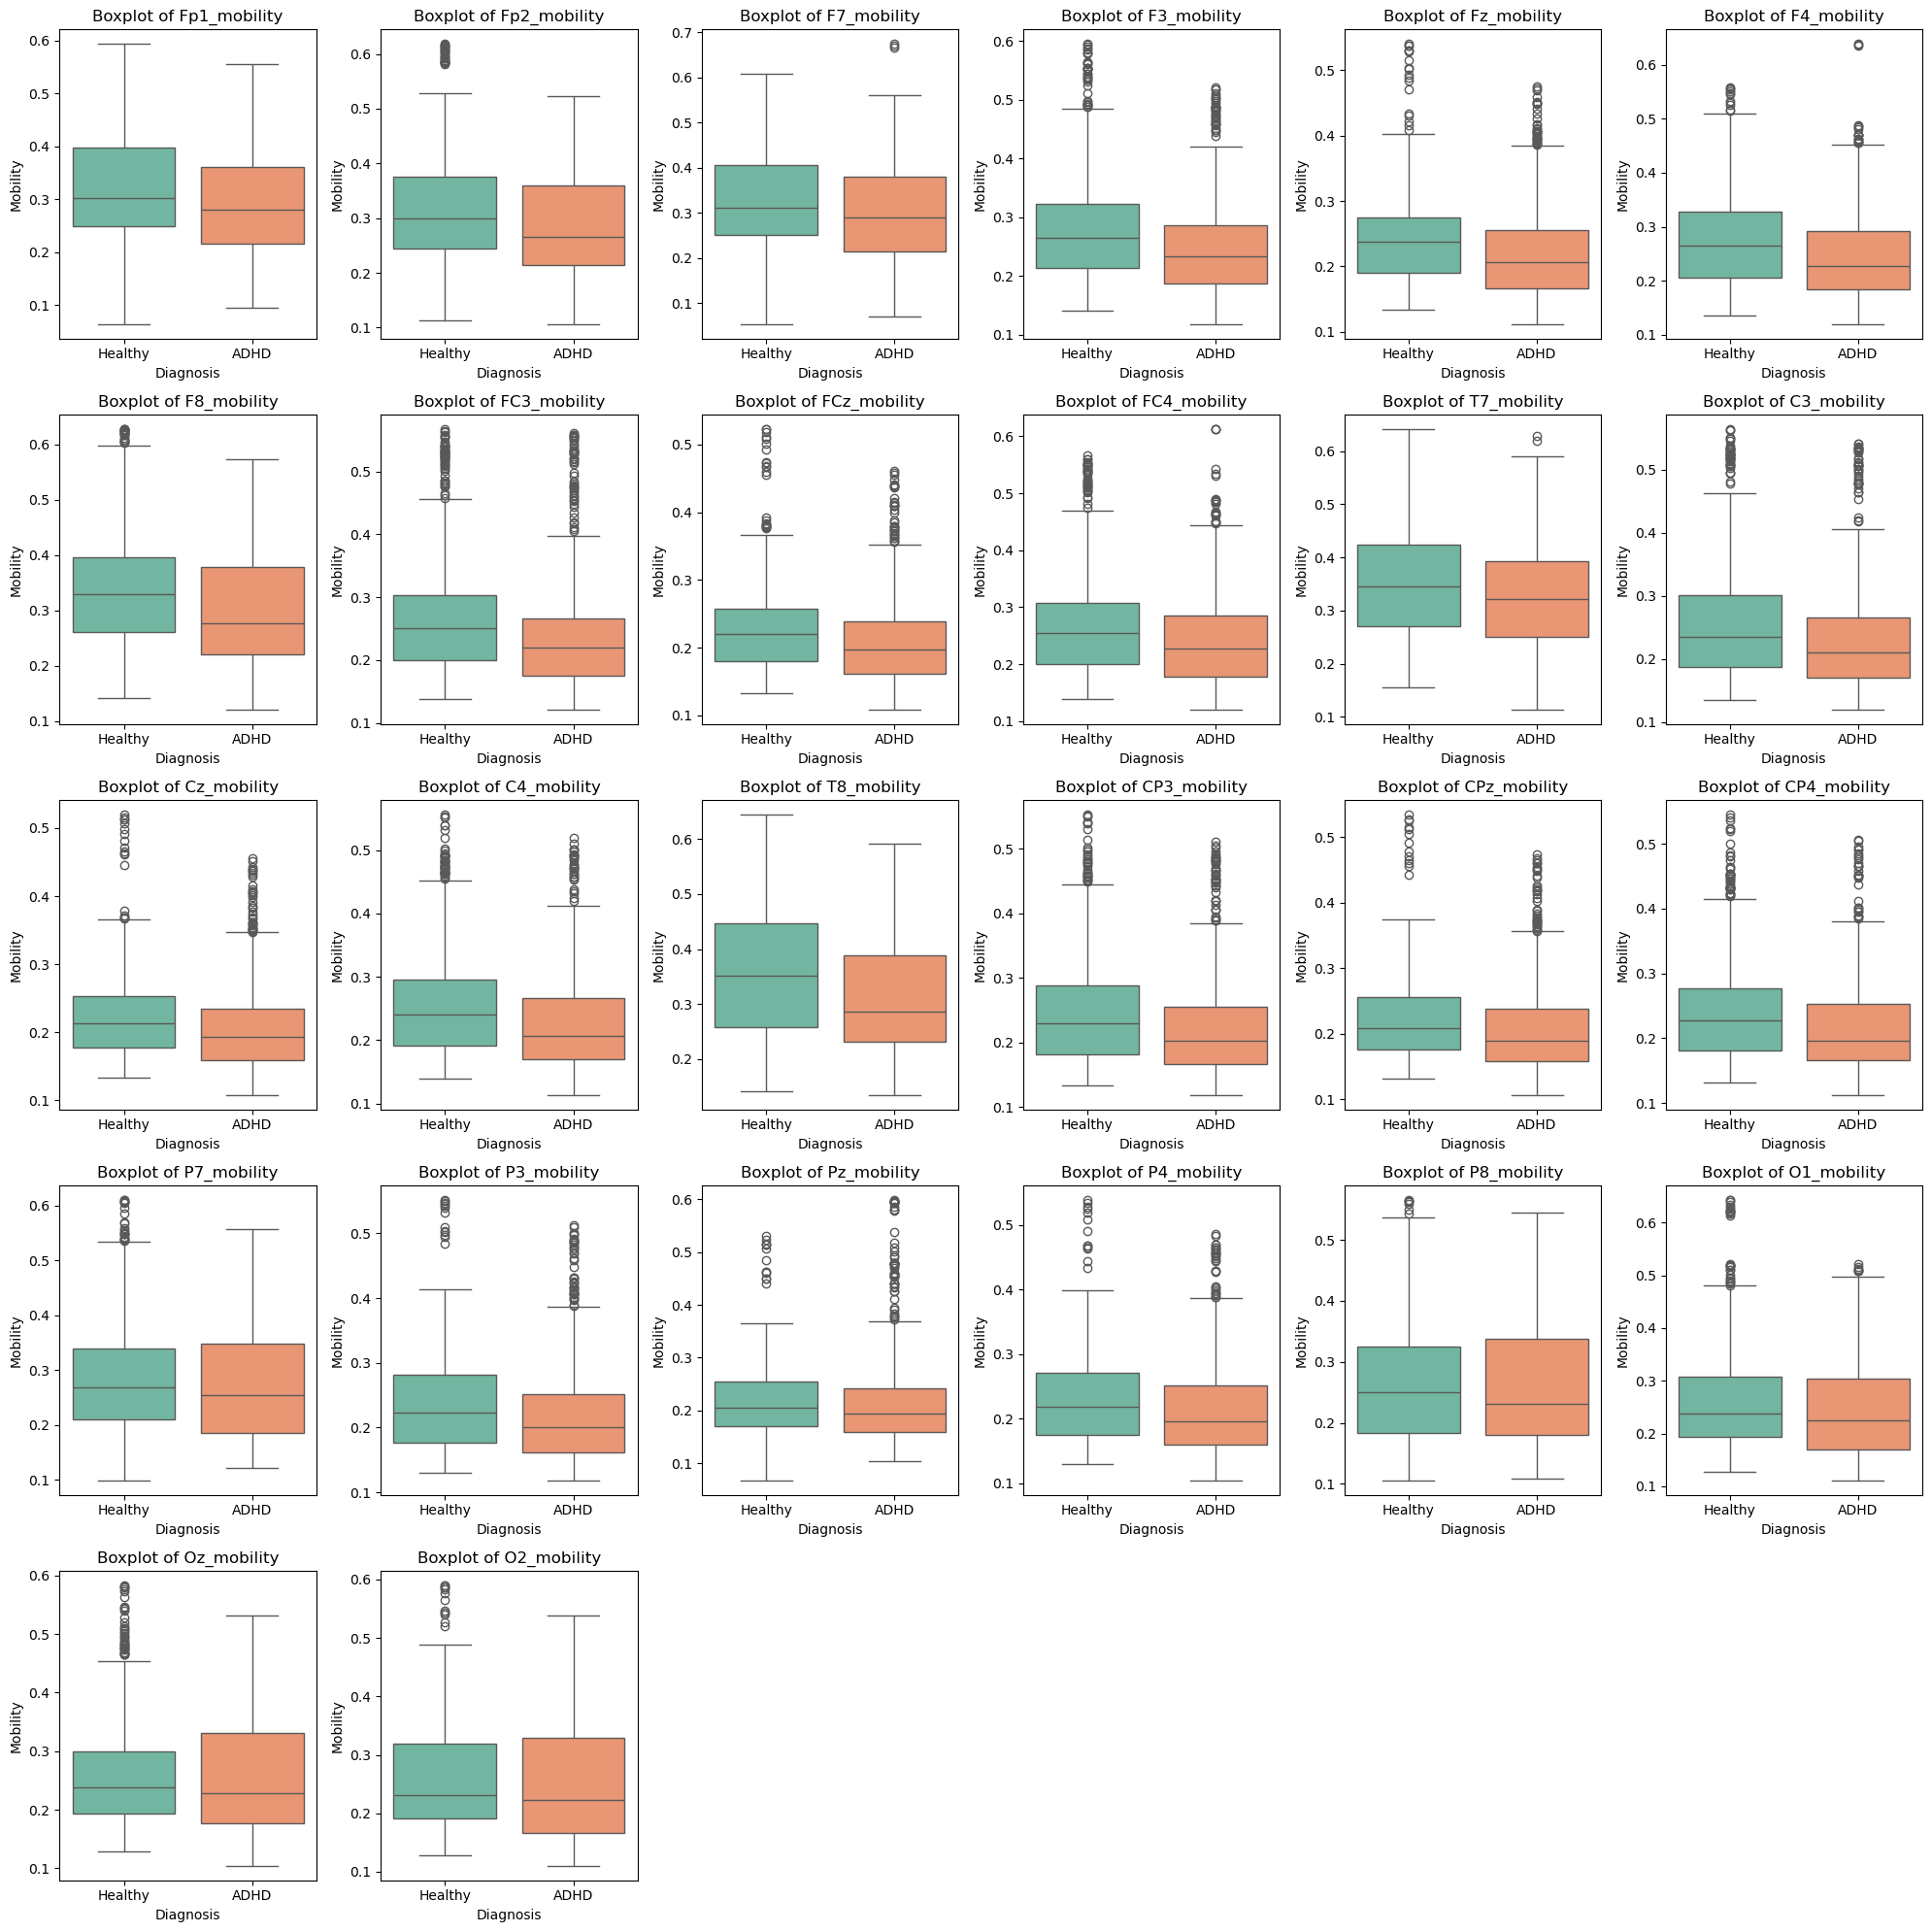

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns


mobility_val_columns = mobility_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(mobility_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=mobility_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Mobility')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

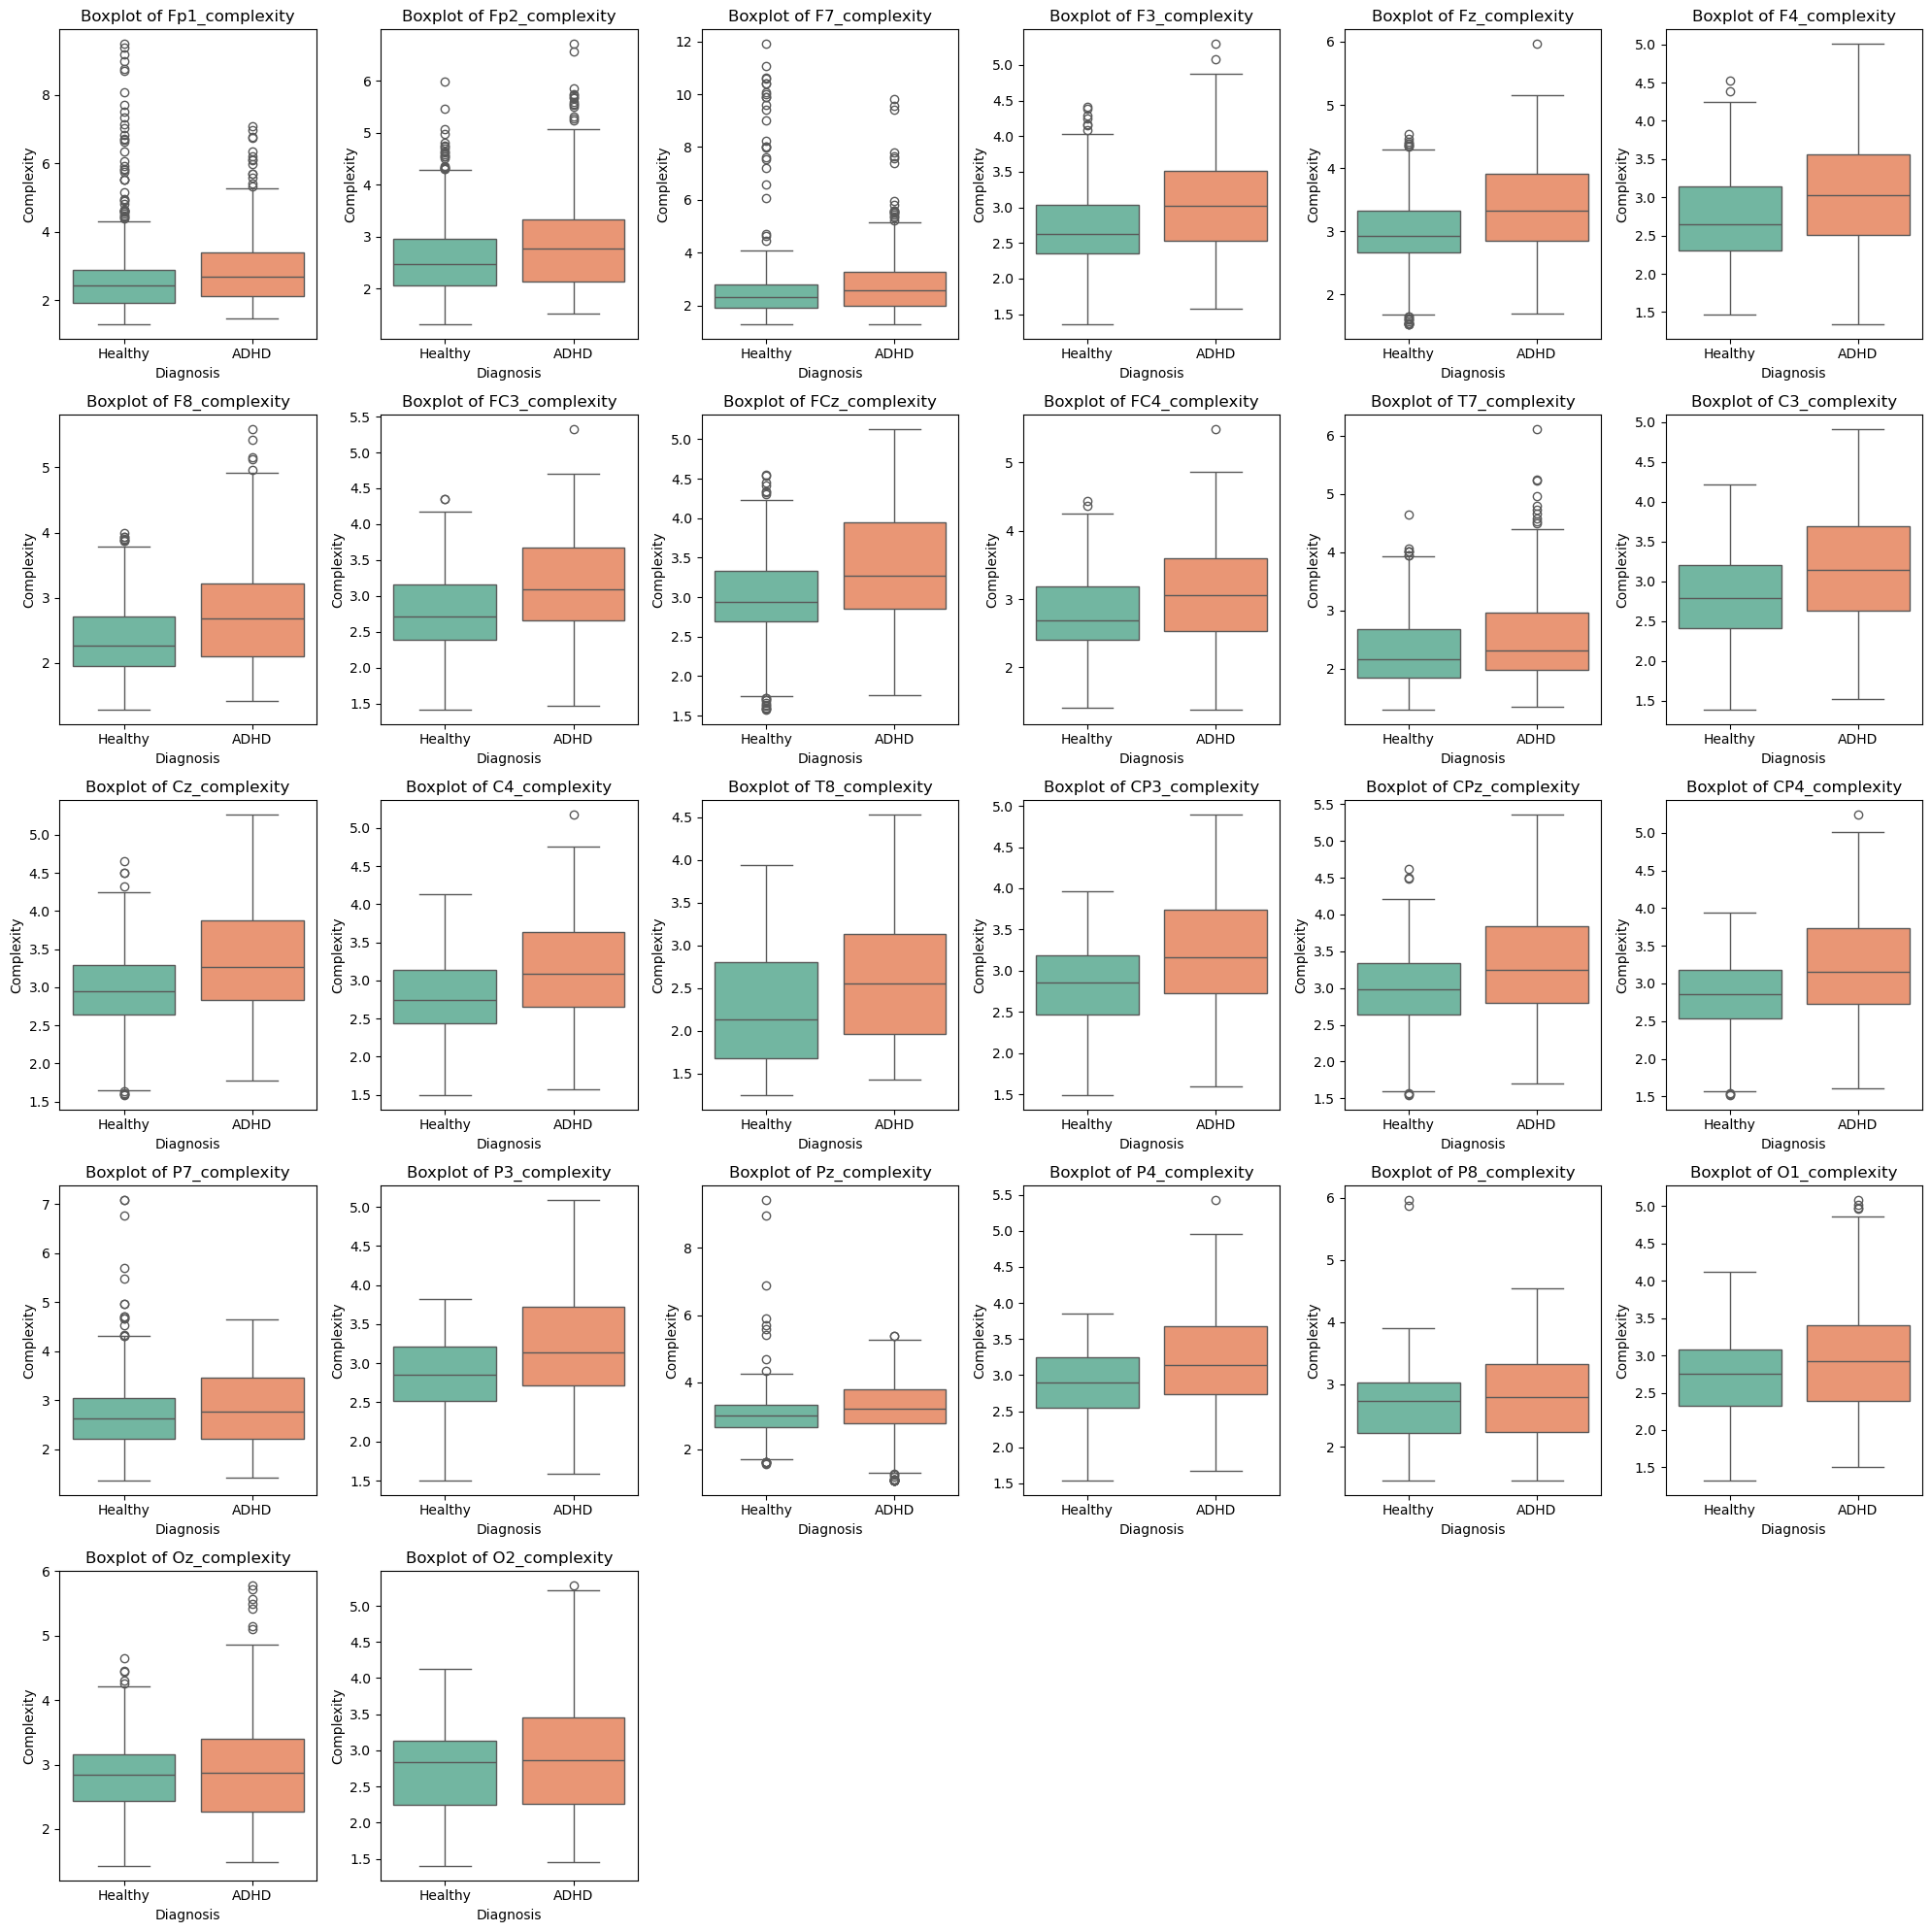

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


complexity_val_columns = complexity_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(complexity_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=complexity_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Complexity')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

5. Leftover features: RMS values, mean values, delta power and gamma power

In [35]:
mean_vals = training_df.filter(regex='mean_val|diagnosis')
rms_vals = training_df.filter(regex='rms_val|diagnosis')
delta_powers = training_df.filter(regex='delta_power|diagnosis')
gamma_powers = training_df.filter(regex='gamma_power|diagnosis')

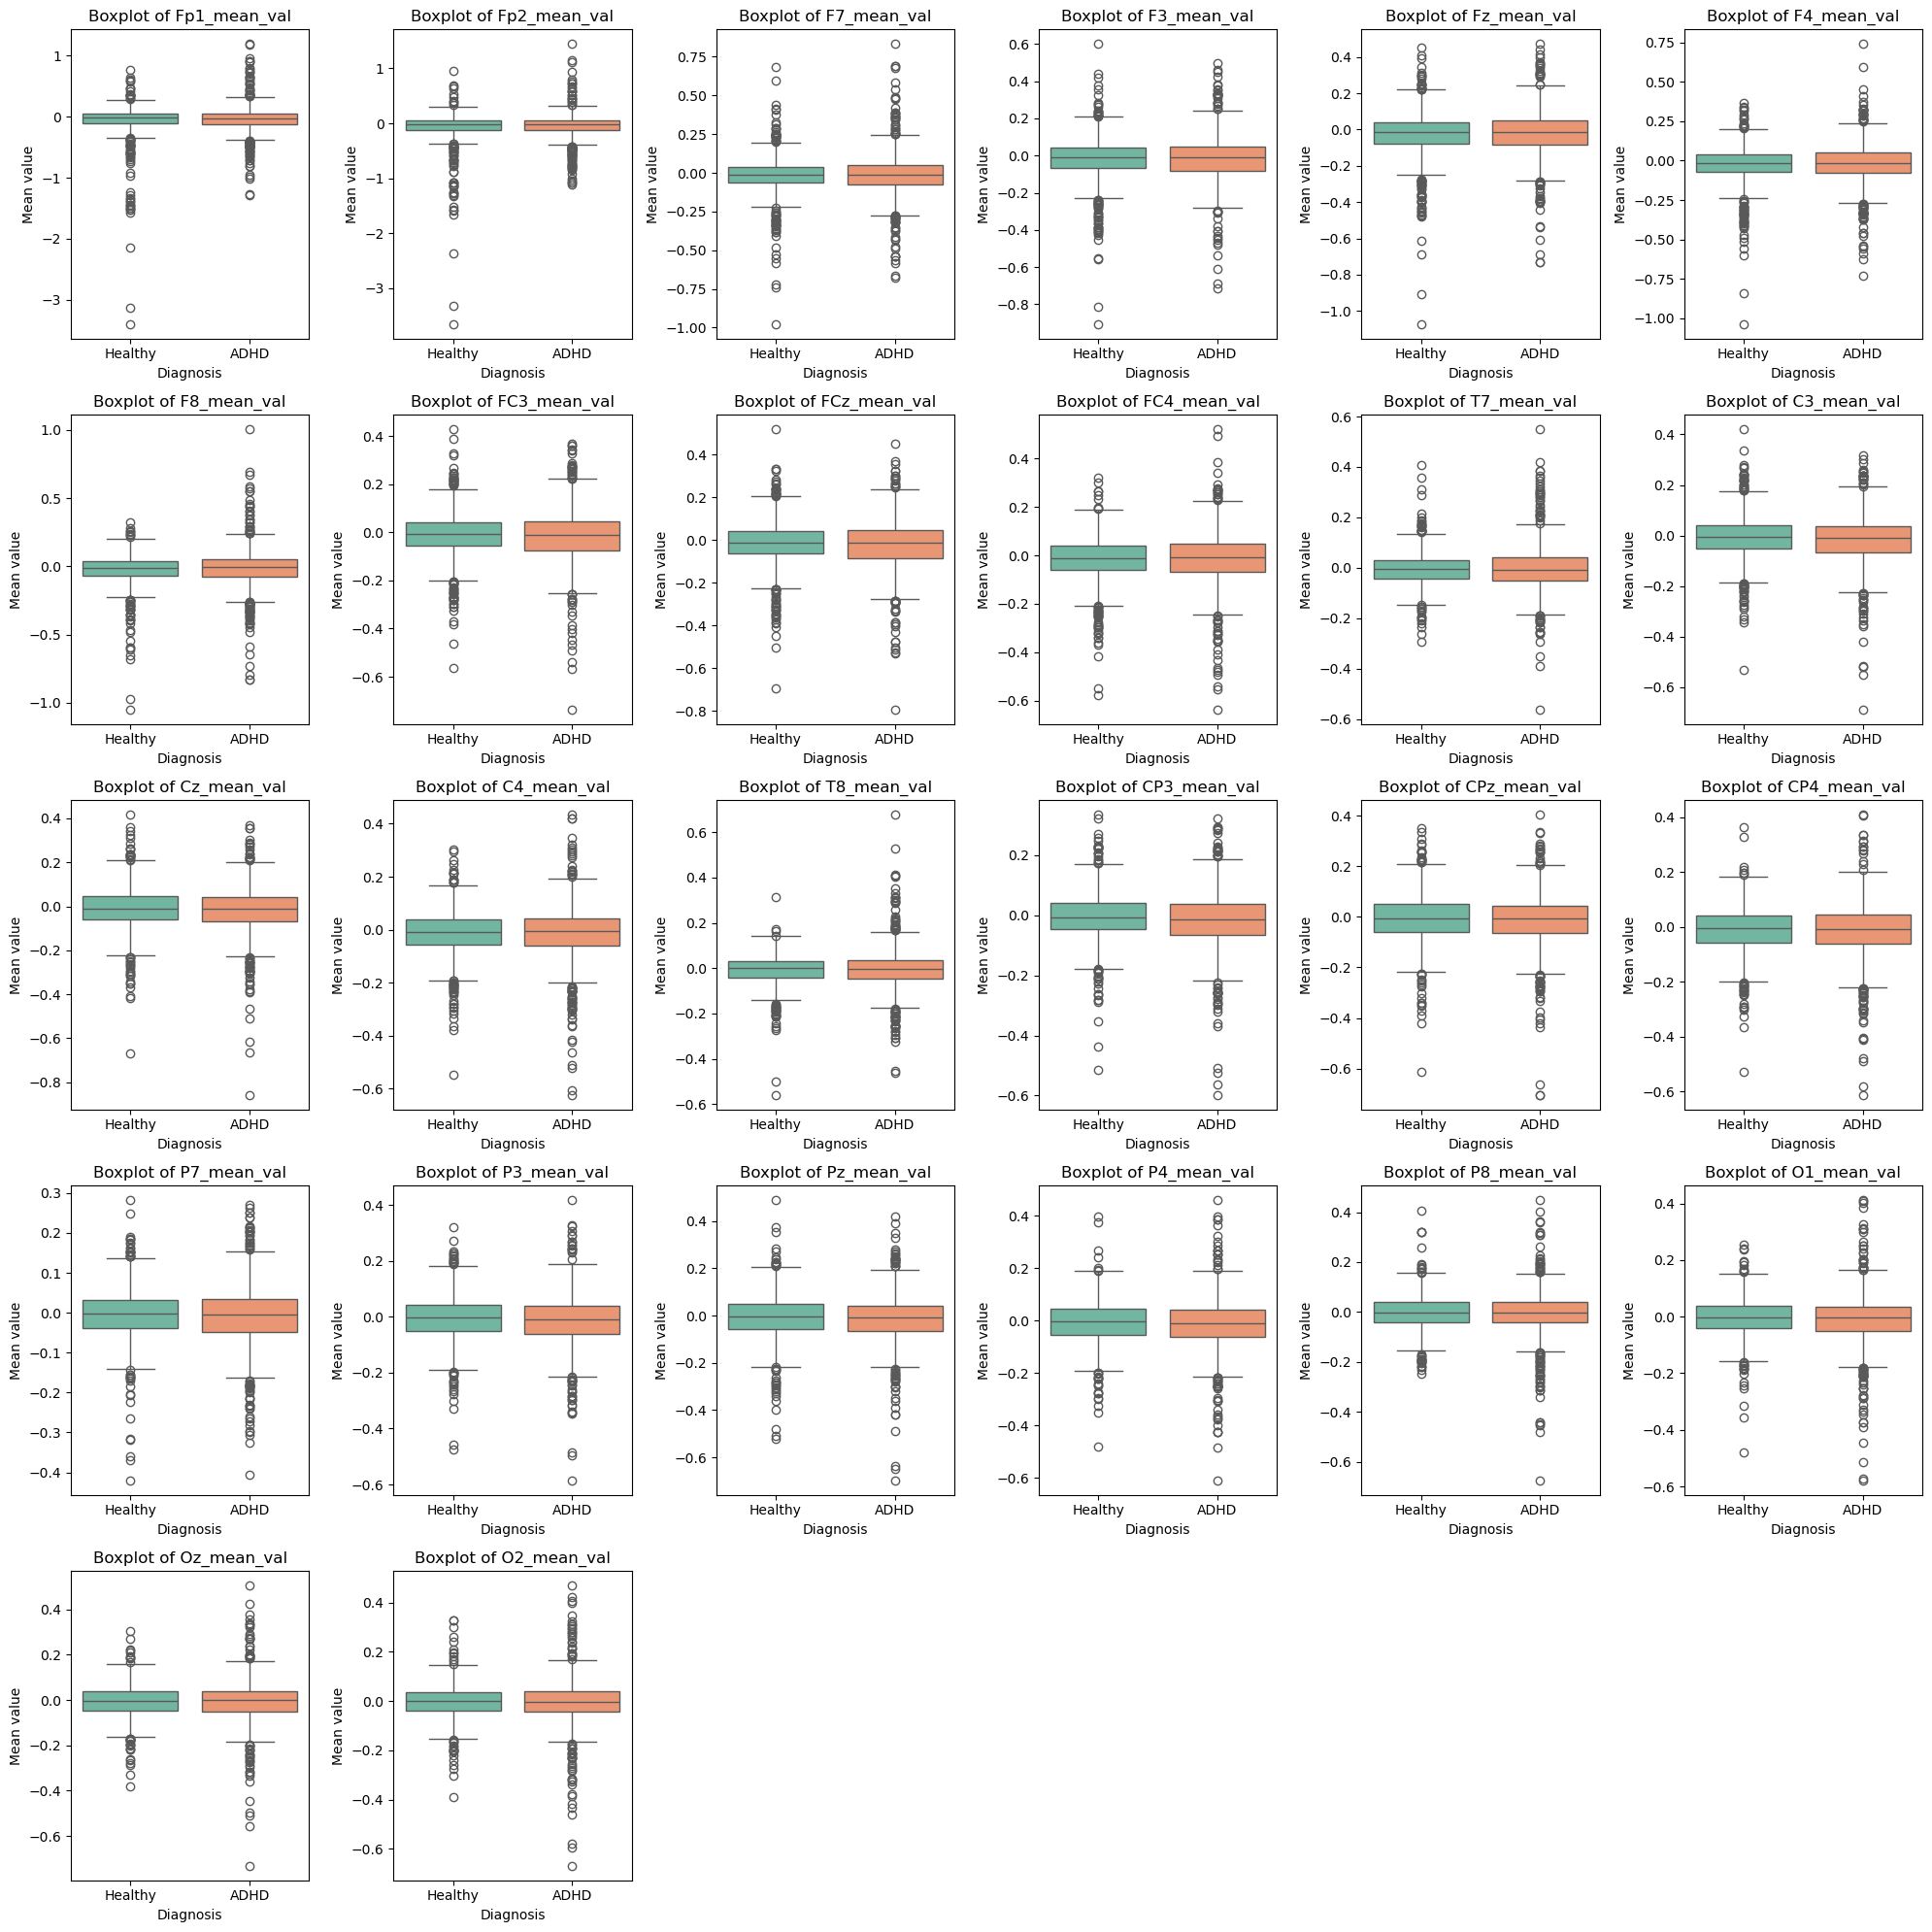

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns


mean_val_columns = mean_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(mean_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=mean_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Mean value')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

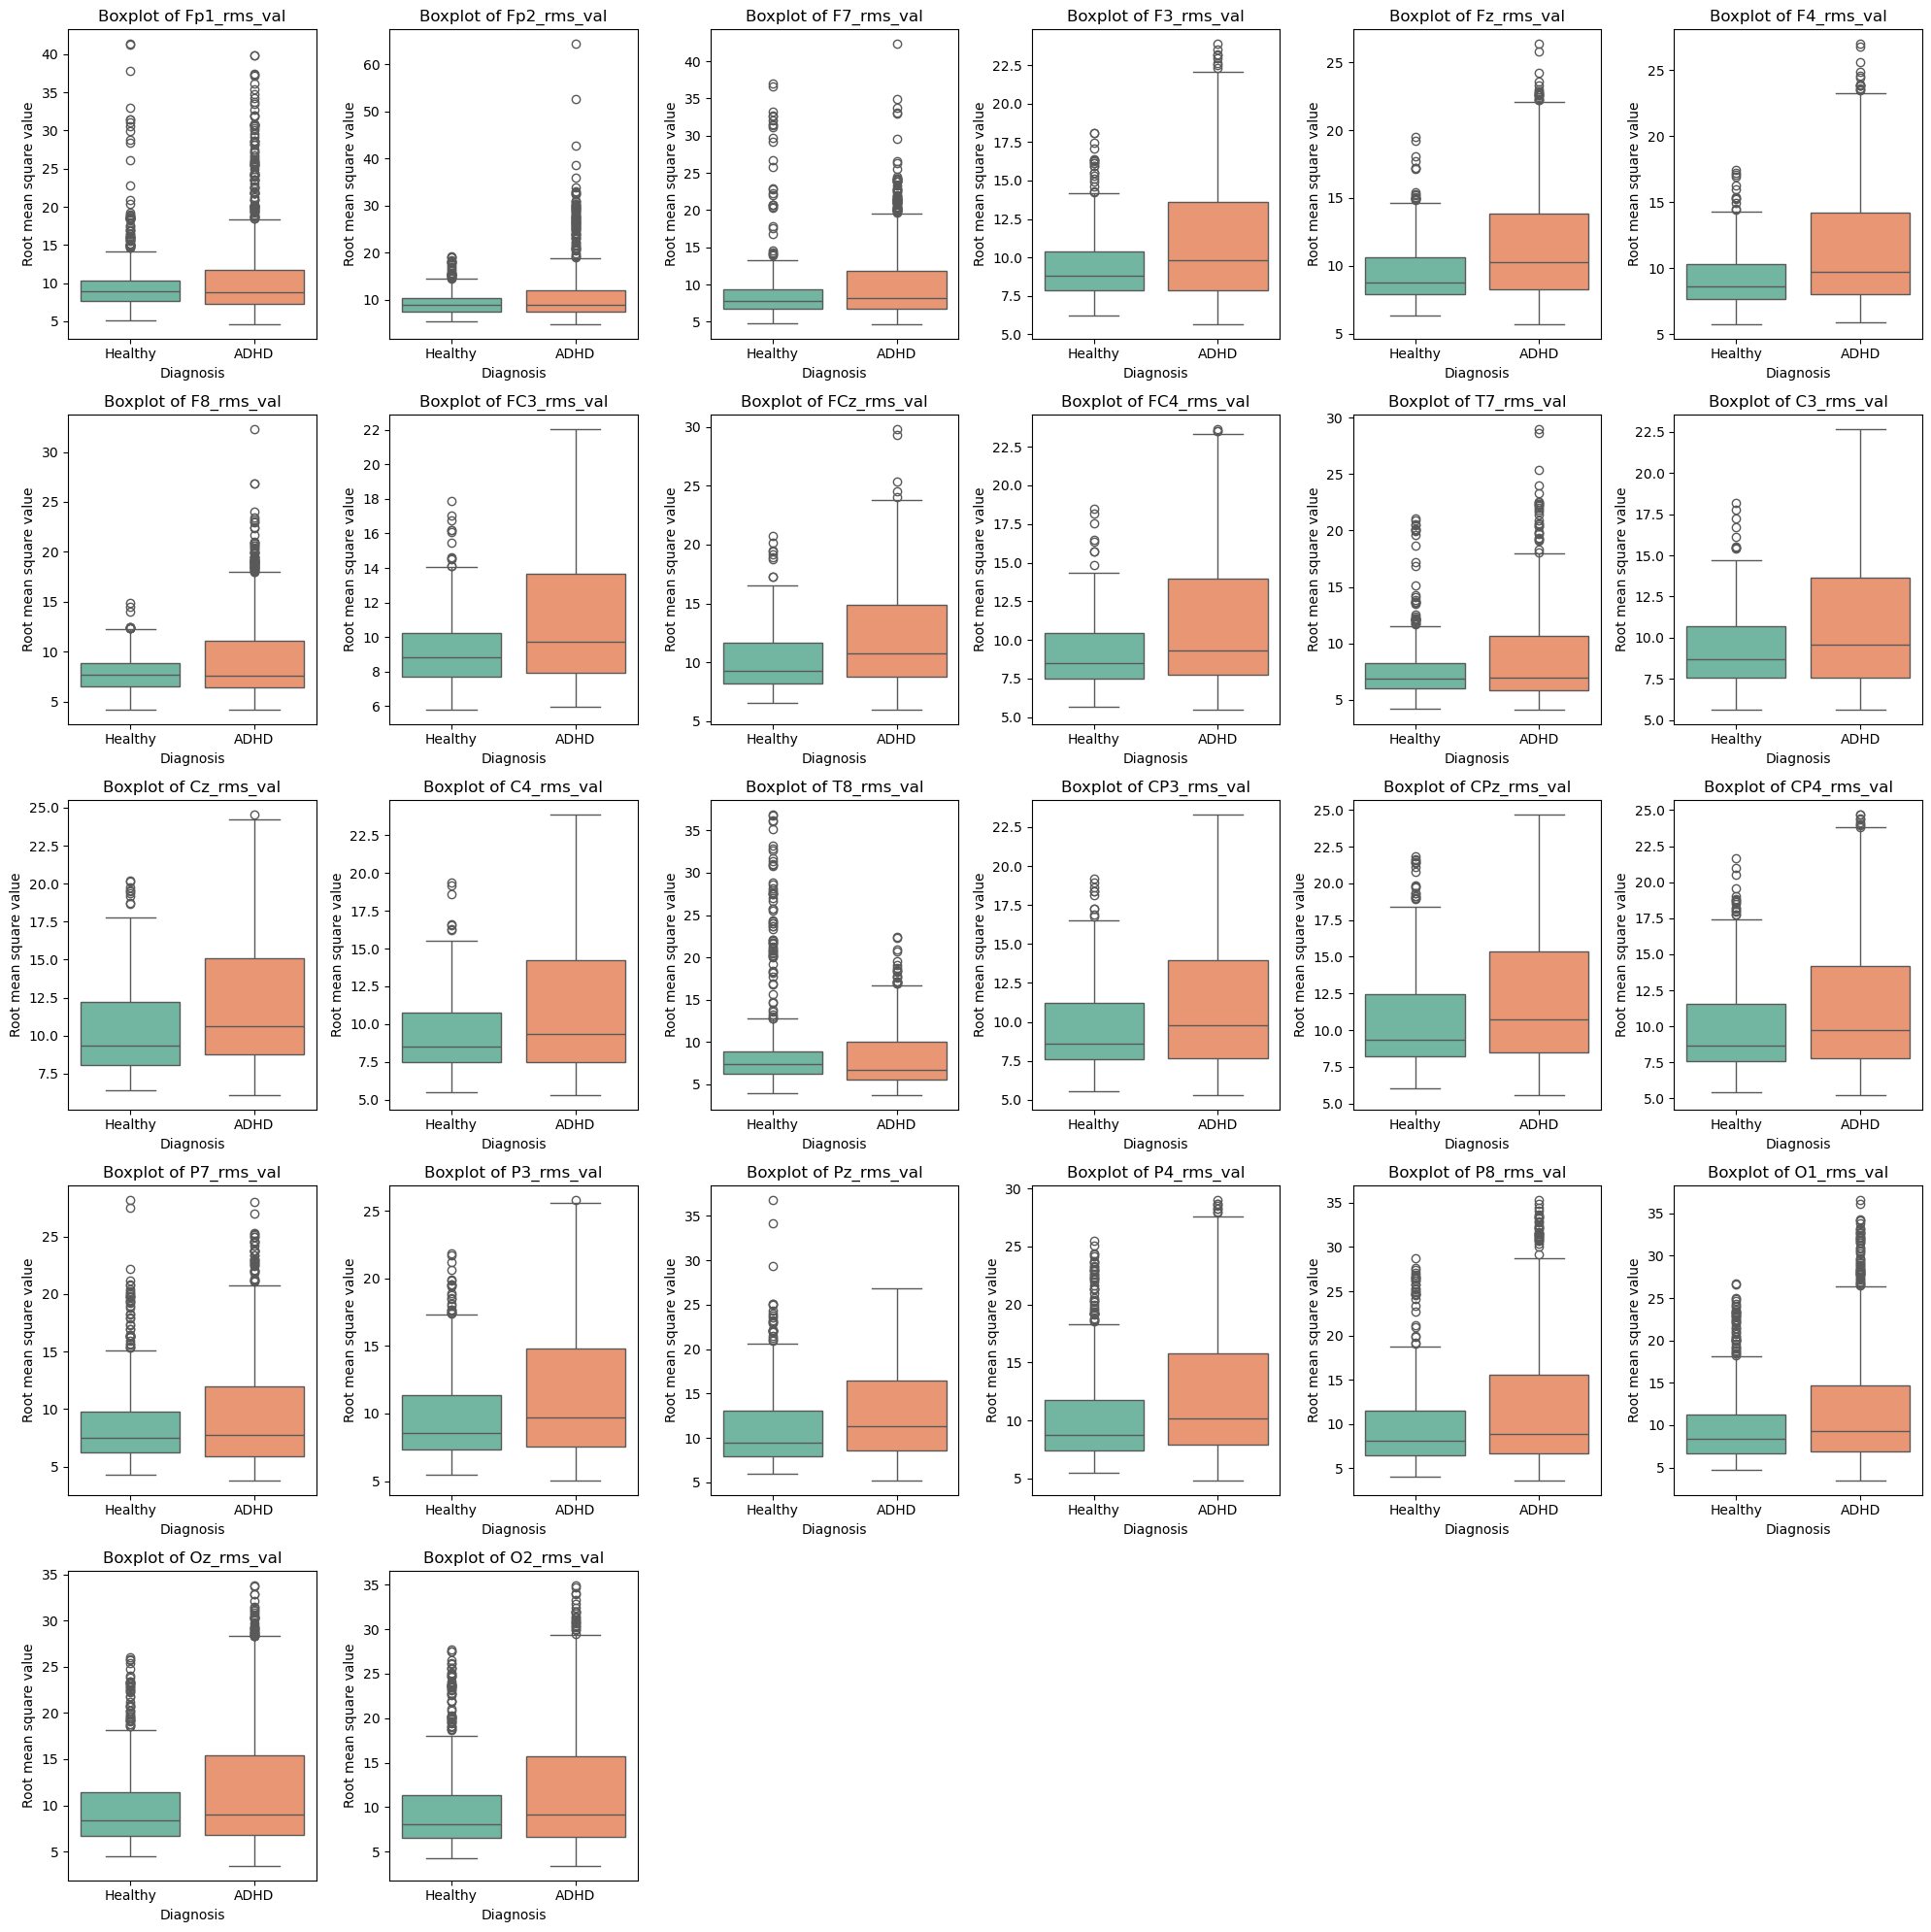

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns


rms_val_columns = rms_vals.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(rms_val_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=rms_vals, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Root mean square value')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

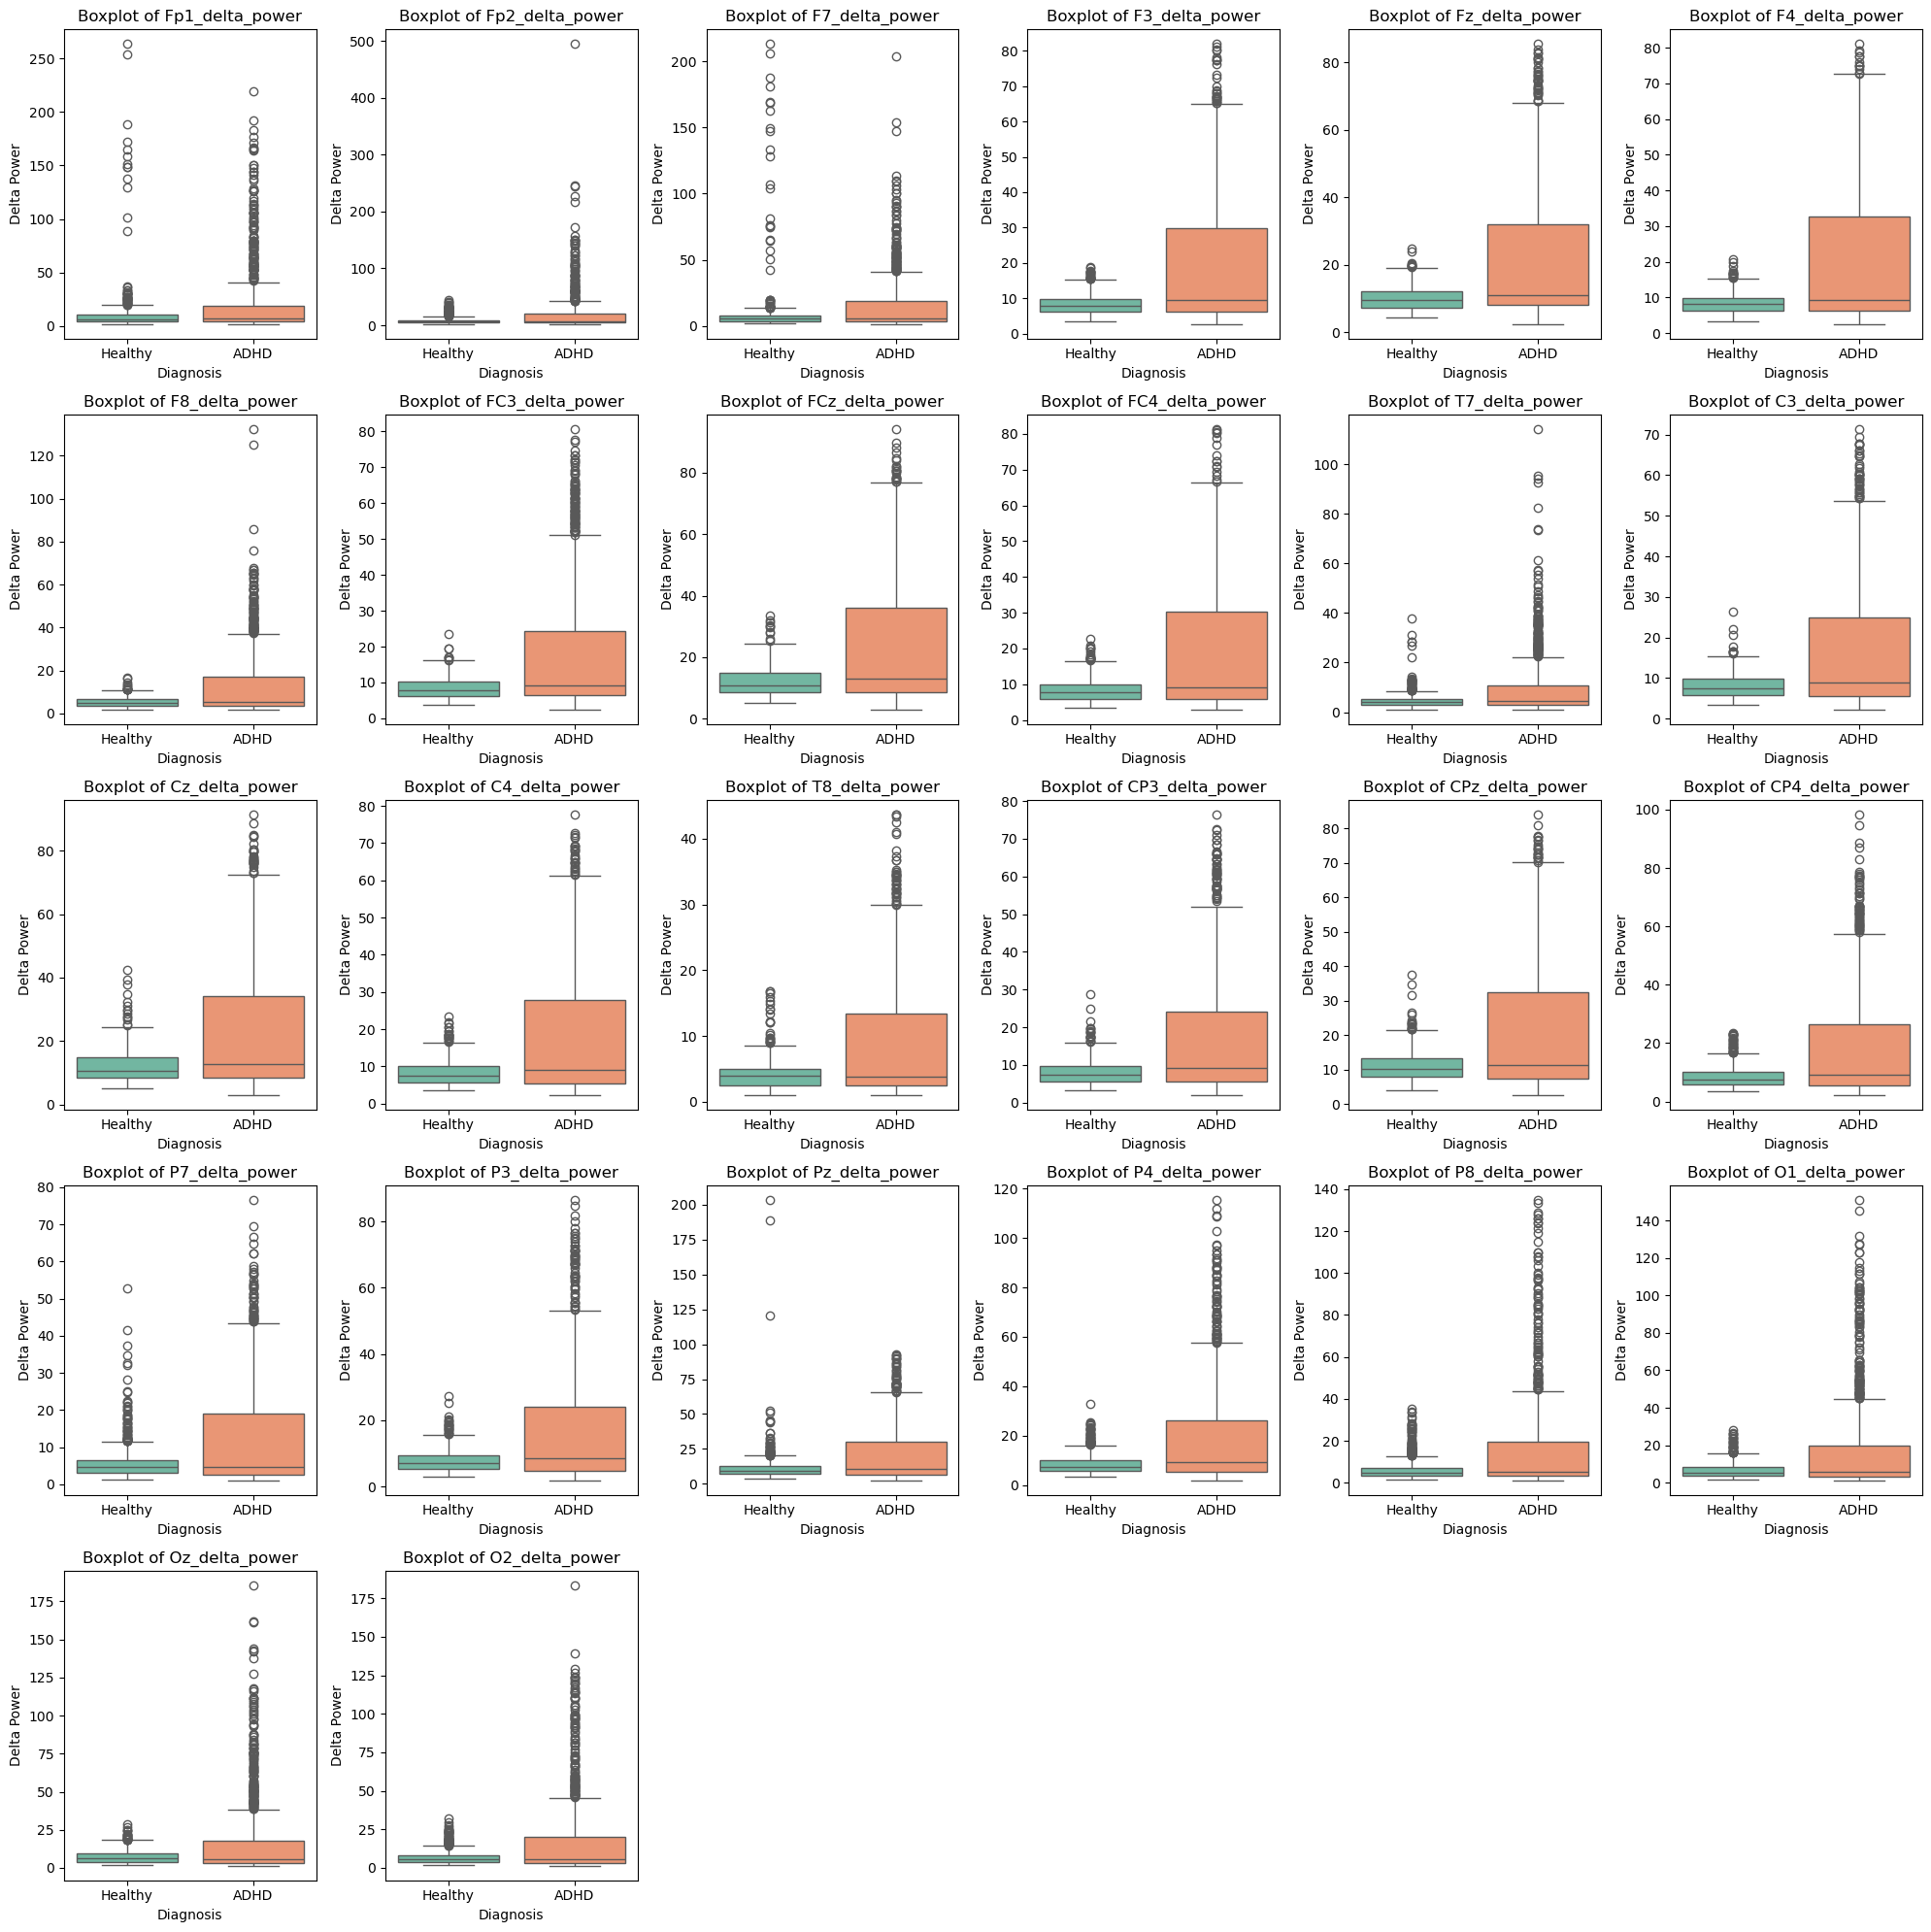

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns


delta_power_columns = delta_powers.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(delta_power_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=delta_powers, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Delta Power')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

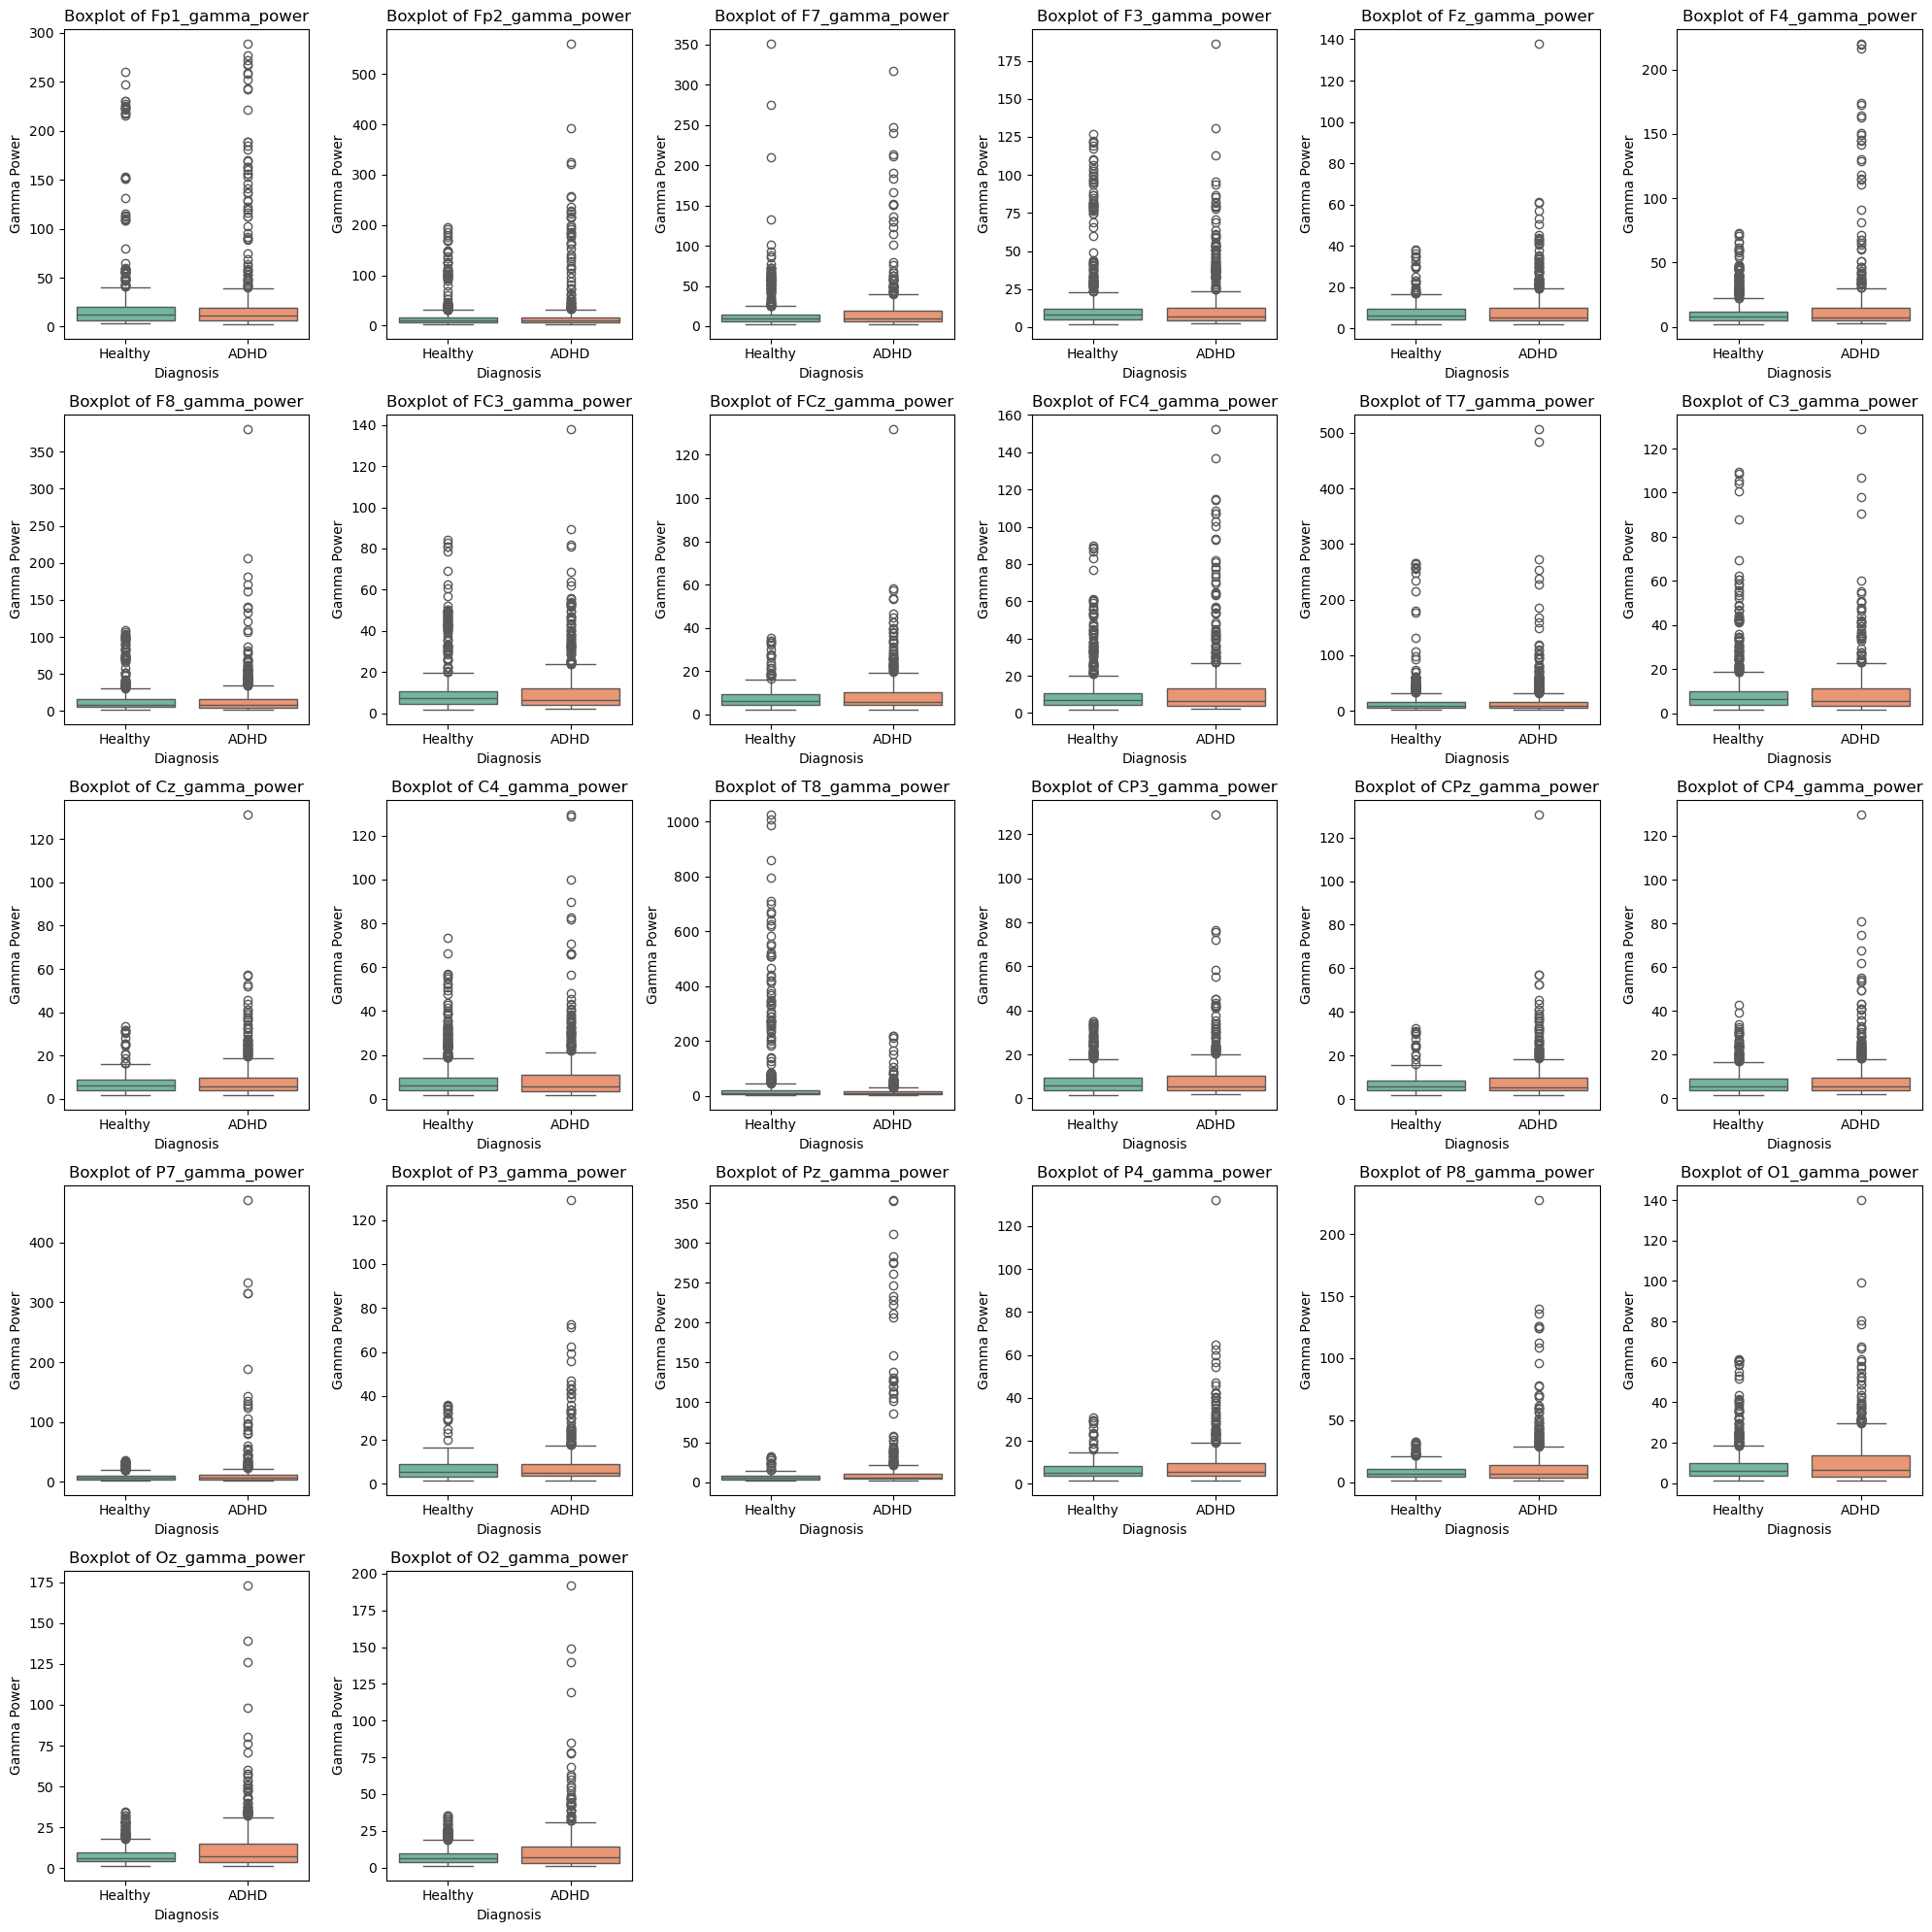

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns


gamma_power_columns = gamma_powers.columns[:-1] 


plt.figure(figsize=(20, 20)) 


for i, col in enumerate(gamma_power_columns, 1):
    plt.subplot(5, 6, i)  
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=gamma_powers, palette='Set2', legend=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Diagnosis')
    plt.ylabel('Gamma Power')
    plt.xticks(ticks=[0, 1], labels=["Healthy", "ADHD"])

plt.tight_layout()  
plt.show()

### Feature selection and classification

In [40]:
# Full feature selection (all 26 channels)

training_df_full = training_df.filter(regex="theta_power|theta_beta_ratio|shannon_entropy_val|katz_fd_val|higuchi_fd_val|complexity|rms_val")

# Specific feature-channel pair selection

training_df_specifics = training_df[["F7_alpha_power", "F3_alpha_power",  "FC3_alpha_power", "C3_alpha_power", "C4_alpha_power", "F3_activity",
"Fz_activity", "F4_activity",  "FC3_activity", "C3_activity", "Cz_activity", "C4_activity", "CP3_activity",  
"CPz_activity", "CP4_activity", "F7_mobility", "F3_mobility", "Fz_mobility", "F4_mobility", "F8_mobility", "T8_mobility",  "F3_delta_power", "Fz_delta_power", "F4_delta_power", "FC3_delta_power", "FCz_delta_power", 
"FC4_delta_power", "Cz_delta_power", "C4_delta_power", "CP3_delta_power", "diagnosis"]]

training_df_final = pd.concat([training_df_full, training_df_specifics], axis = 1)



In [41]:
testing_df_full = testing_df.filter(regex="theta_power|theta_beta_ratio|shannon_entropy_val|katz_fd_val|higuchi_fd_val|complexity|rms_val")

# Specific feature-channel pair selection

testing_df_specifics = testing_df[["F7_alpha_power", "F3_alpha_power",  "FC3_alpha_power", "C3_alpha_power", "C4_alpha_power", "F3_activity",
"Fz_activity", "F4_activity",  "FC3_activity", "C3_activity", "Cz_activity", "C4_activity", "CP3_activity",  
"CPz_activity", "CP4_activity", "F7_mobility", "F3_mobility", "Fz_mobility", "F4_mobility", "F8_mobility", "T8_mobility",  "F3_delta_power", "Fz_delta_power", "F4_delta_power", "FC3_delta_power", "FCz_delta_power", 
"FC4_delta_power", "Cz_delta_power", "C4_delta_power", "CP3_delta_power", "diagnosis"]]

testing_df_final = pd.concat([testing_df_full, testing_df_specifics], axis = 1)

In [42]:
validation_df_full = validation_df.filter(regex="theta_power|theta_beta_ratio|shannon_entropy_val|katz_fd_val|higuchi_fd_val|complexity|rms_val")

# Specific feature-channel pair selection

validation_df_specifics = validation_df[["F7_alpha_power", "F3_alpha_power",  "FC3_alpha_power", "C3_alpha_power", "C4_alpha_power", "F3_activity",
"Fz_activity", "F4_activity",  "FC3_activity", "C3_activity", "Cz_activity", "C4_activity", "CP3_activity",  
"CPz_activity", "CP4_activity", "F7_mobility", "F3_mobility", "Fz_mobility", "F4_mobility", "F8_mobility", "T8_mobility",  "F3_delta_power", "Fz_delta_power", "F4_delta_power", "FC3_delta_power", "FCz_delta_power", 
"FC4_delta_power", "Cz_delta_power", "C4_delta_power", "CP3_delta_power", "diagnosis"]]

validation_df_final = pd.concat([validation_df_full, validation_df_specifics], axis = 1)

In [43]:
X_train_final, X_test_final, X_val_final, y_train_final, y_test_final, y_val_final = training_df_final.drop(columns=['diagnosis']), testing_df_final.drop(columns=['diagnosis']), validation_df_final.drop(columns=['diagnosis']), training_df_final['diagnosis'], testing_df_final['diagnosis'], validation_df_final['diagnosis'] 

Standardization

In [44]:
scaler = StandardScaler()

X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)
X_val_final = scaler.transform(X_val_final)

##### SVM

In [45]:
svm = SVC()

svm.fit(X_train_final, y_train_final)
y_pred_svm = svm.predict(X_test_final)

In [46]:
print(classification_report(y_test_final, y_pred_svm))

              precision    recall  f1-score   support

           0       0.79      0.35      0.48        78
           1       0.71      0.95      0.81       130

    accuracy                           0.72       208
   macro avg       0.75      0.65      0.65       208
weighted avg       0.74      0.72      0.69       208



In [47]:
from sklearn.metrics import confusion_matrix

In [48]:
print(confusion_matrix(y_test_final, y_pred_svm))

[[ 27  51]
 [  7 123]]


### Neural Network

In [53]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500, random_state=42)
mlp.fit(X_train_final, y_train_final)
y_pred_mlp = mlp.predict(X_test_final)

In [54]:
print(classification_report(y_test_final, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.85      0.29      0.44        78
           1       0.70      0.97      0.81       130

    accuracy                           0.72       208
   macro avg       0.77      0.63      0.62       208
weighted avg       0.75      0.72      0.67       208



In [56]:
print(confusion_matrix(y_test_final, y_pred_mlp))

[[ 23  55]
 [  4 126]]
